# Exit Angle Analysis
## Spring 2024
### Author: Mitsuru Watanabe

**Key findings**
- Smaller galaxies $< 10^7 M_{sol}$ shows angle dependency (indication of ram pressure stripping)
- Around 1st pericentric passage is the most significant place for ram pressure stripping
- No significant change with SN-driven outflow
- Maybe indication of tidal stripping at 180 degrees for small galaxies


This notebook investigates the relationship between the launched angle of discharged gas and the time it discharged or the stellar mass of the galaxy from which the gas is discharged.

Previously, Leo found that there is some angle dependency for discharged gas, especially near 0 degrees where the ram pressure stripping likely causes that to happen. However, our studies with more massive galaxies included showed that there is some sort of time dependency, particularly at the 1st pericentric passage, and the mass of the galaxy the gas is discharged from. 

It is found that the smaller galaxies, about $< 10^7 M_{sol}$, tend to show angle dependency than massive galaxies. We have also found that at the 1st pericentric passage, the distribution of the discharged gas angle is most significant, which is apparent for smaller galaxies. There is no significant different between supernova-heated gas and non supernova-heated gas when it is discharged. This indicates that there is a similar type of role for the ram pressure stripping in browing the gas out. On a side note, for small galaxies, we may see some effect of tidal stripping, that is in the opposite angle from the ram pressure.

In [2]:
import pynbody
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
from math import isclose #used for plotting SFR over time graph

from base import *
from compiler import *
from analysis import *
from infallinganalysis import *

base.py executed
compiler.py executed


In [3]:
# quick check to ensure all selected satellites are accounted for.
path = f'{rootPath}SNe-heated_Gas_Flow/SNeData/predischarged_particles.hdf5'
import h5py
with h5py.File(path) as data:
    print(len(data.keys()), 'Available keys:', *data.keys())

29 Available keys: h148_10 h148_12 h148_2 h148_249 h148_251 h148_27 h148_282 h148_3 h148_34 h148_38 h148_4 h148_55 h148_6 h148_65 h229_14 h229_18 h229_20 h229_22 h229_49 h242_10 h242_21 h242_30 h242_38 h242_401 h242_69 h242_8 h329_117 h329_29 h329_7


## Exit Angle
Refer to Leo's `StellarFeedbackAnalysis.ipynb`

In [4]:
# quick calc. for ubiquitous weights in plotting.
@pynbody.derived_array
def wt(*gas):
    if len(gas) == 1:
        return np.array(gas[0]['mass'] / gas[0]['mass'].sum())
    
    else:
        return np.array(gas[0]['mass'] / gas[1]['mass'].sum())

In [5]:
# constructing bins for exit angle histograms.
N = 30
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])

In [6]:
#load the discharged gas
key = 'h148_10'

sim = str(key[:4])
haloid = int(key[5:])

predischarged, discharged = read_one_discharged(key)
hot = discharged[discharged['snHeated']==True]  # heated.
cold = discharged[discharged['snHeated']==False]  # unheated.

# read tinfall, tquench, etc. time from csv file
data = pd.read_csv('SNeData/all-satellite-information-2.csv')
r_data = data[(data.sim==sim)&(data.haloid==haloid)]
print('Loaded:', key)

> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <
Loaded: h148_10


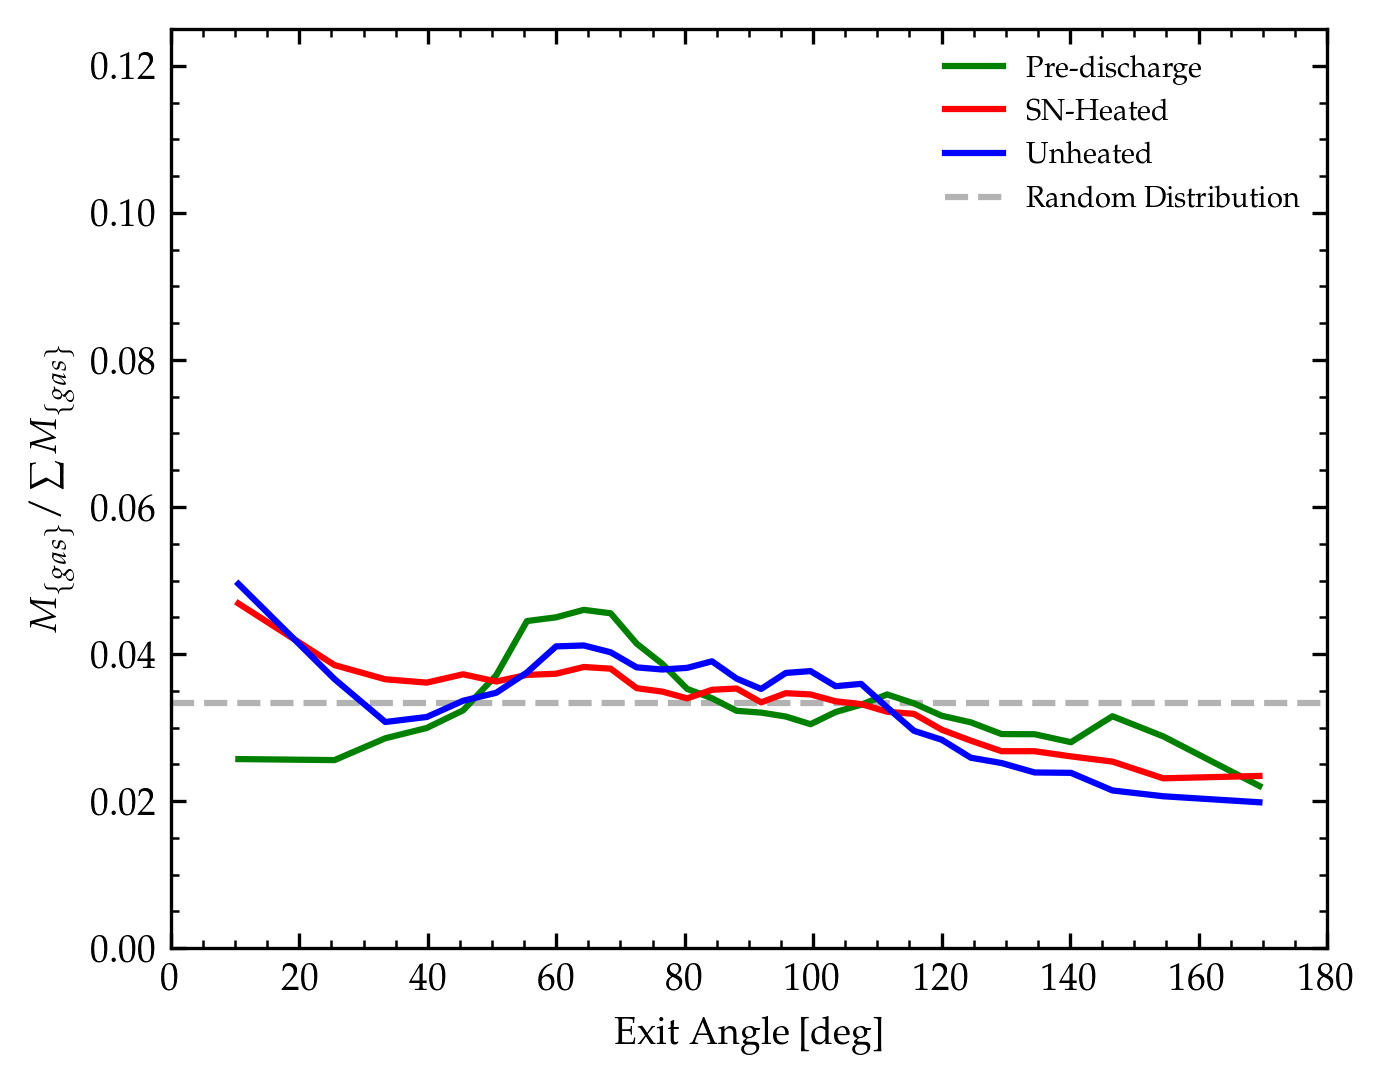

In [7]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3.5), constrained_layout=True) 

# applying conditional on distances of gas from center of satellite; collecting 
# frequency and bin information for plot.
y1, bins = np.histogram(predischarged.angle, bins=bins, weights=wt(predischarged))
ax.plot(bincenters, y1, label='Pre-discharge', c='green')

y2, bins = np.histogram(hot.angle, bins=bins, weights=wt(hot))
ax.plot(bincenters, y2, label='SN-Heated', c='r')

y3, bins = np.histogram(cold.angle, bins=bins, weights=wt(cold))
ax.plot(bincenters, y3, label='Unheated', c='b')


# line representing random distribution.
percent = 1/N
ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')


# labels, axis scaling, etc.
# ax.set_title('Exit Angle Distributions', fontsize='medium')
ax.set_xlabel(r'Exit Angle [deg]')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
ax.set_xlim(0,180)
ax.set_ylim(0,0.125)

ax.legend(frameon=False, fontsize='7')

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
#ax.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

#plt.savefig('F21plots/angles_dist.pdf')
plt.show()

In [8]:
#Now look at exit angle when at 1st pericentric passage
#show where it infalls, quenches if any, where at 1 Rvir, and where at the 1st pericentric
f_time = float(r_data['tinfall'])
p_time = float(r_data['1st p_time'])
vir_time = float(r_data['t_1Rvir_from_Host'])
q_time = float(r_data['tquench'])

try:
    dsc_p = discharged[np.isclose(np.array(discharged.time), p_time, atol=0.3)]
    hot_p = hot[np.isclose(np.array(hot.time), p_time, atol=0.3)]
    cold_p = cold[np.isclose(np.array(cold.time), p_time, atol=0.3)]
    pre_p = predischarged[np.isclose(np.array(predischarged.time), p_time, atol=0.3)]
except:
    pass

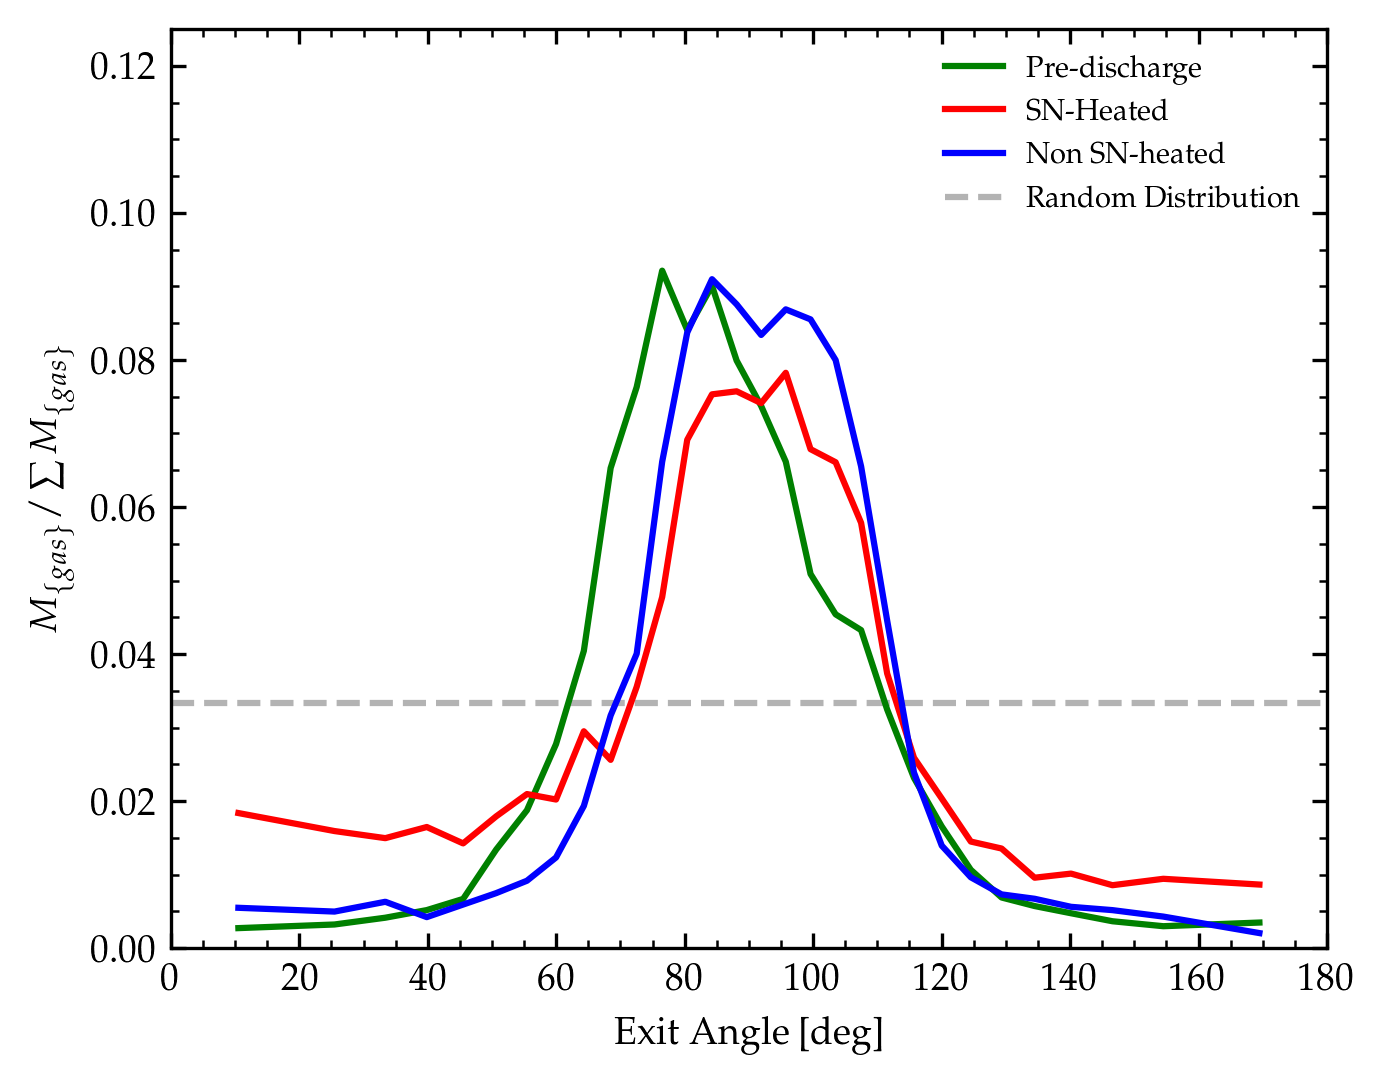

In [9]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3.5), constrained_layout=True) 

# plot
y1, bins = np.histogram(pre_p.angle, bins=bins, weights=wt(pre_p))
ax.plot(bincenters, y1, label='Pre-discharge', c='green')

y2, bins = np.histogram(hot_p.angle, bins=bins, weights=wt(hot_p))
ax.plot(bincenters, y2, label='SN-Heated', c='r')

y3, bins = np.histogram(cold_p.angle, bins=bins, weights=wt(cold_p))
ax.plot(bincenters, y3, label='Non SN-heated', c='b')


# line representing random distribution.
percent = 1/N
ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')


# labels, axis scaling, etc.
# ax.set_title('Exit Angle Distributions', fontsize='medium')
ax.set_xlabel(r'Exit Angle [deg]')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
ax.set_xlim(0,180)
ax.set_ylim(0,0.125)

ax.legend(frameon=False, fontsize='7')

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
#ax.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

#plt.savefig('F21plots/angles_dist.pdf')
plt.show()

found the keys, starting with:  h148_10
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <
> Returning <tracked_particle> dataset <
Loaded: h148_10


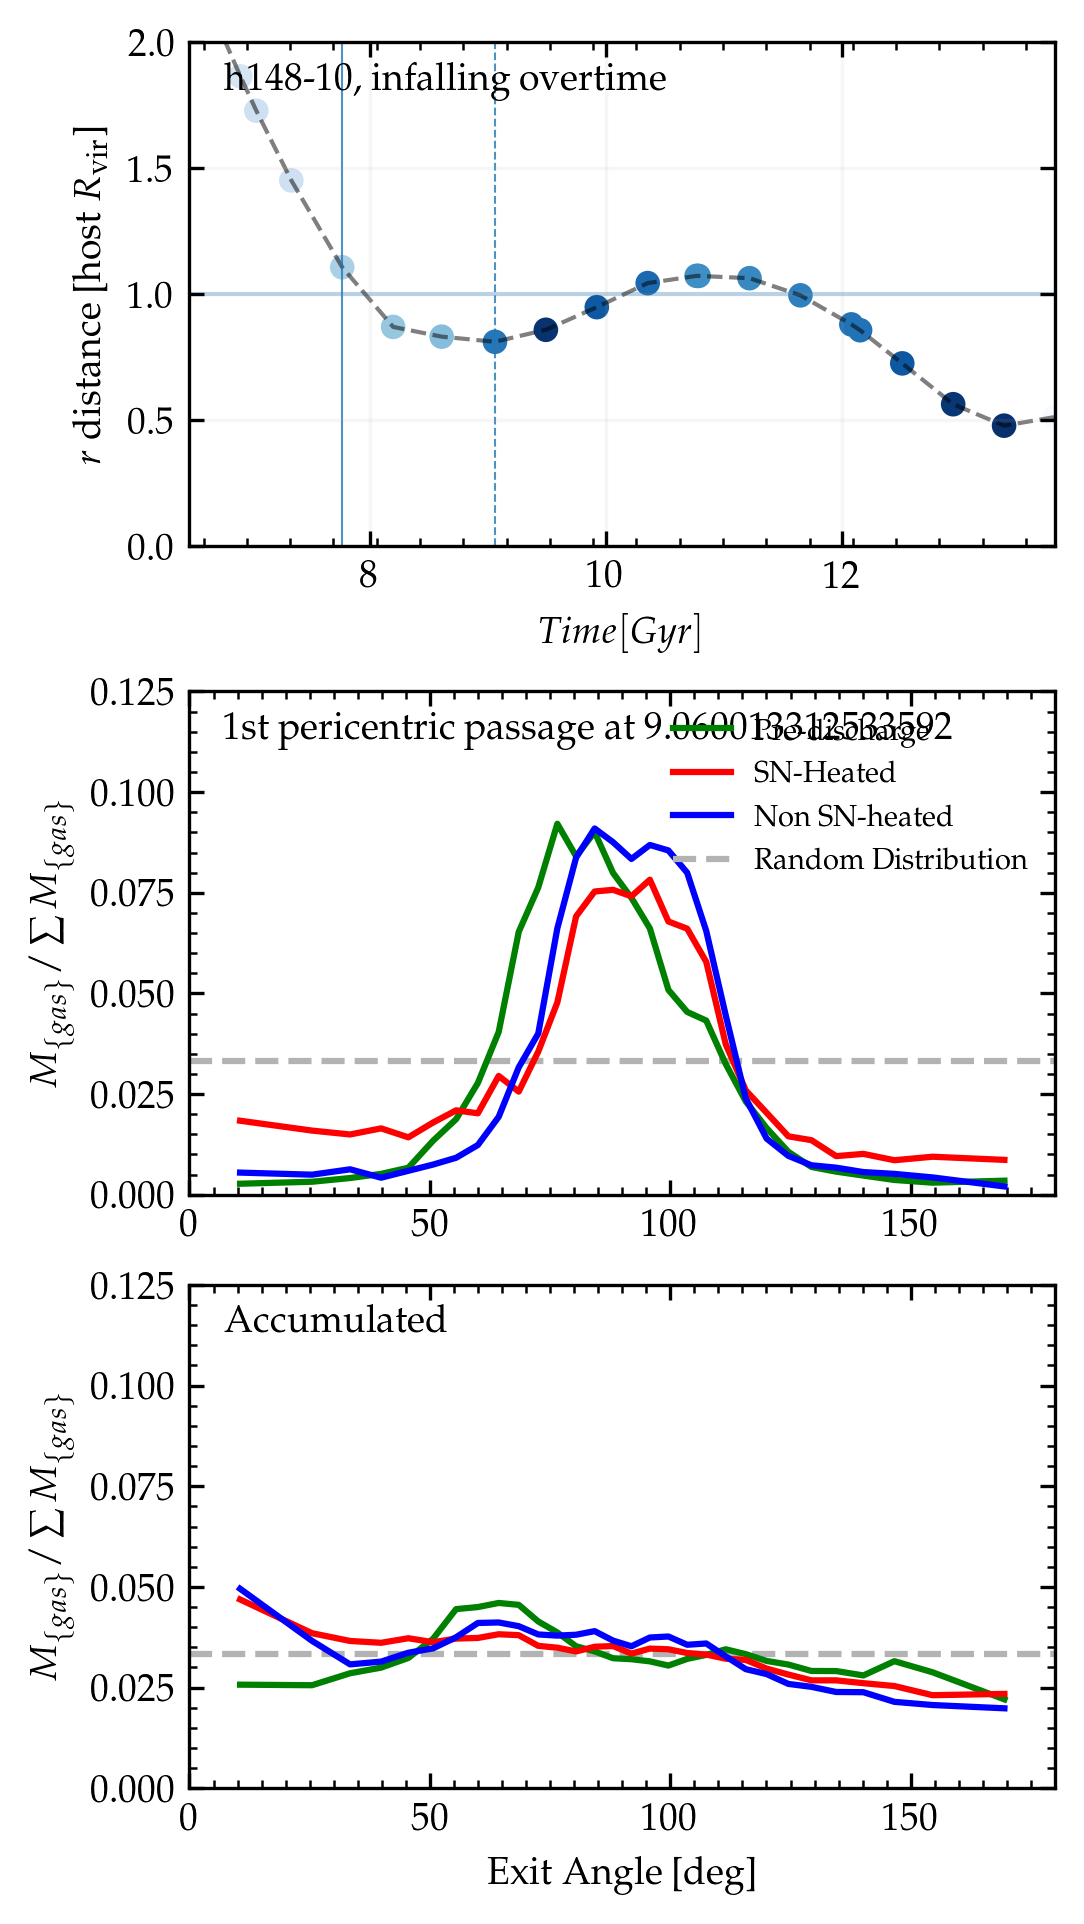

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_12 <
> Returning <tracked_particle> dataset <
Loaded: h148_12


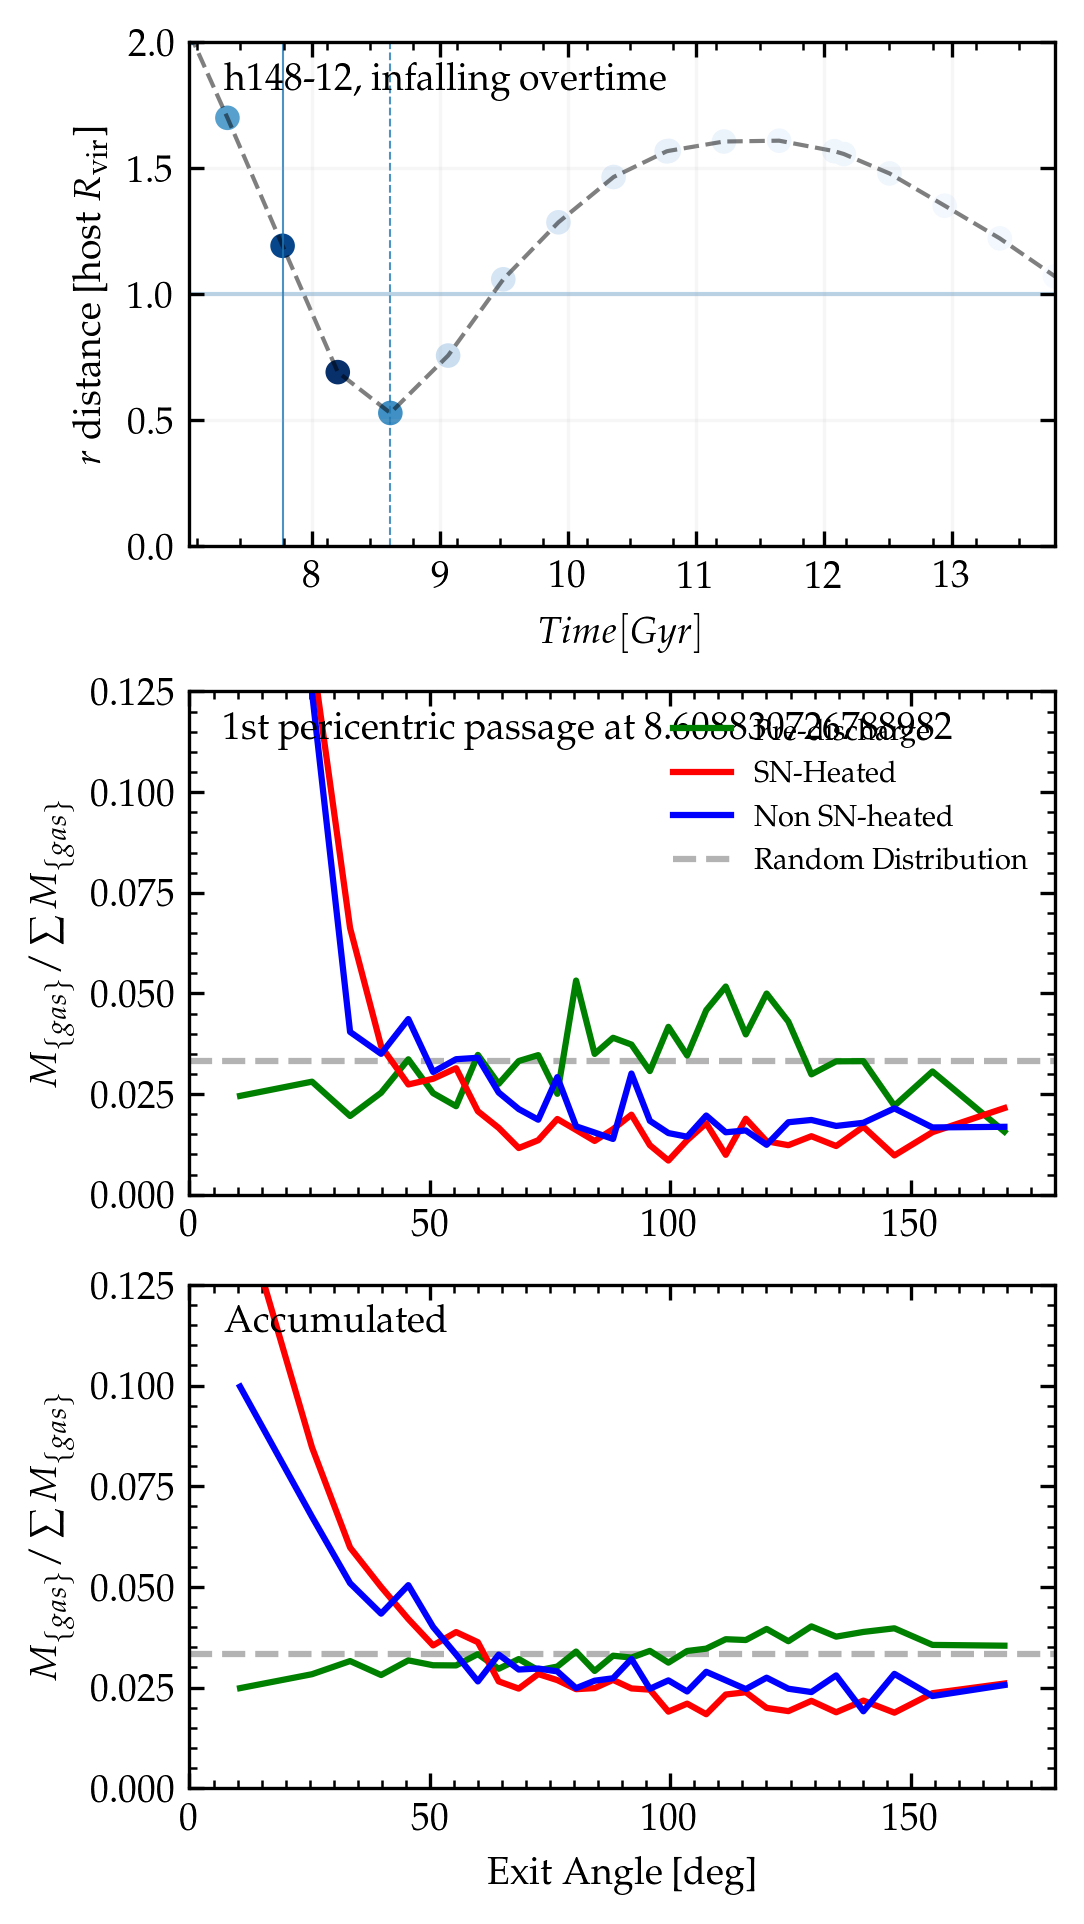

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_2 <
> Returning <tracked_particle> dataset <
Loaded: h148_2


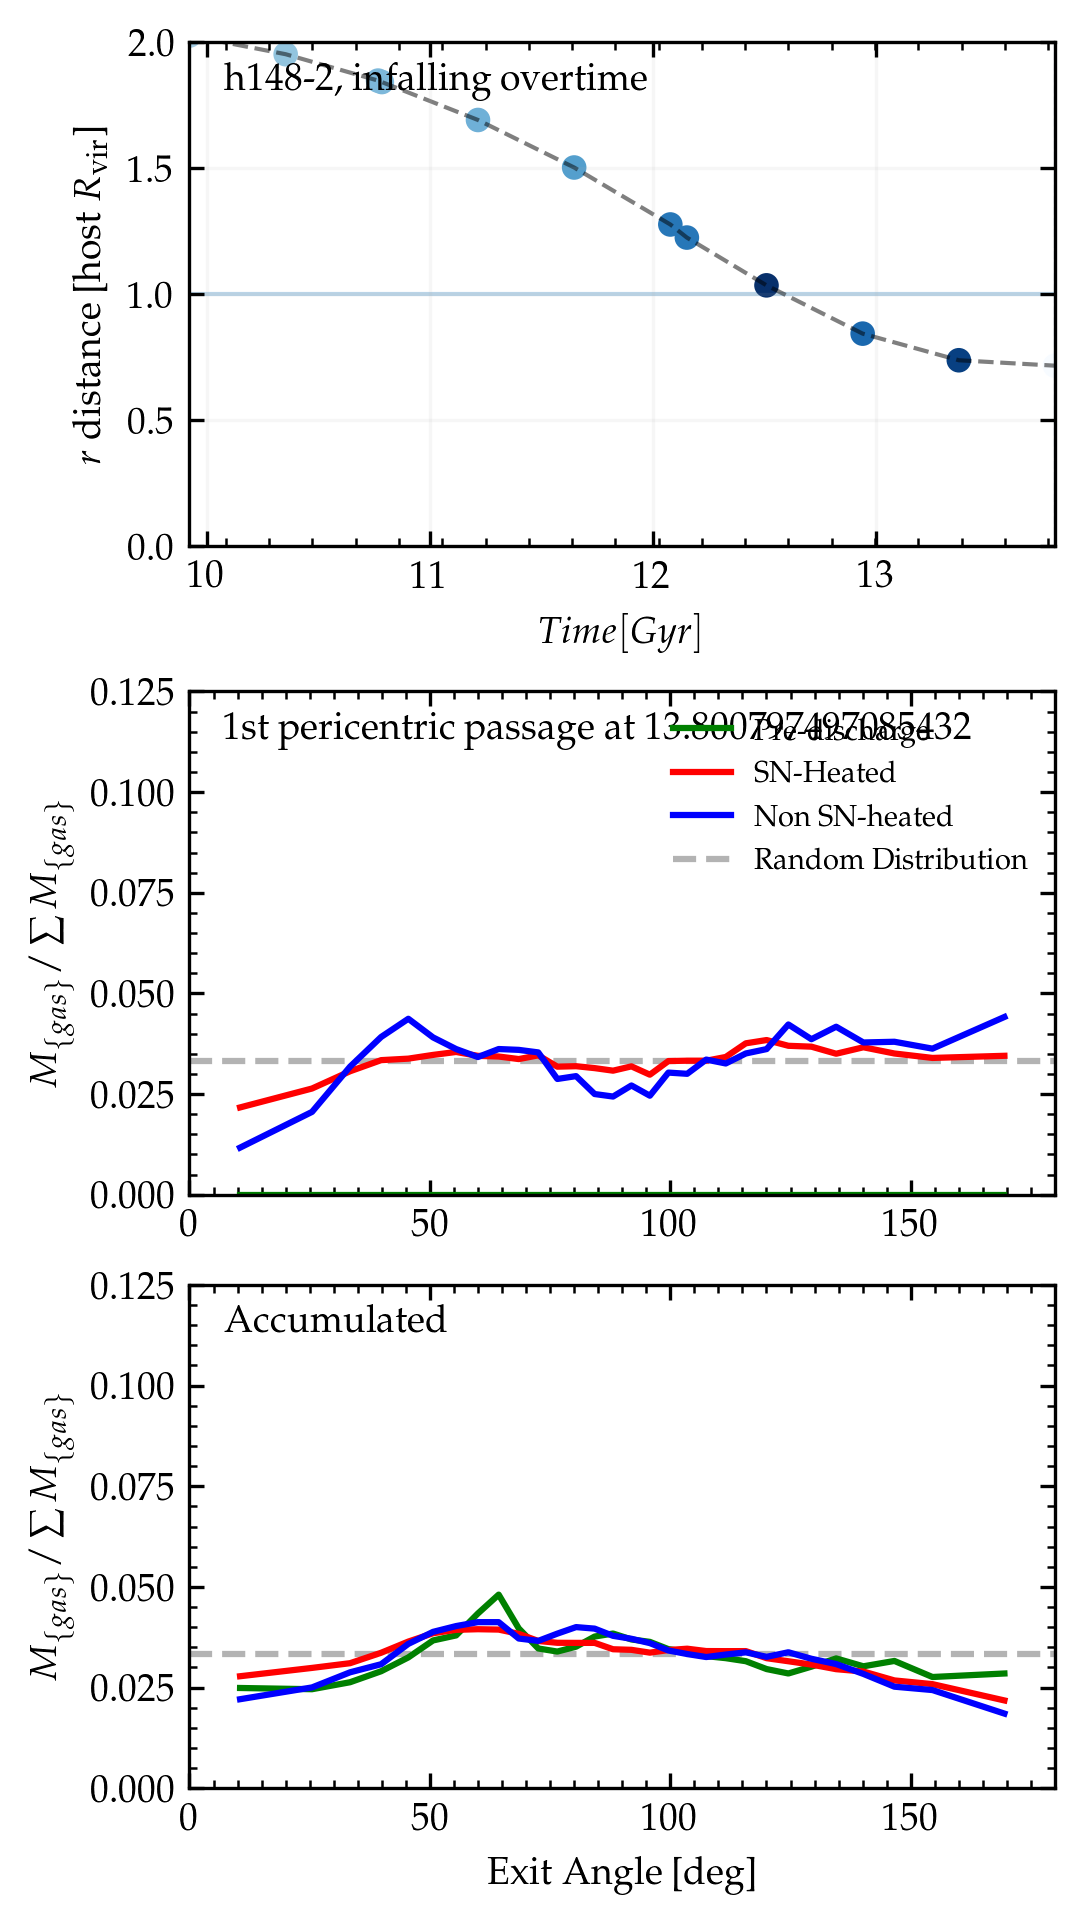

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_249 <
> Returning <tracked_particle> dataset <
Loaded: h148_249


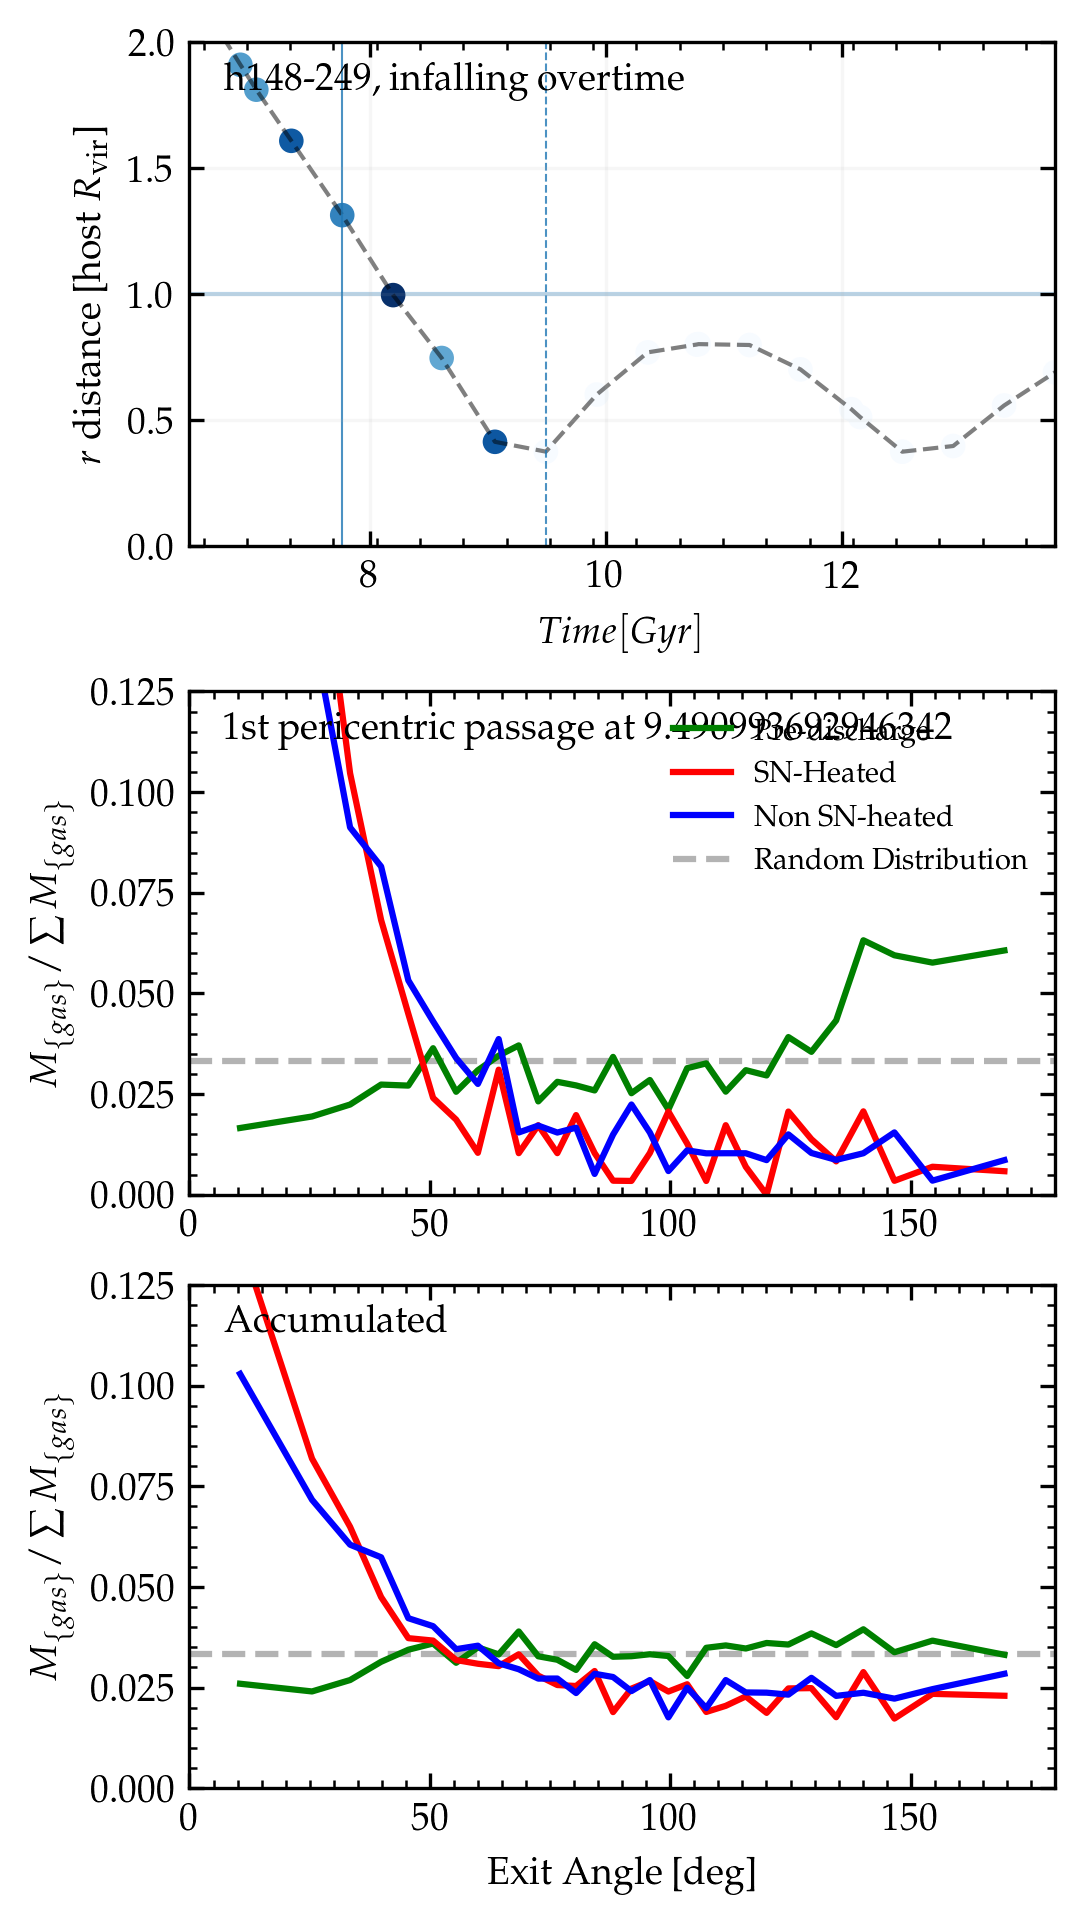

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_251 <
> Returning <tracked_particle> dataset <
Loaded: h148_251


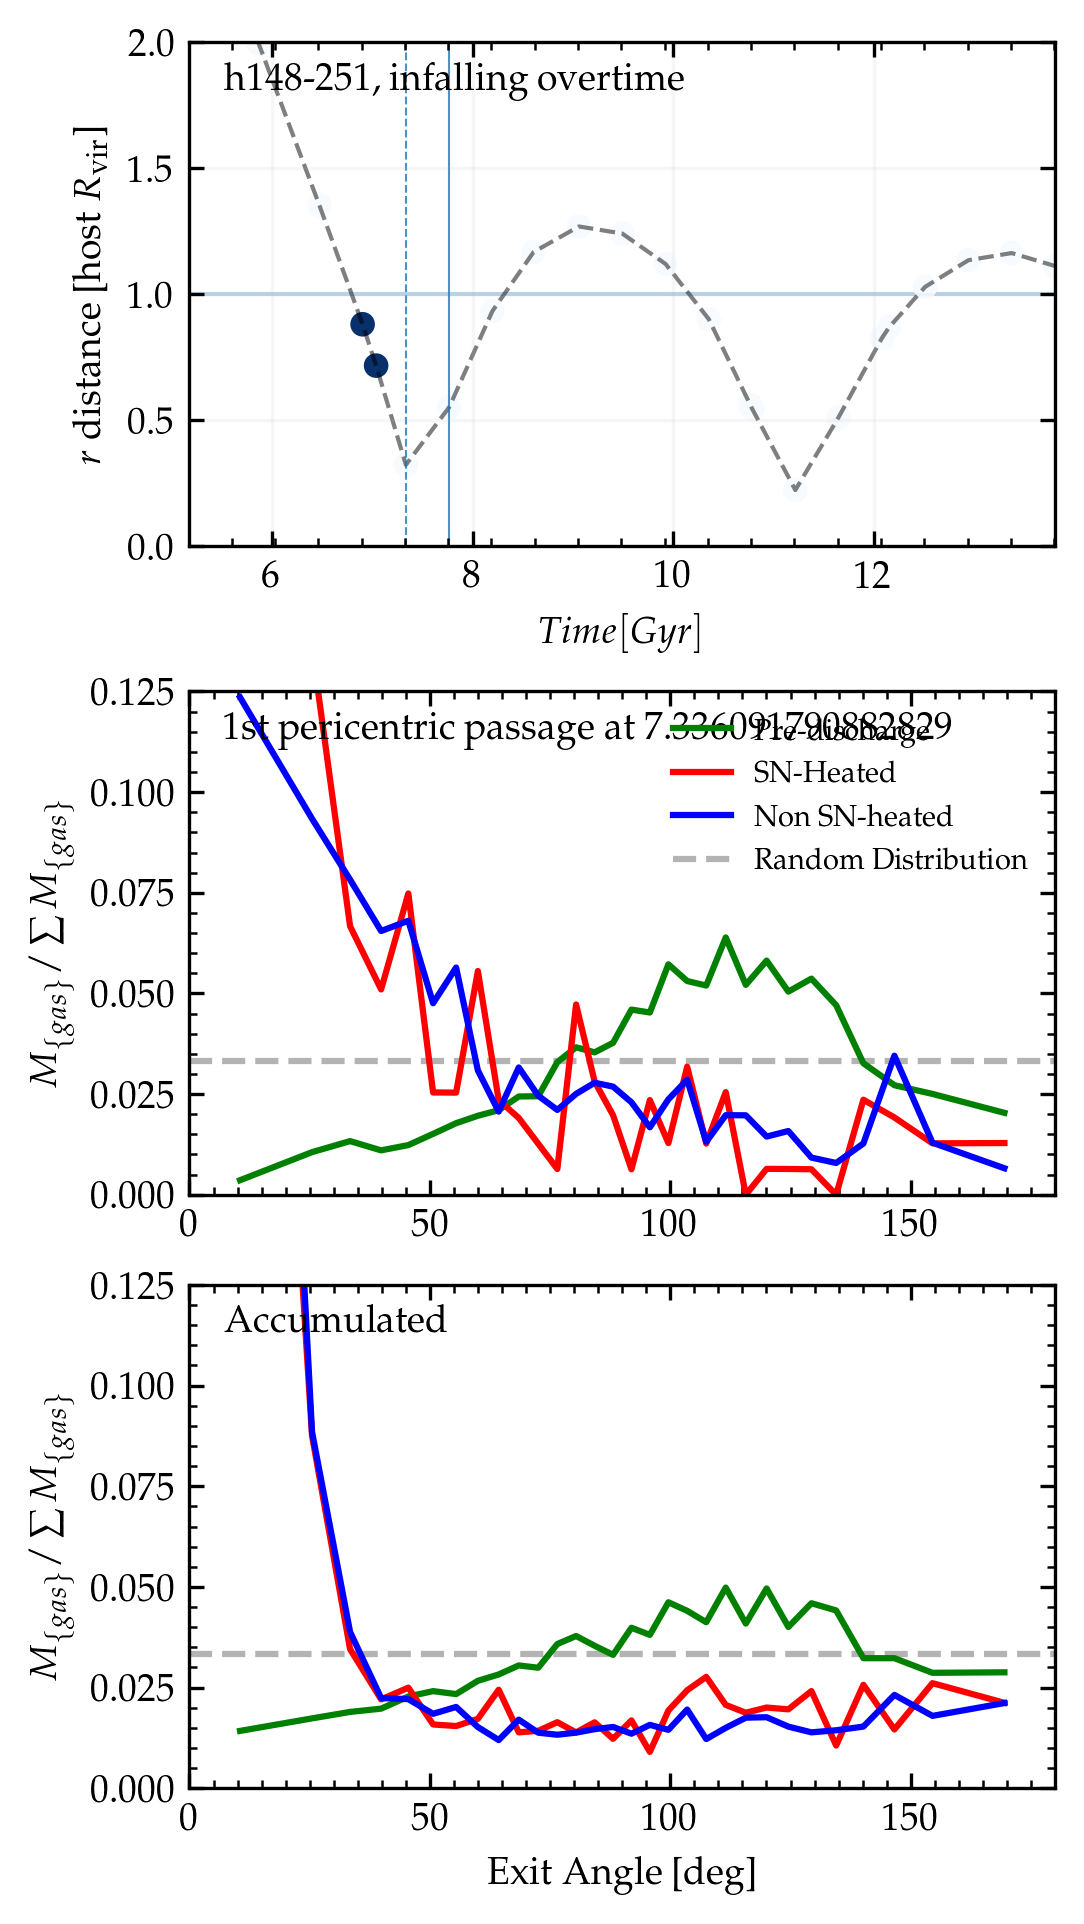

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_27 <
> Returning <tracked_particle> dataset <
Loaded: h148_27


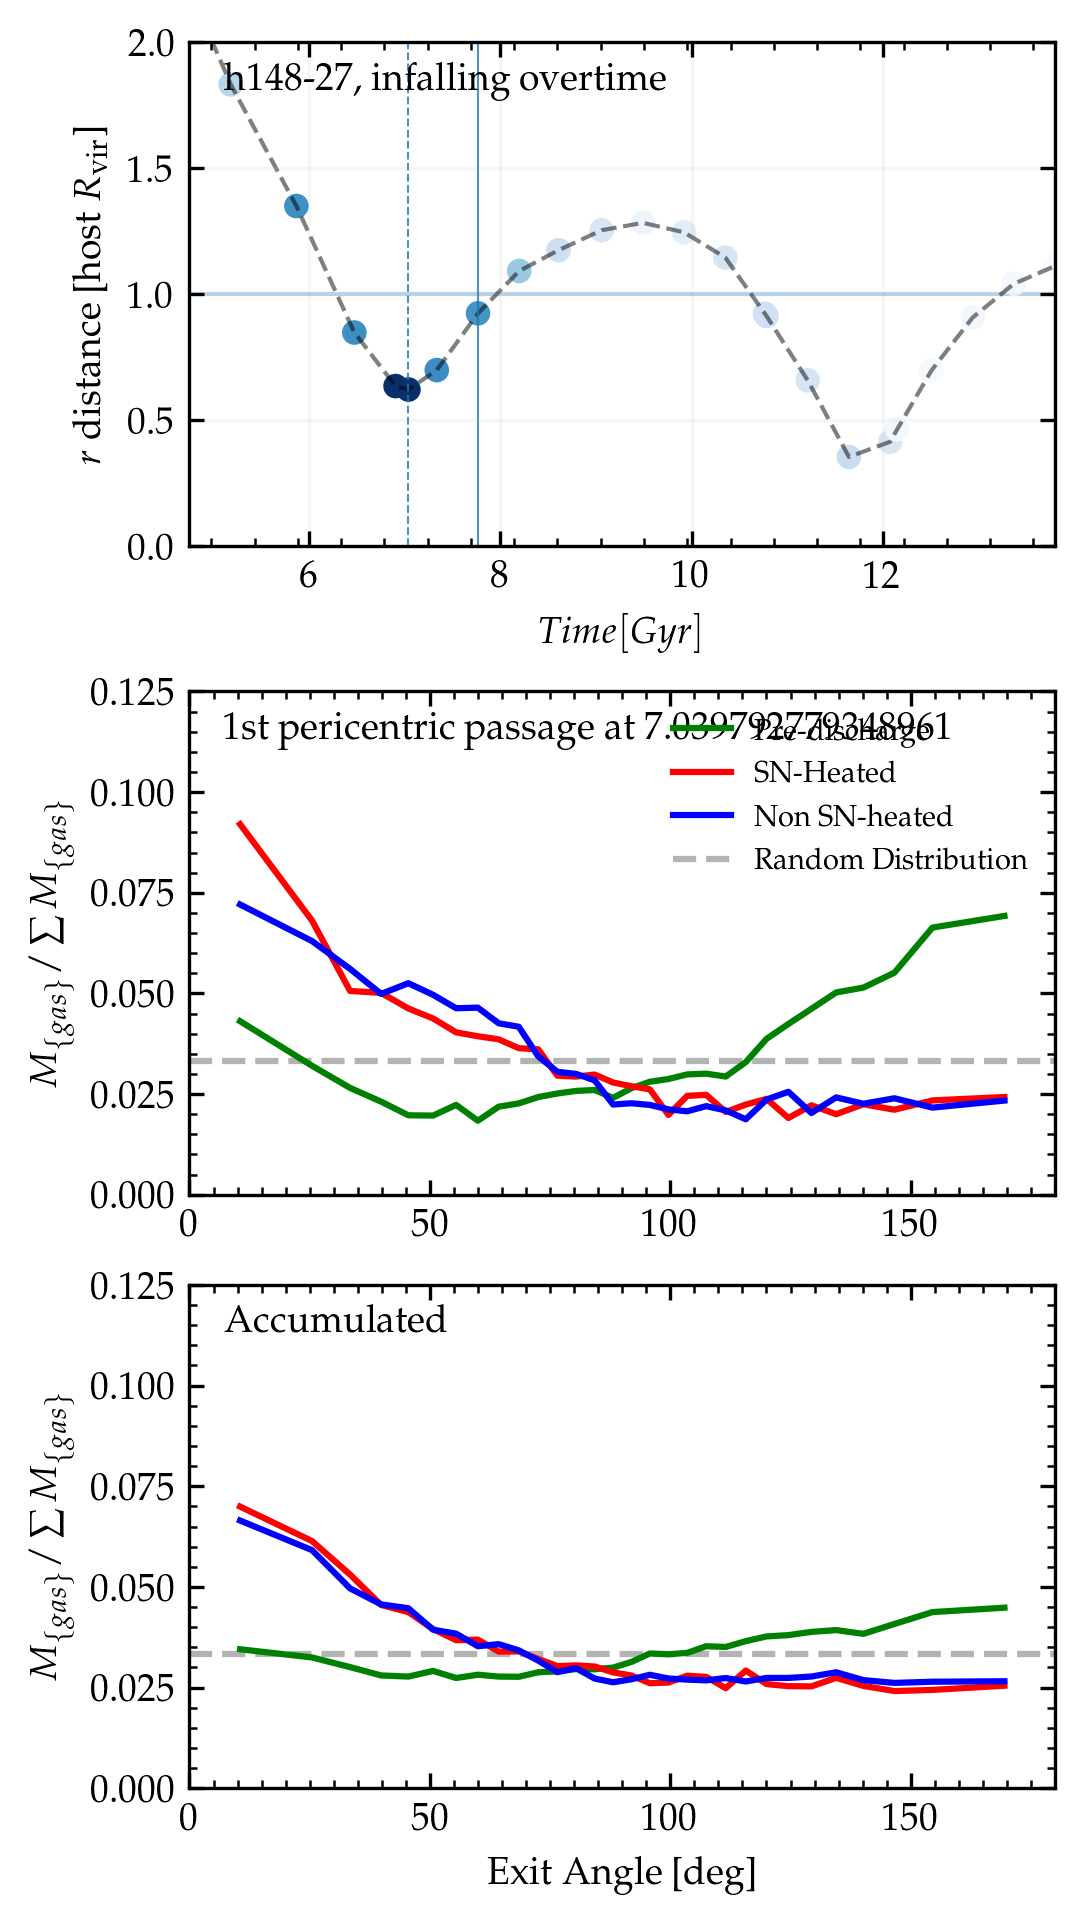

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_282 <
> Returning <tracked_particle> dataset <
Loaded: h148_282


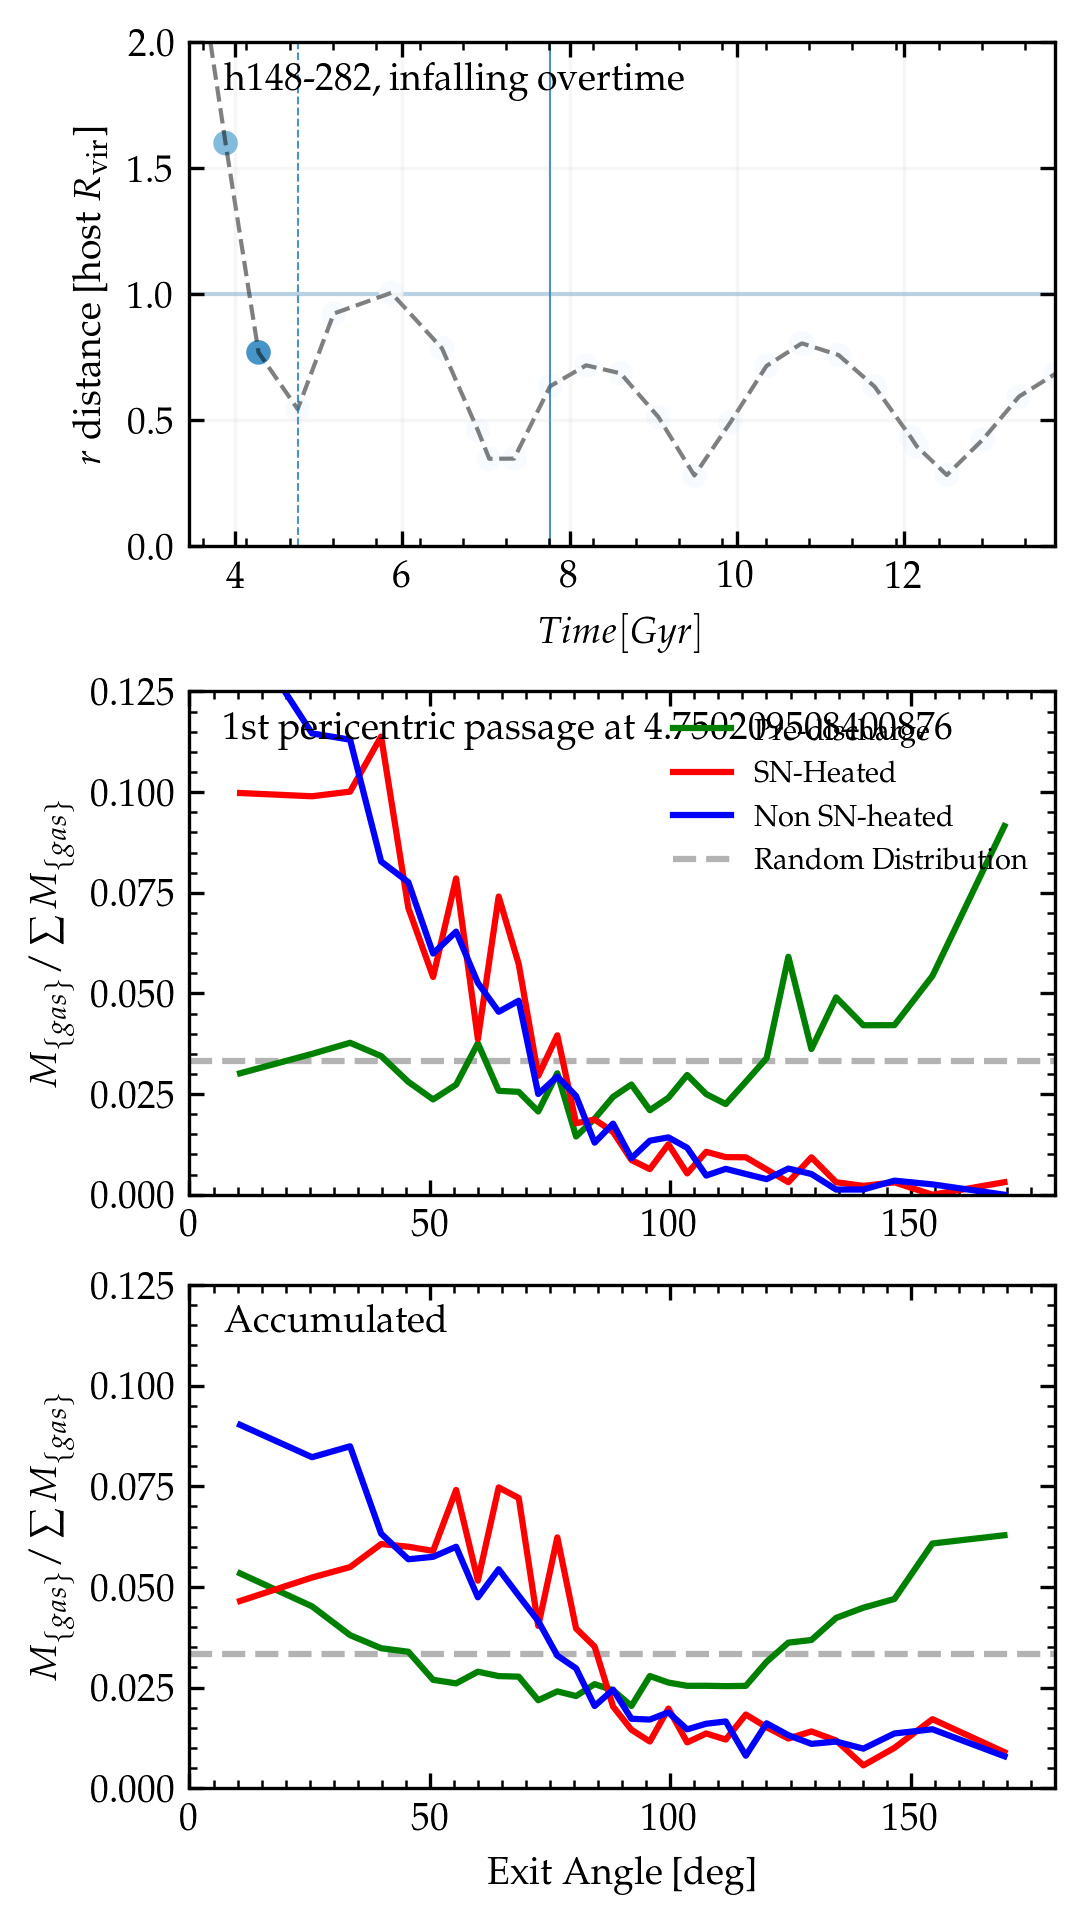

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_3 <
> Returning <tracked_particle> dataset <
Loaded: h148_3


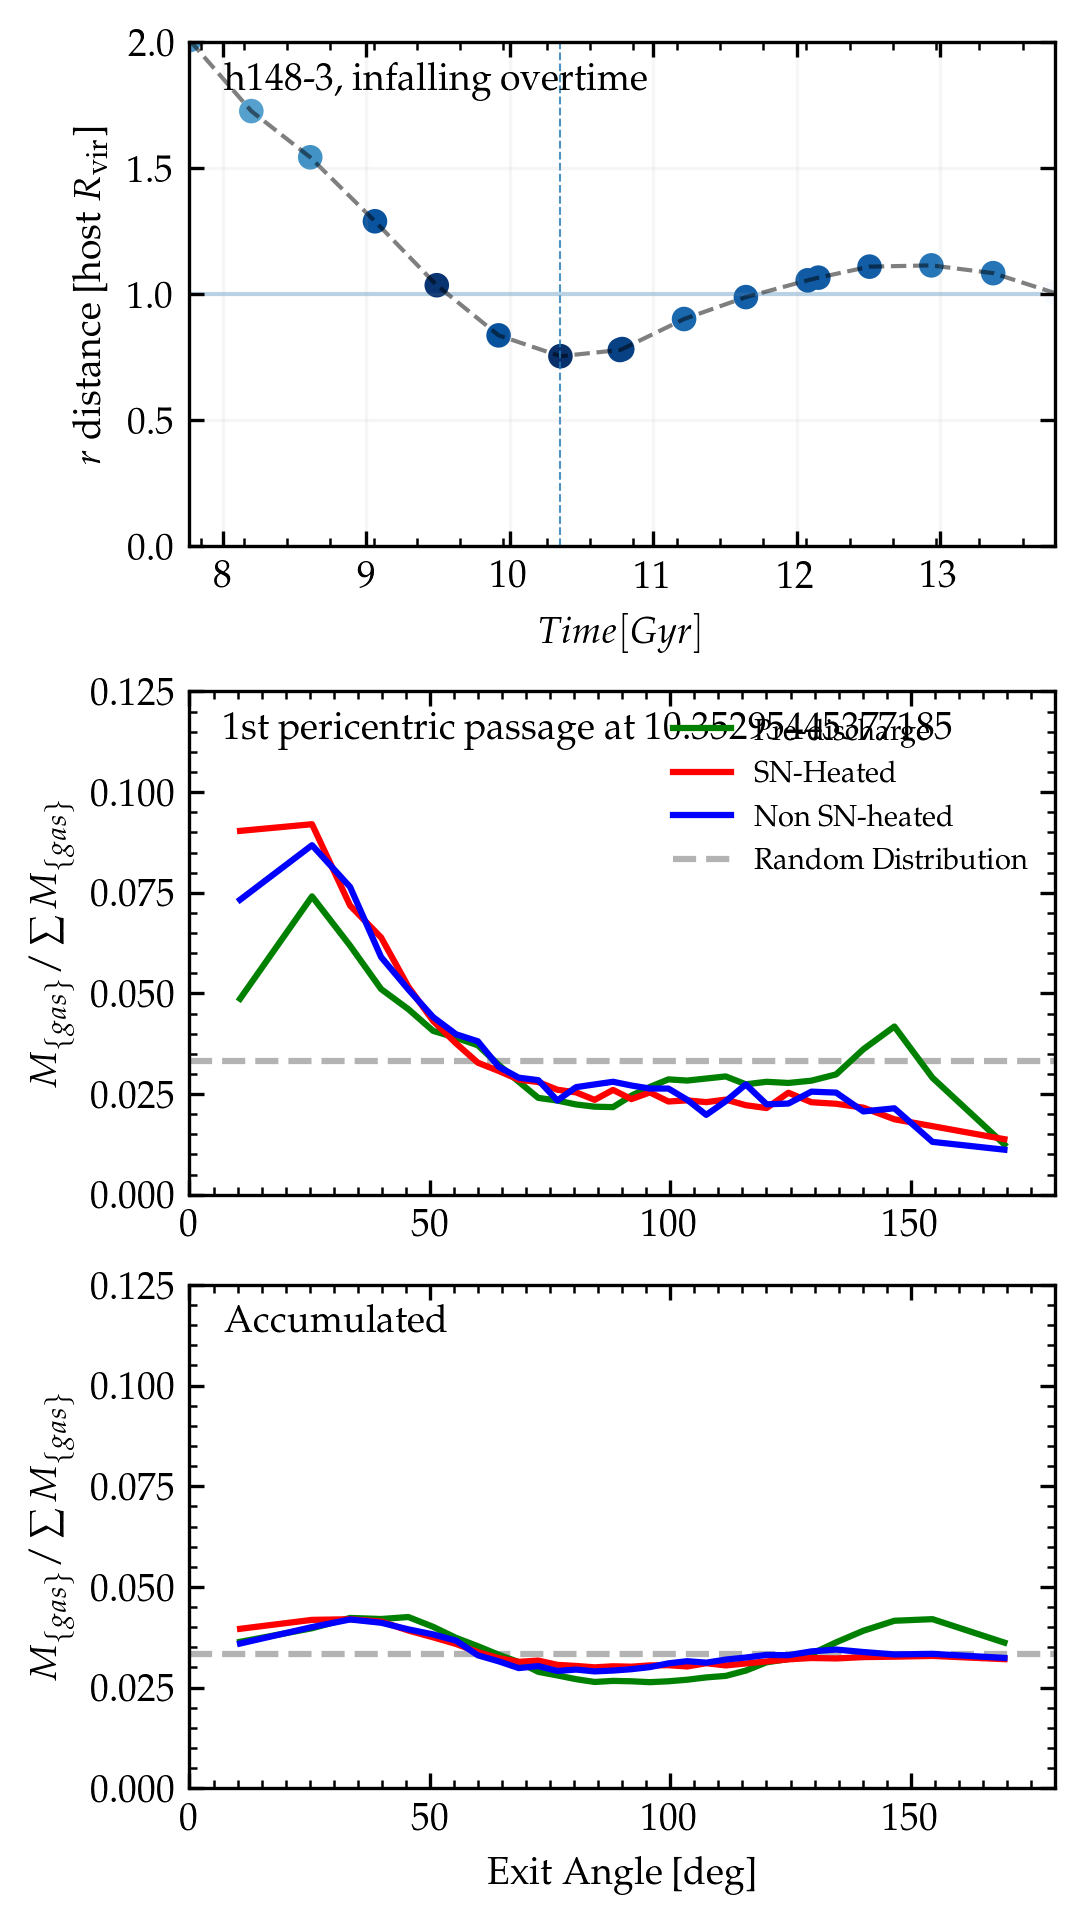

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_34 <
> Returning <tracked_particle> dataset <
Loaded: h148_34


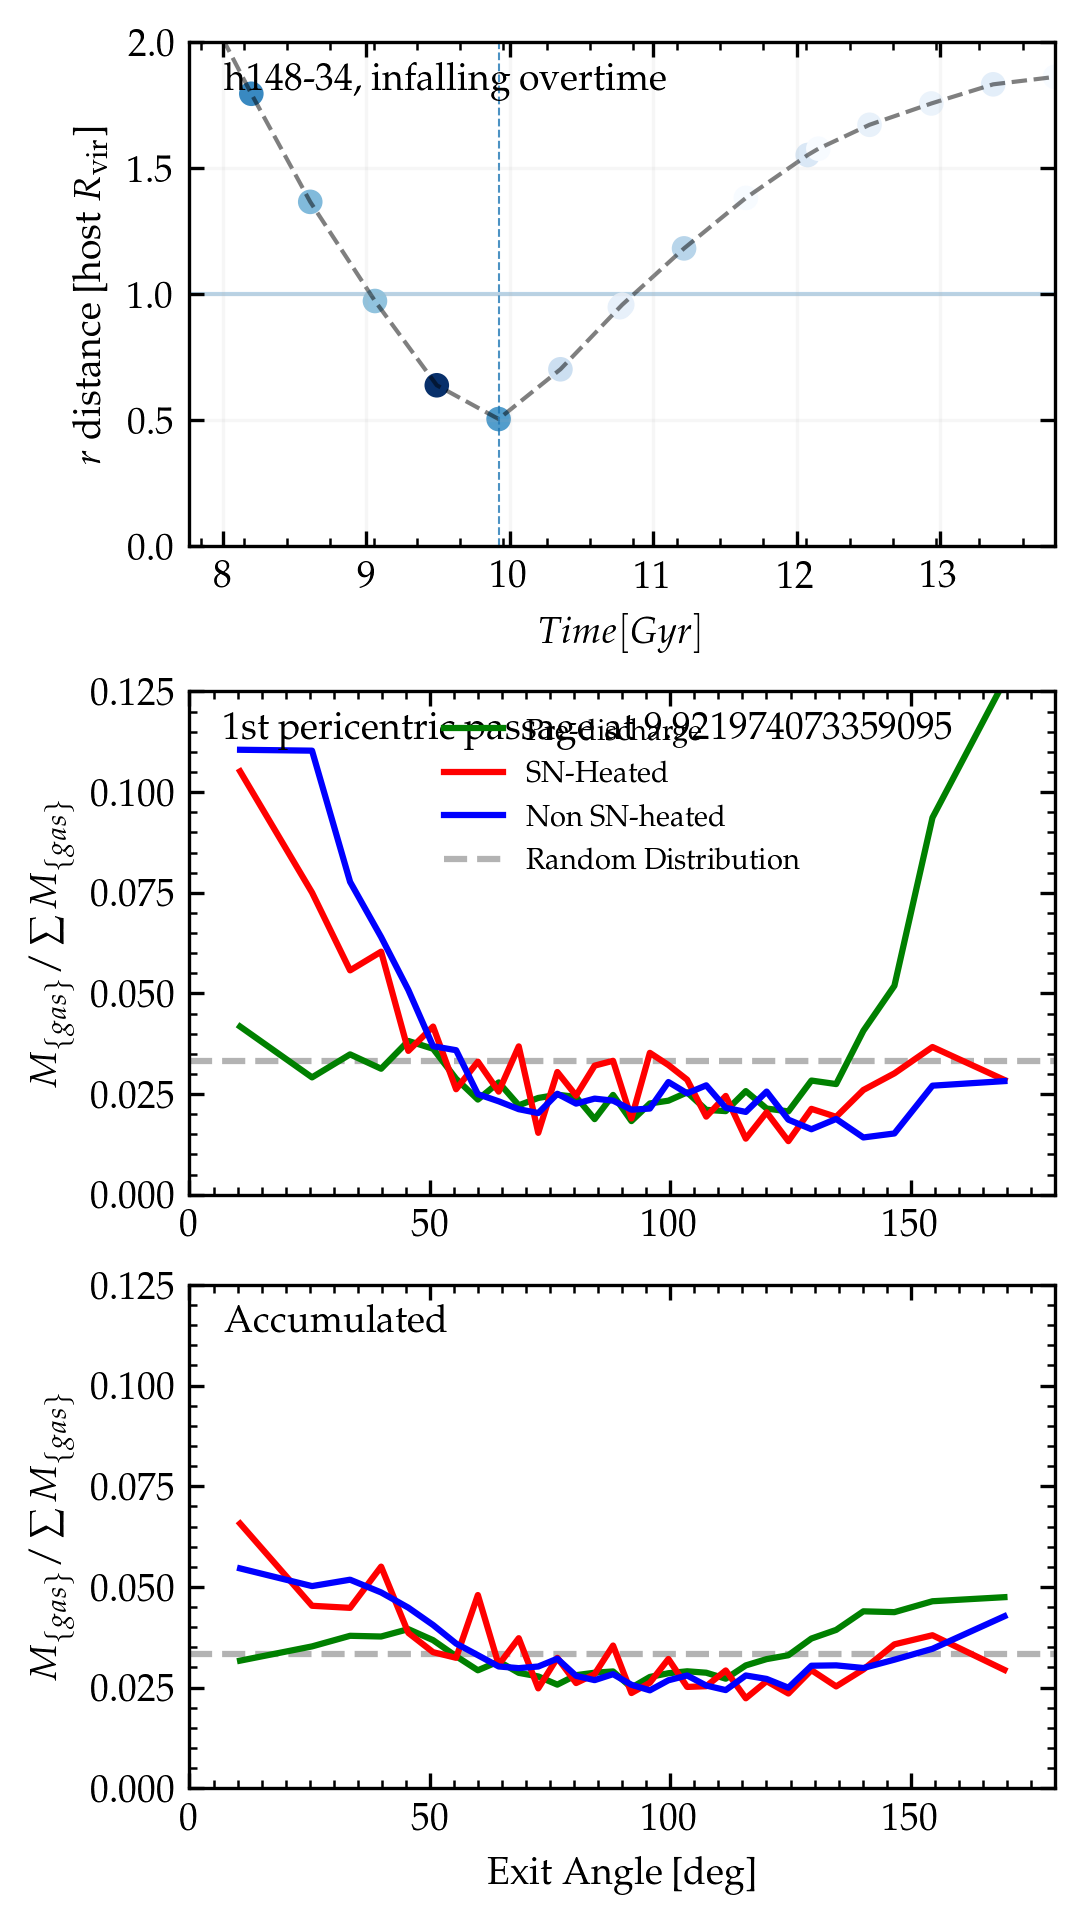

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_38 <
> Returning <tracked_particle> dataset <
Loaded: h148_38


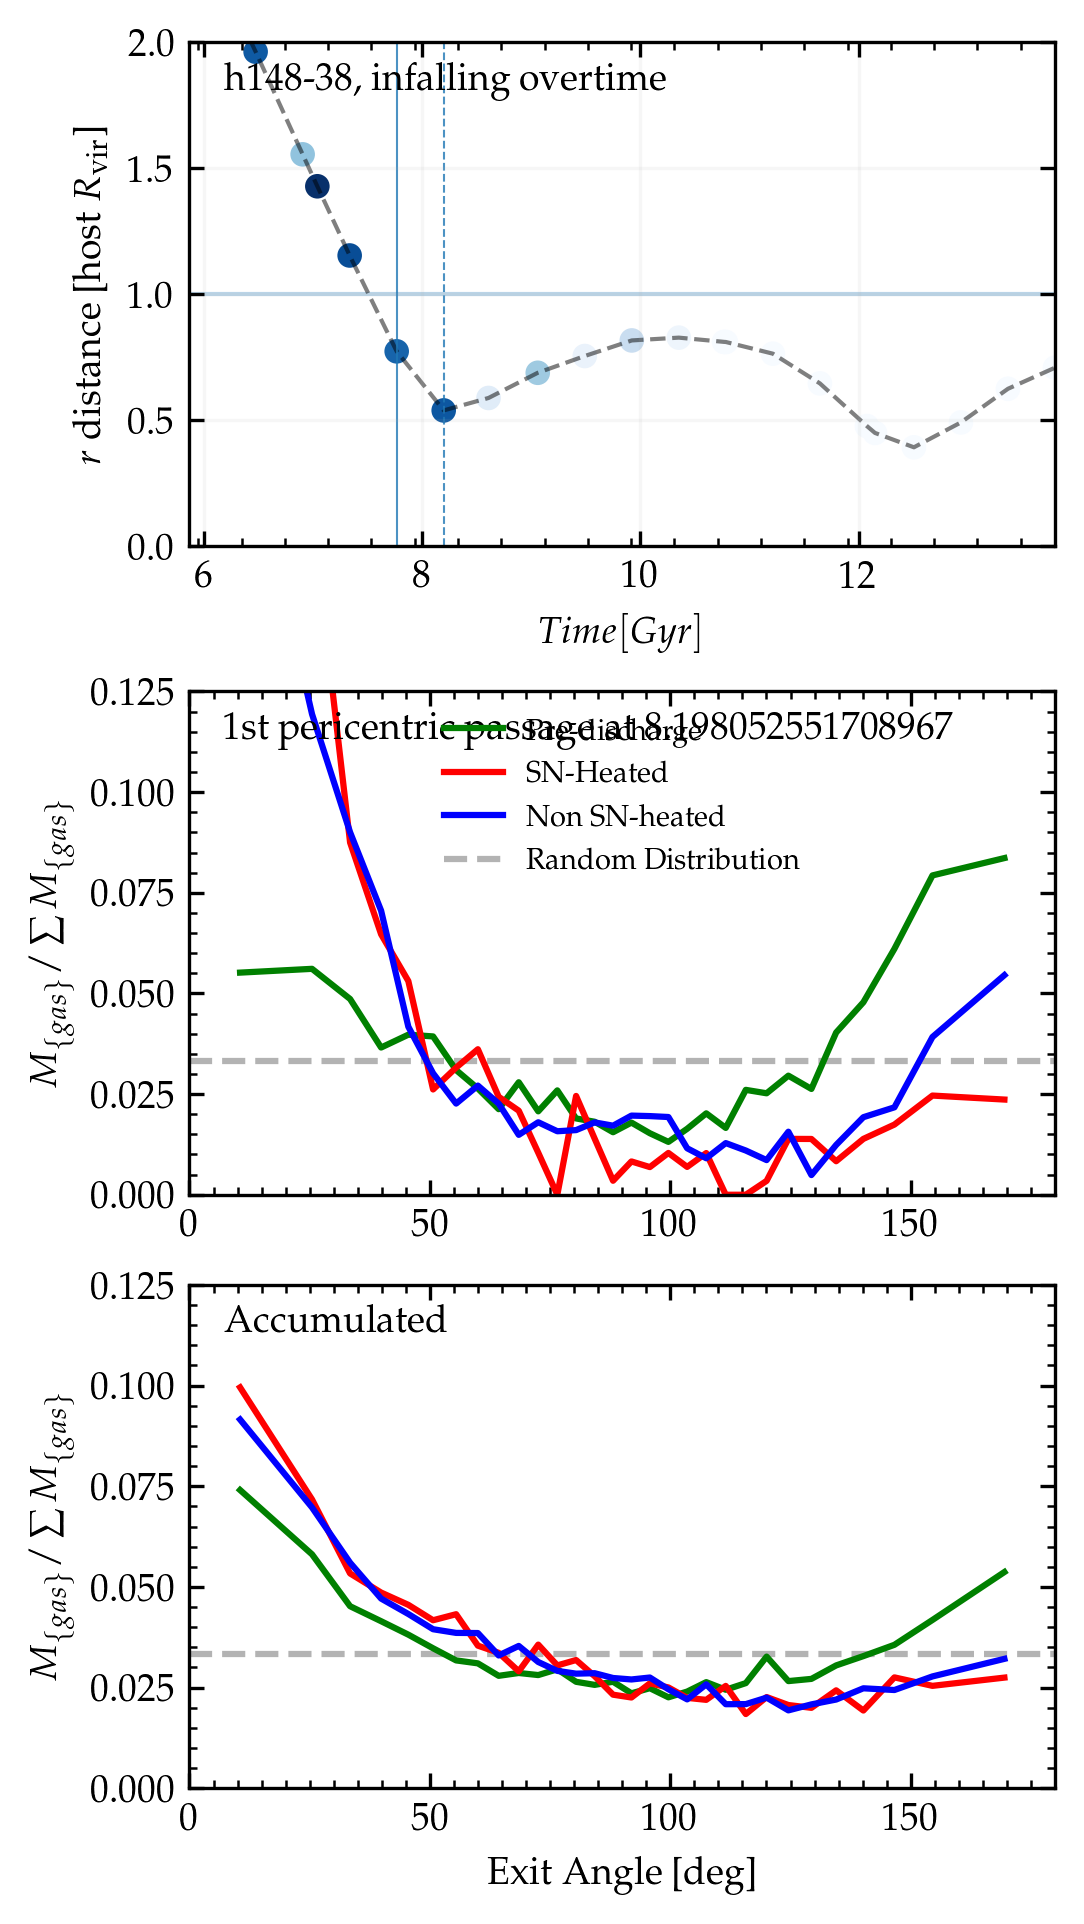

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_4 <
> Returning <tracked_particle> dataset <
Loaded: h148_4


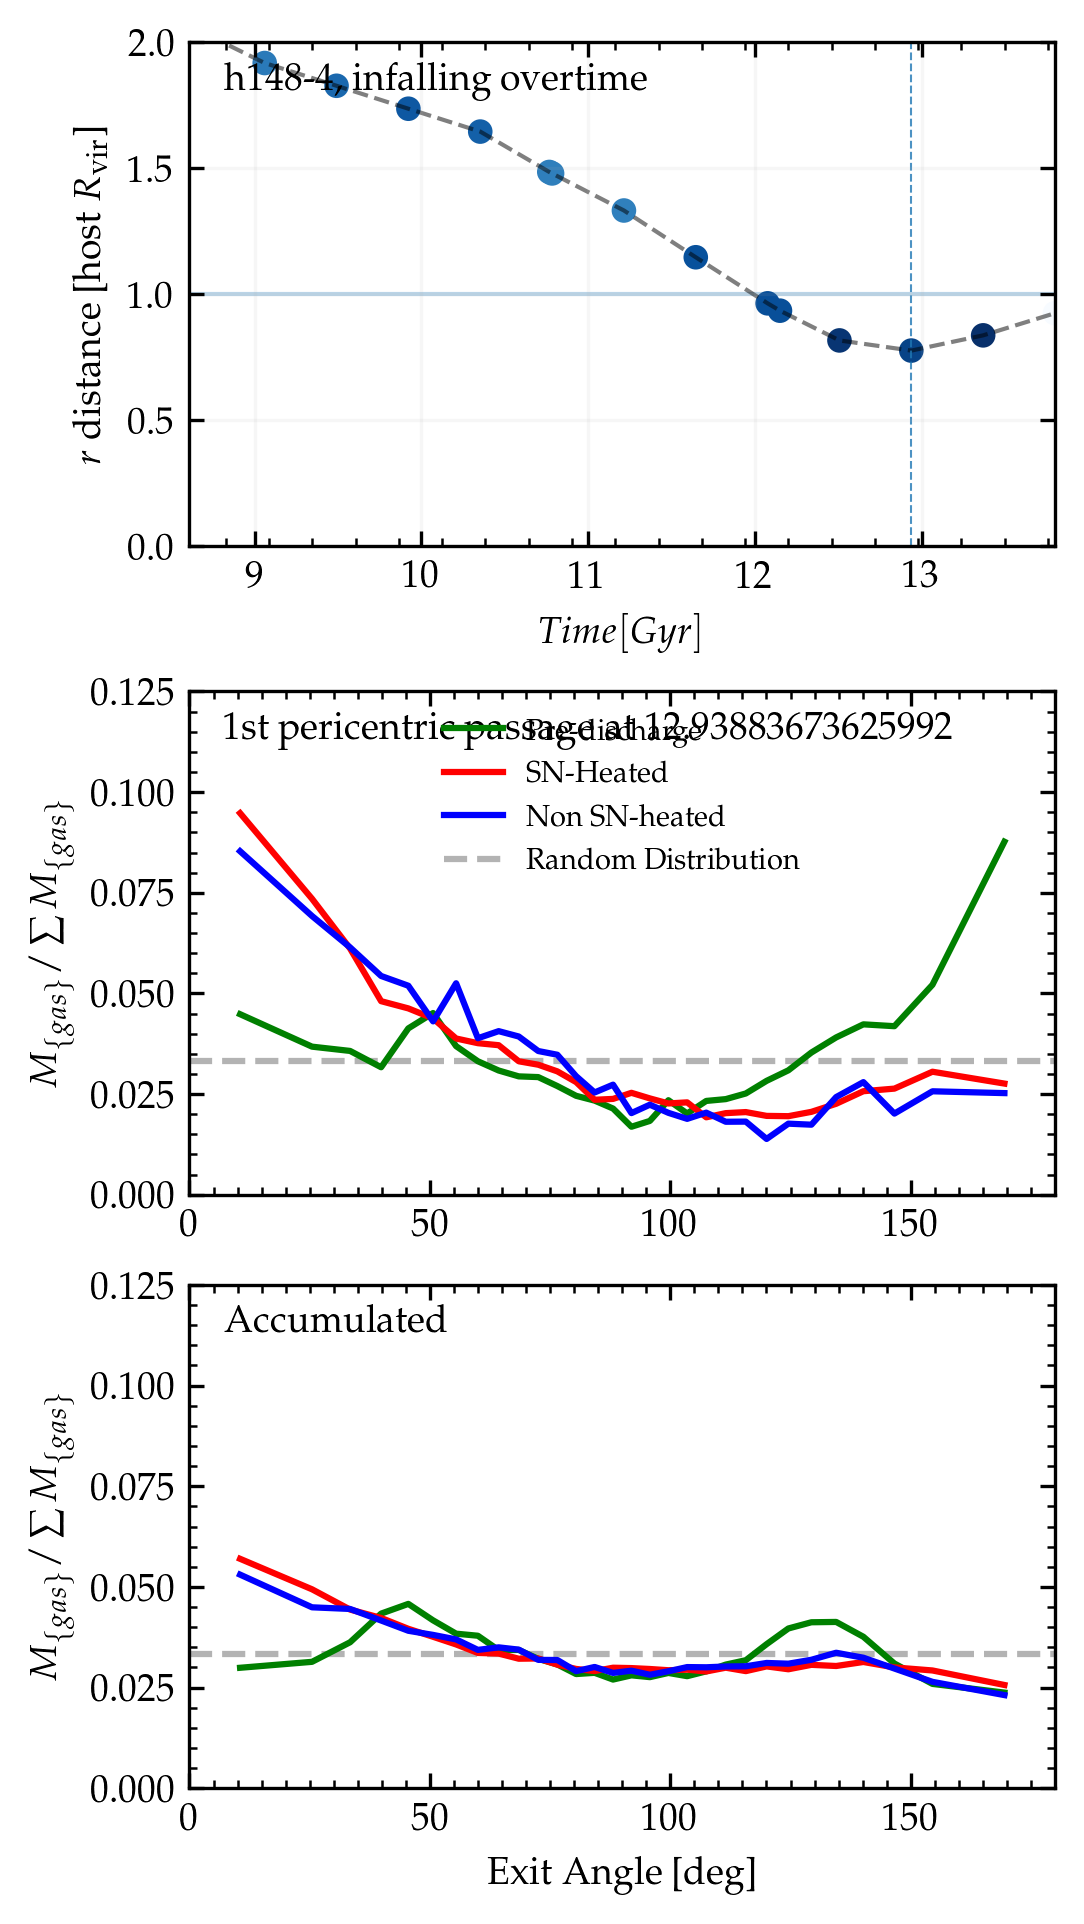

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_55 <
> Returning <tracked_particle> dataset <
Loaded: h148_55


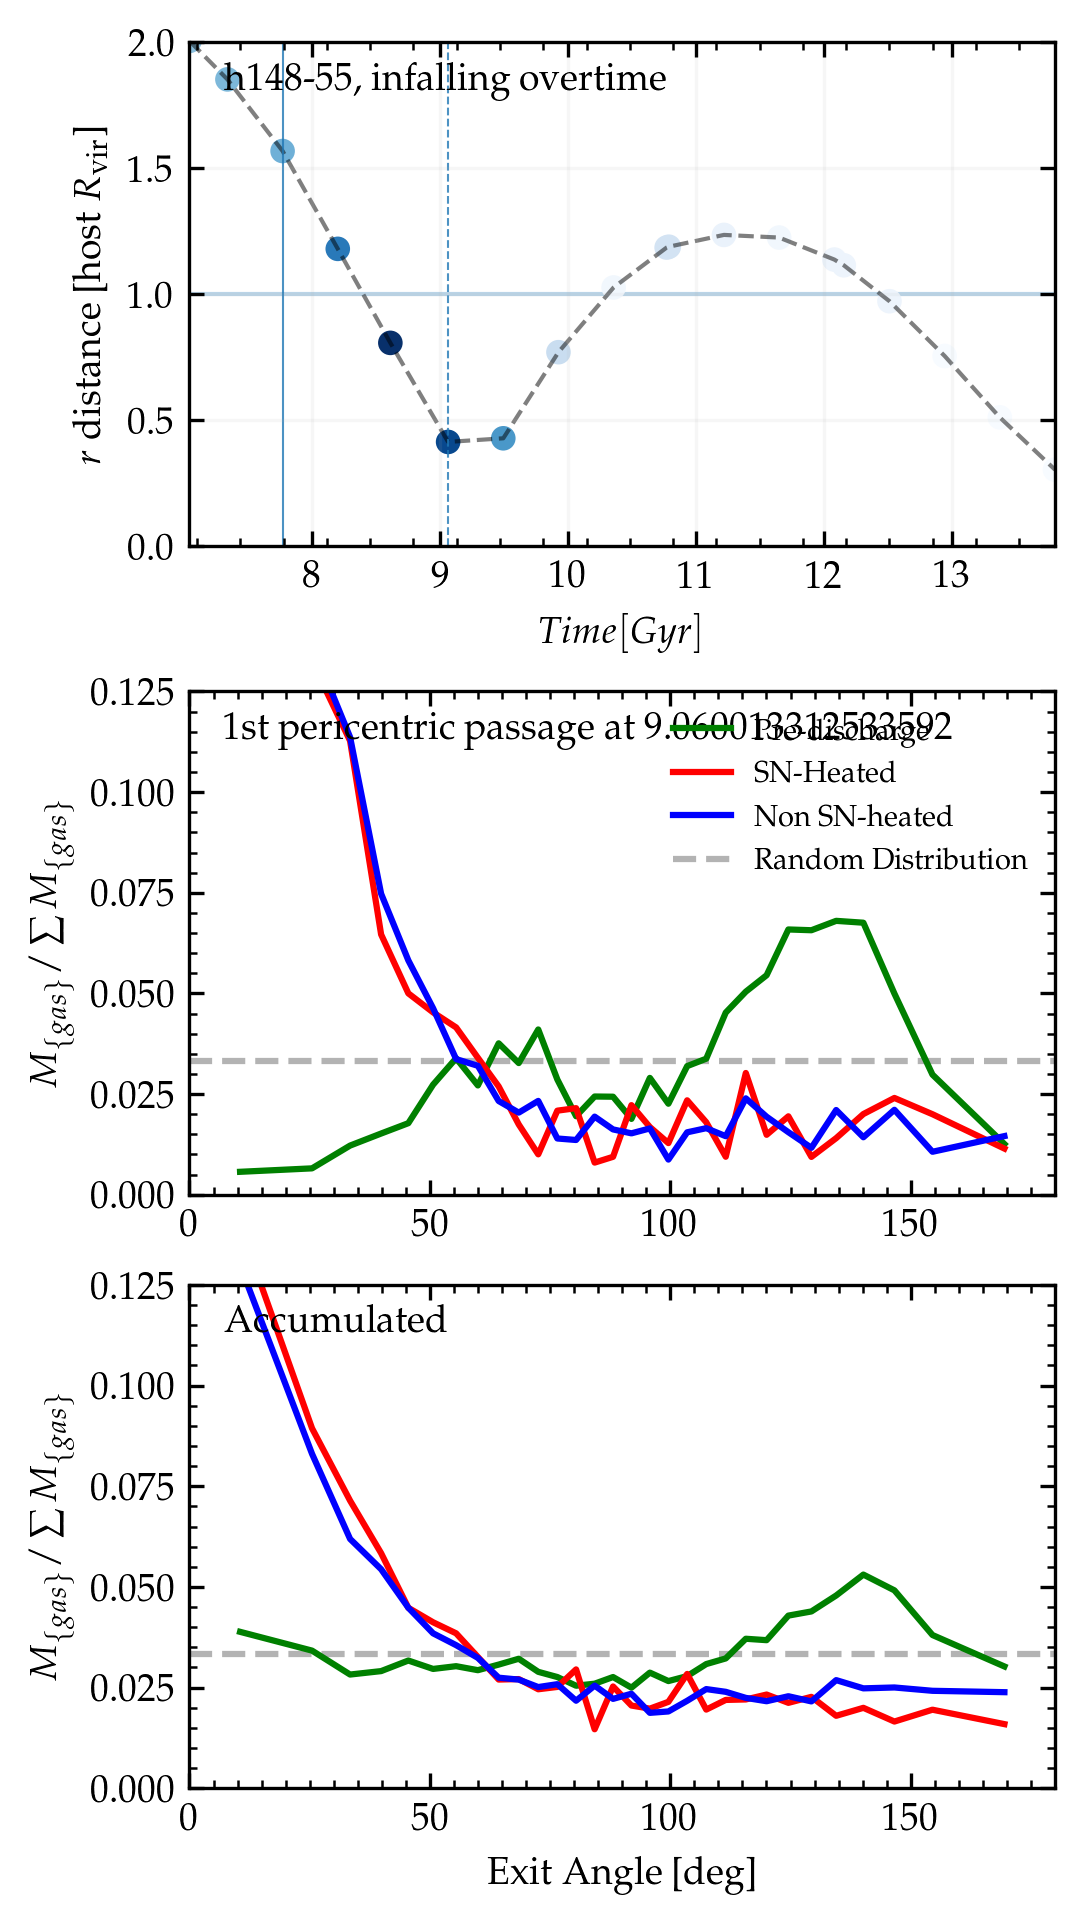

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_6 <
> Returning <tracked_particle> dataset <
Loaded: h148_6


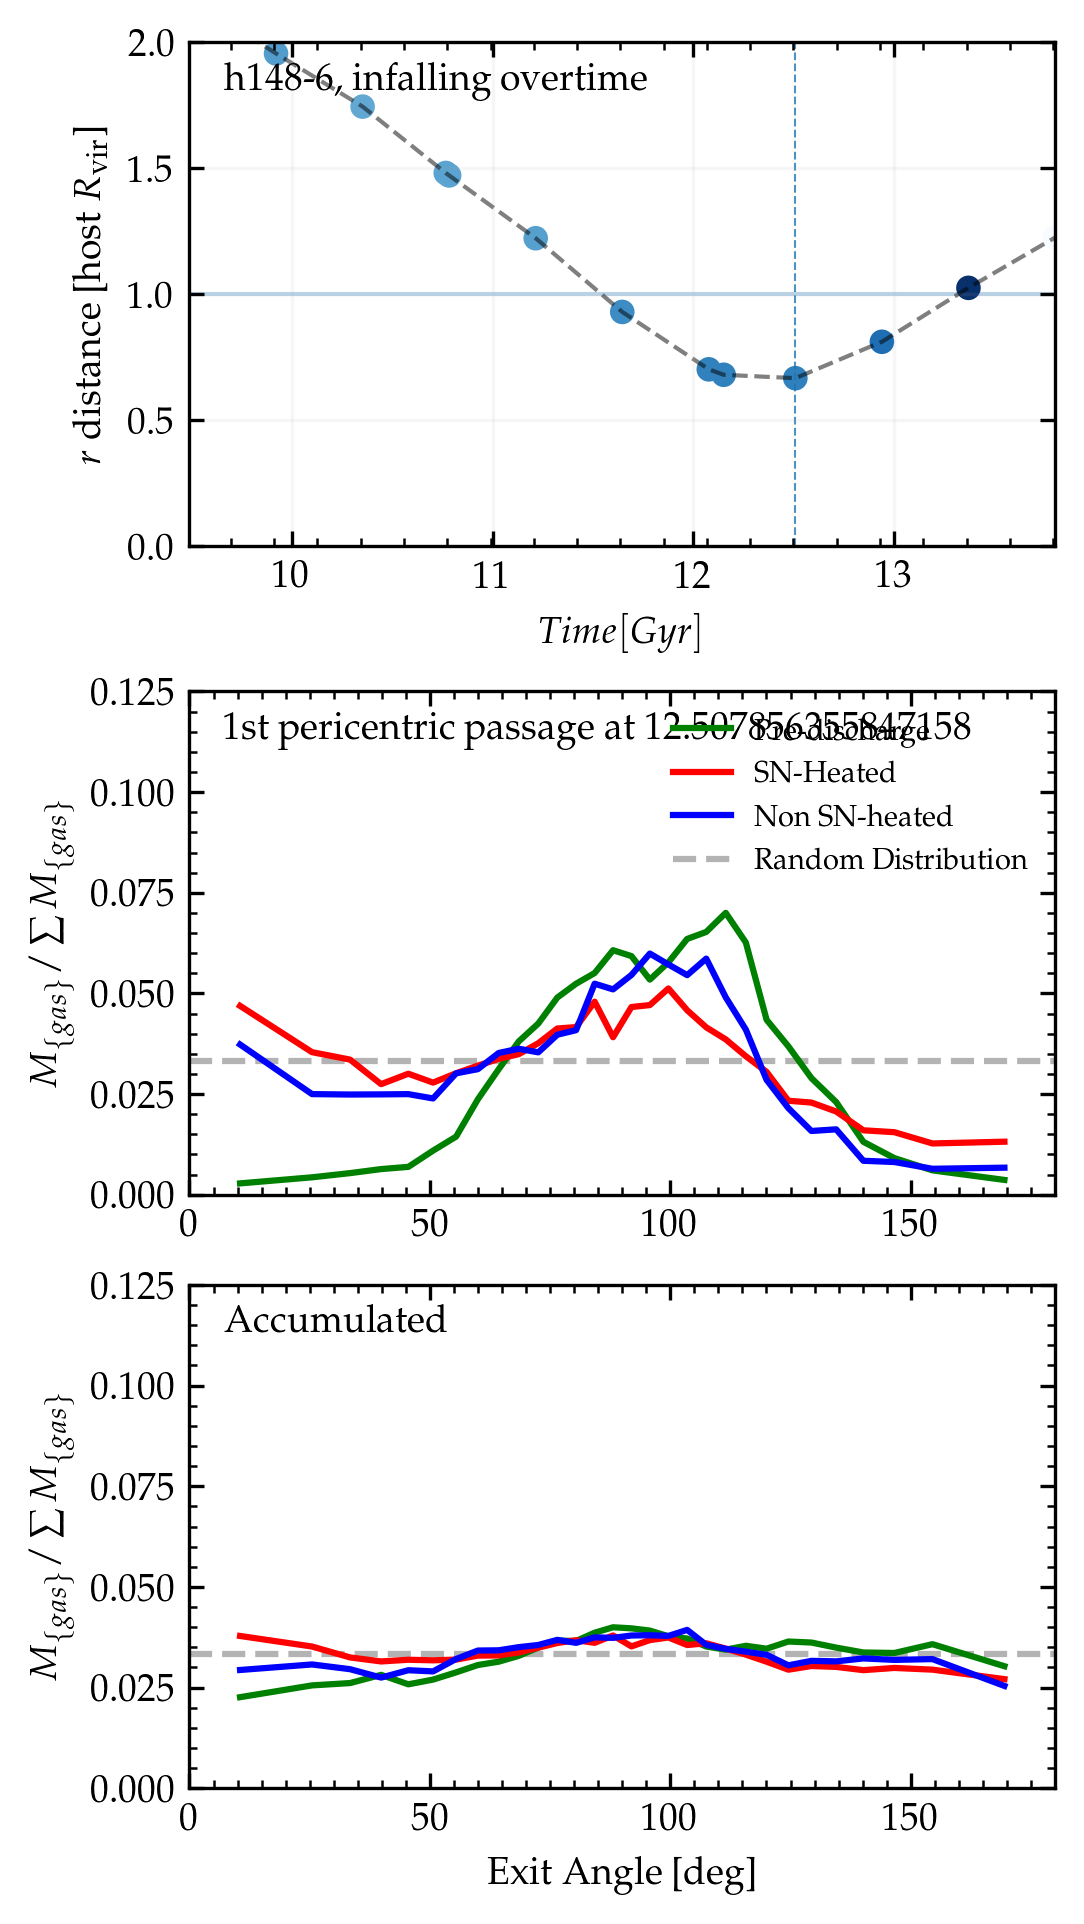

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_65 <
> Returning <tracked_particle> dataset <
Loaded: h148_65


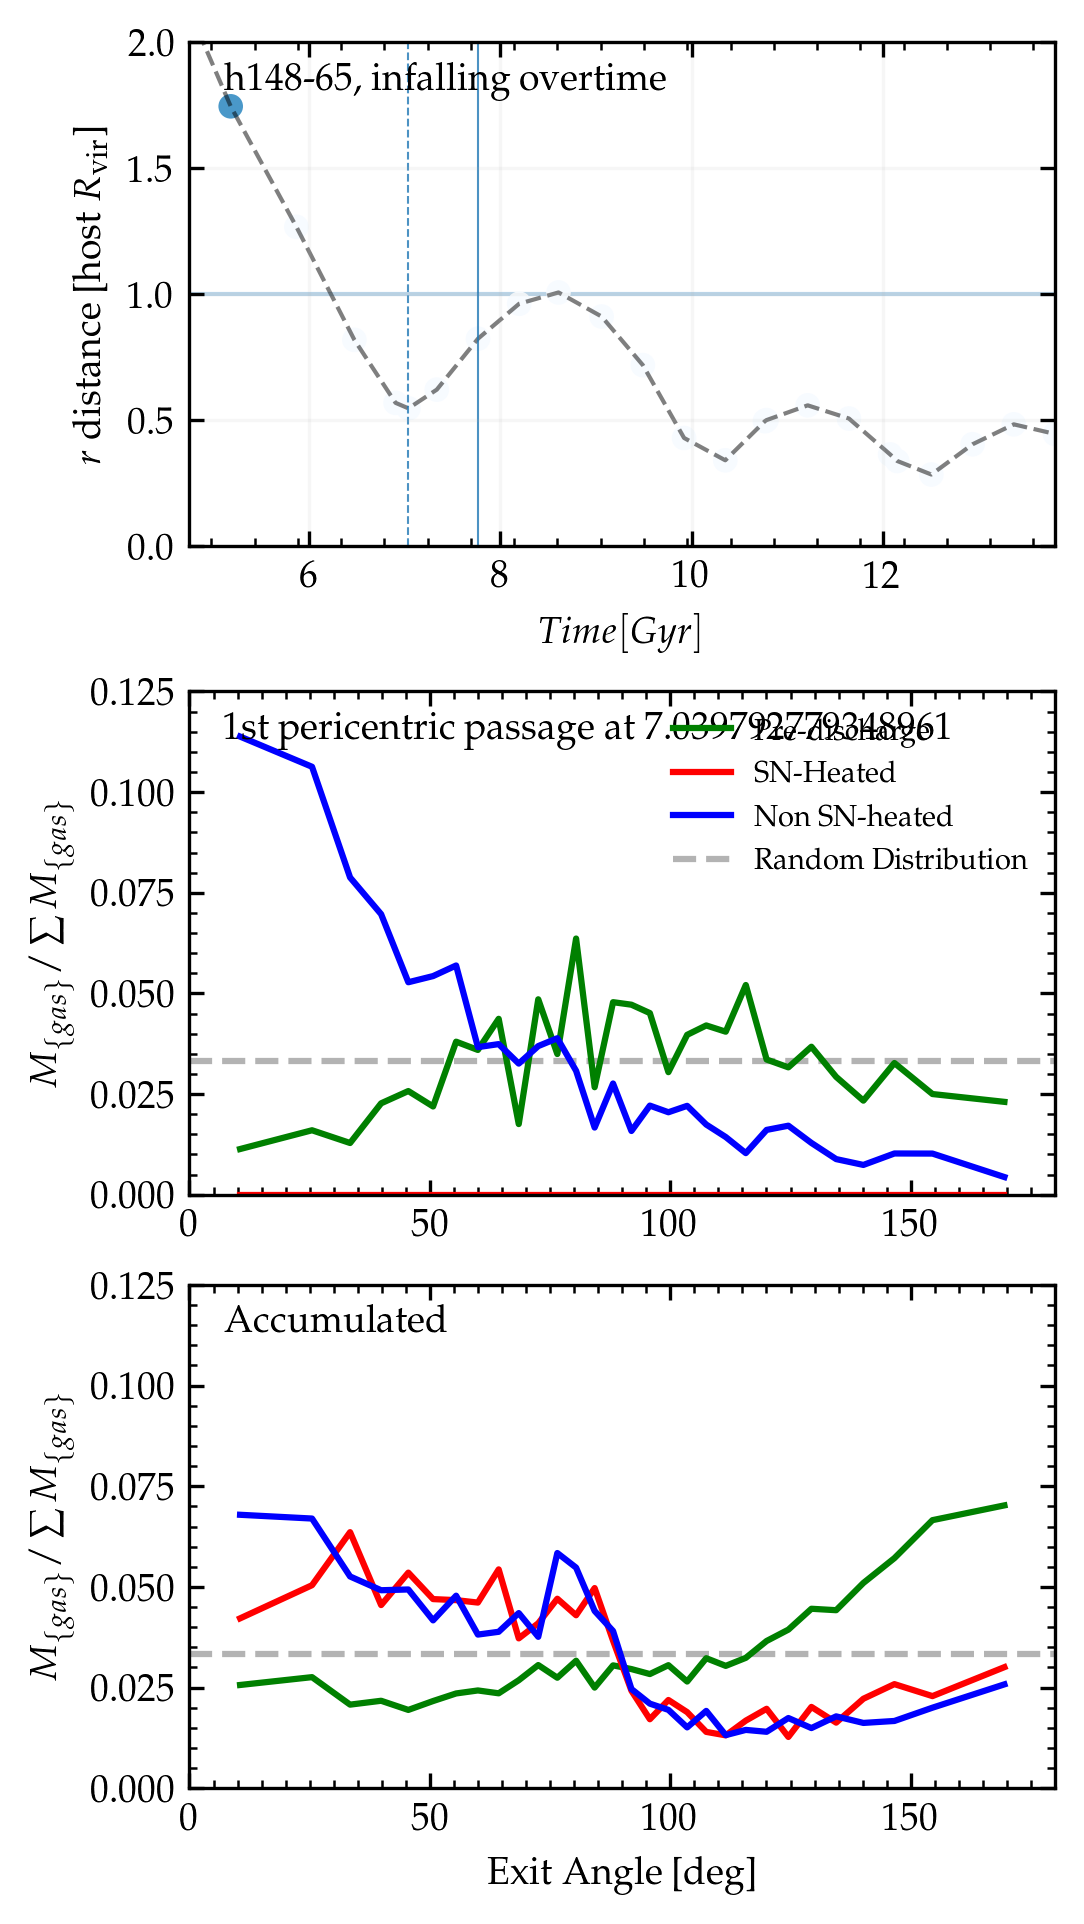

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_14 <
> Returning <tracked_particle> dataset <
Loaded: h229_14


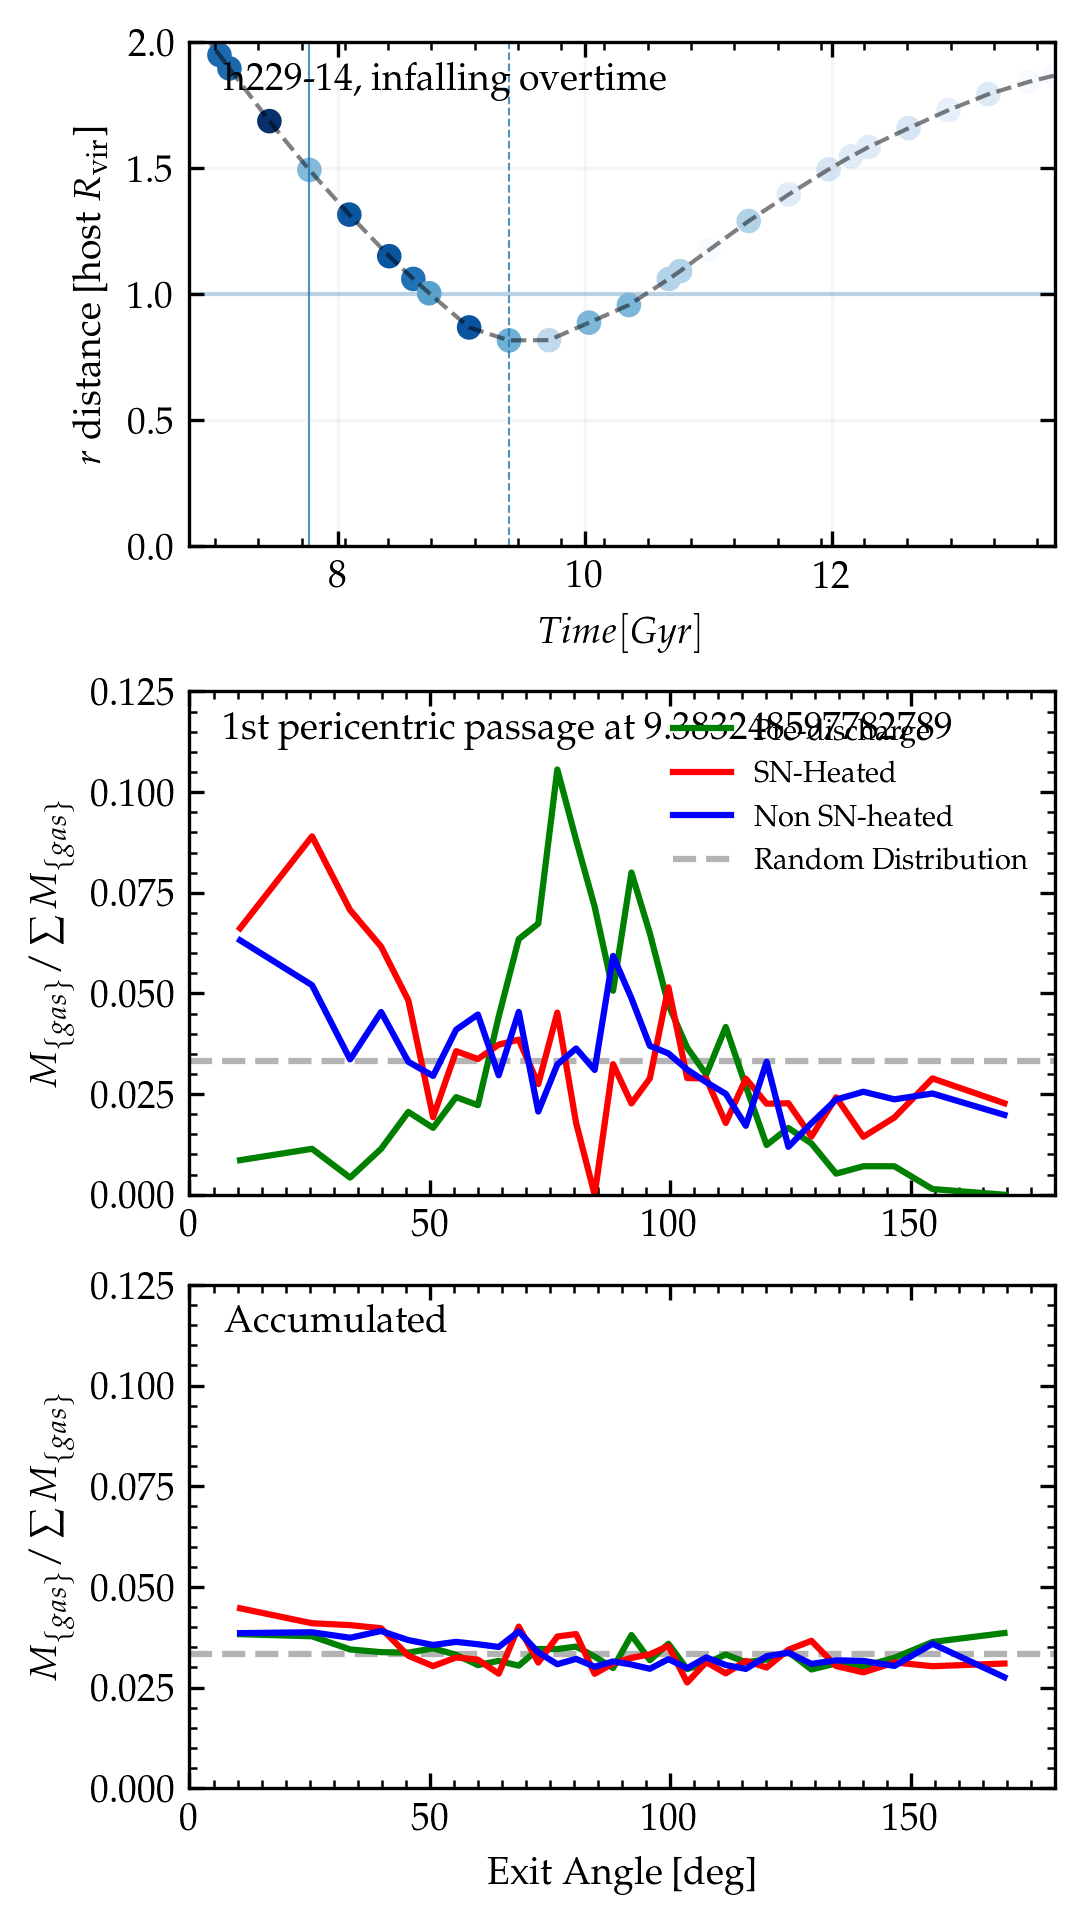

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_18 <
> Returning <tracked_particle> dataset <
Loaded: h229_18


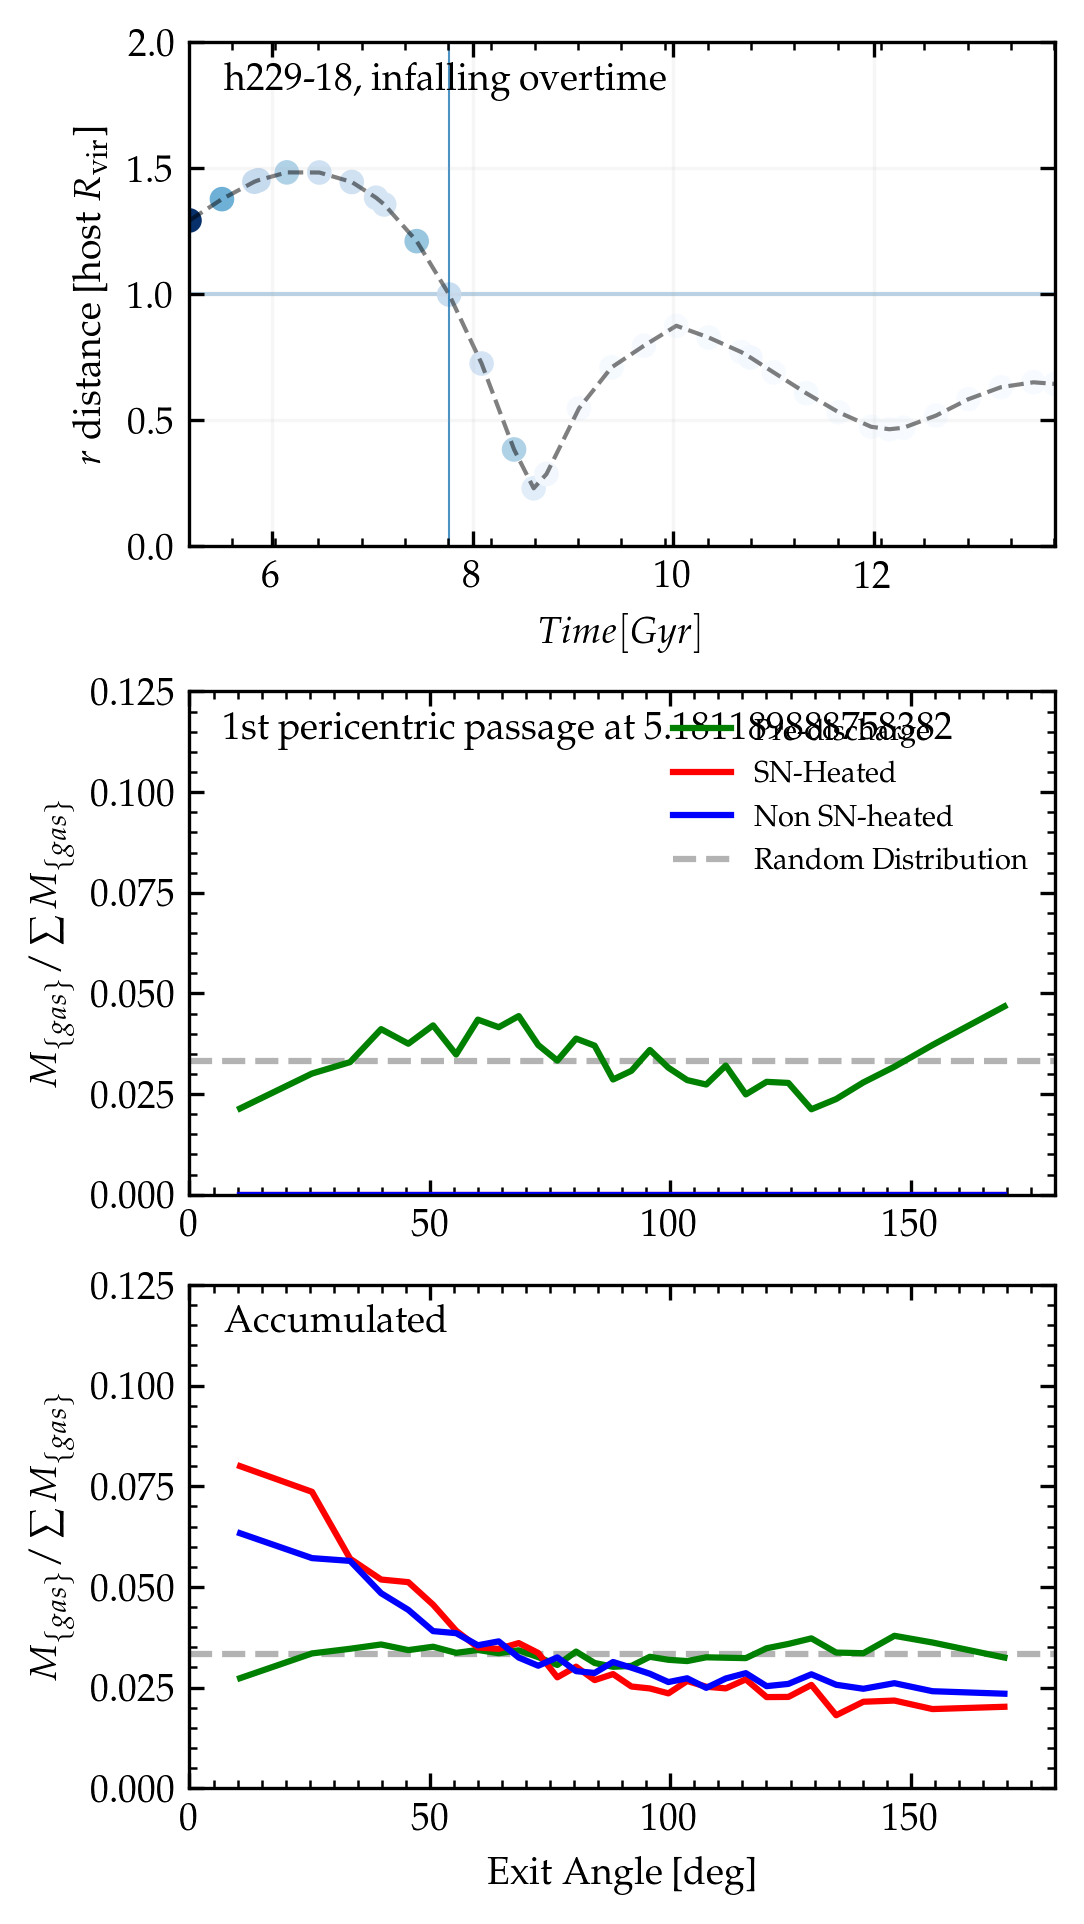

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_20 <
> Returning <tracked_particle> dataset <
Loaded: h229_20


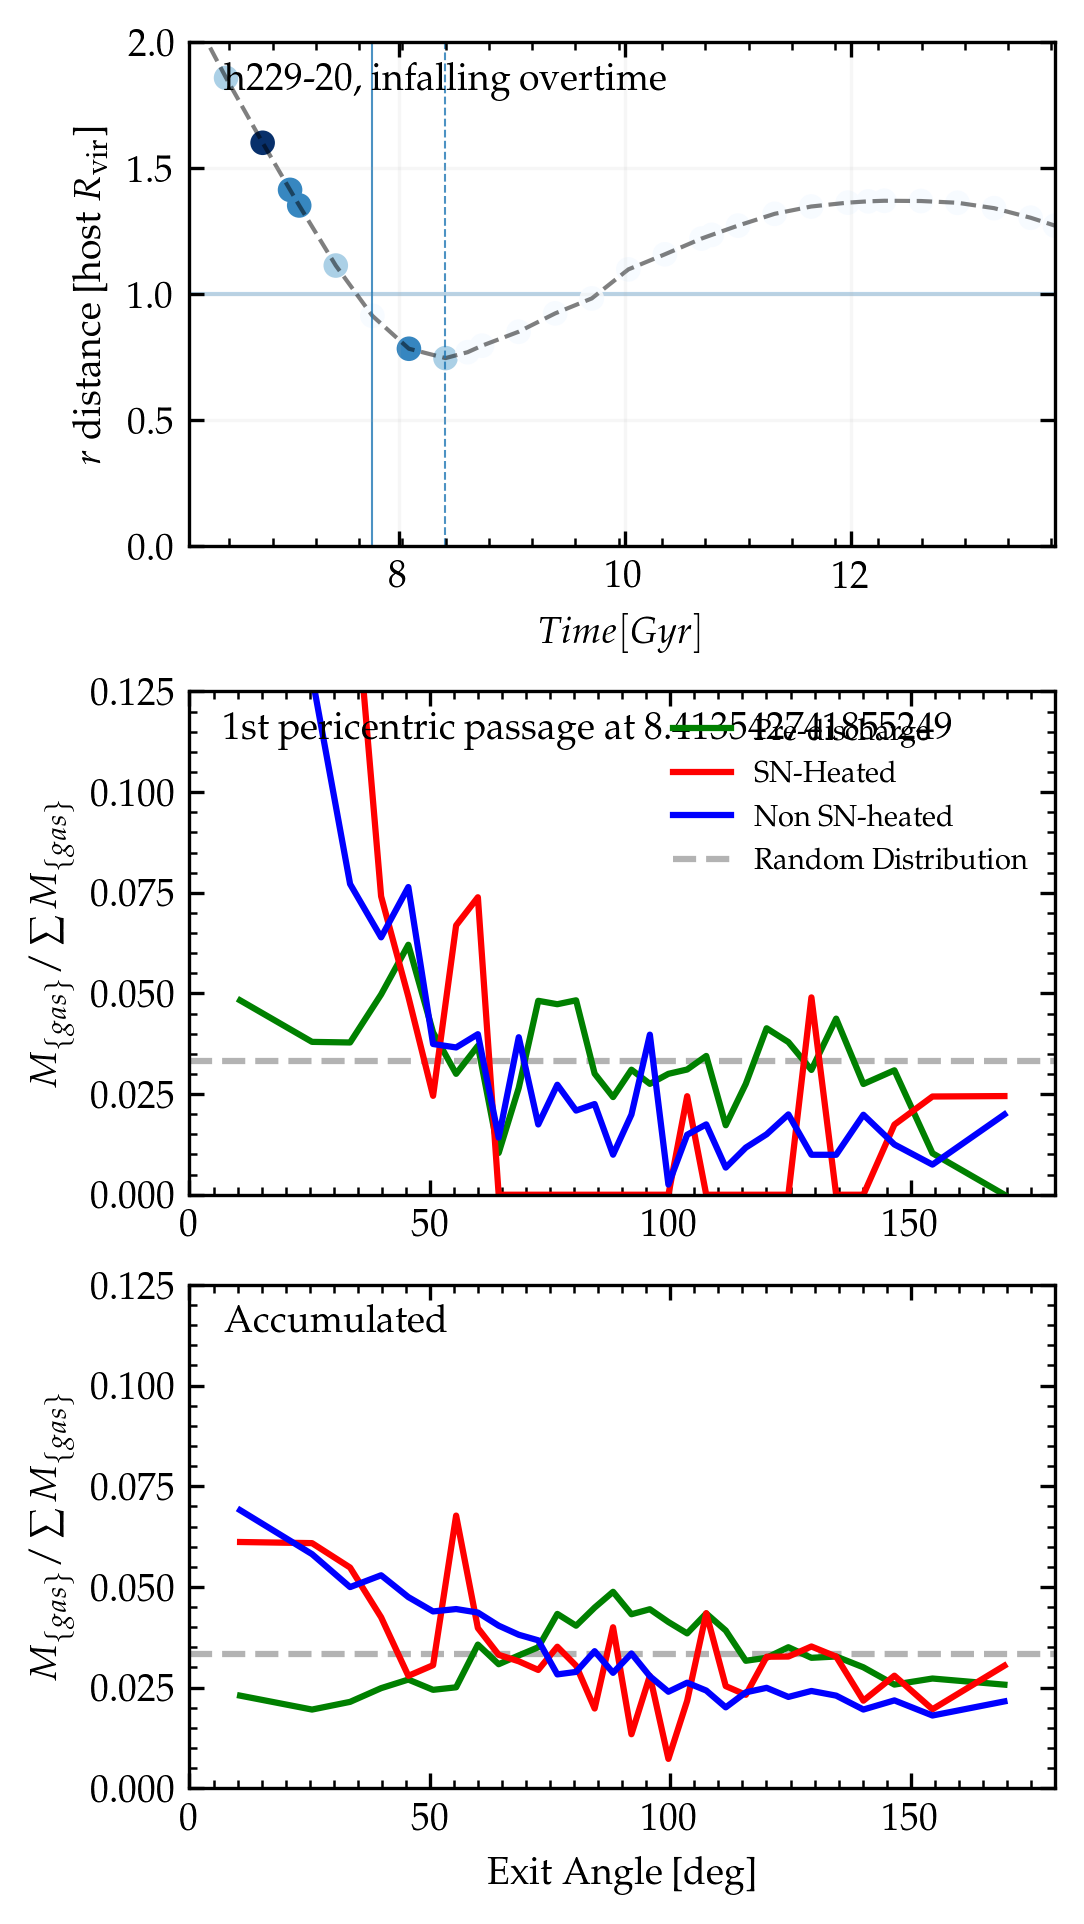

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_22 <
> Returning <tracked_particle> dataset <
Loaded: h229_22


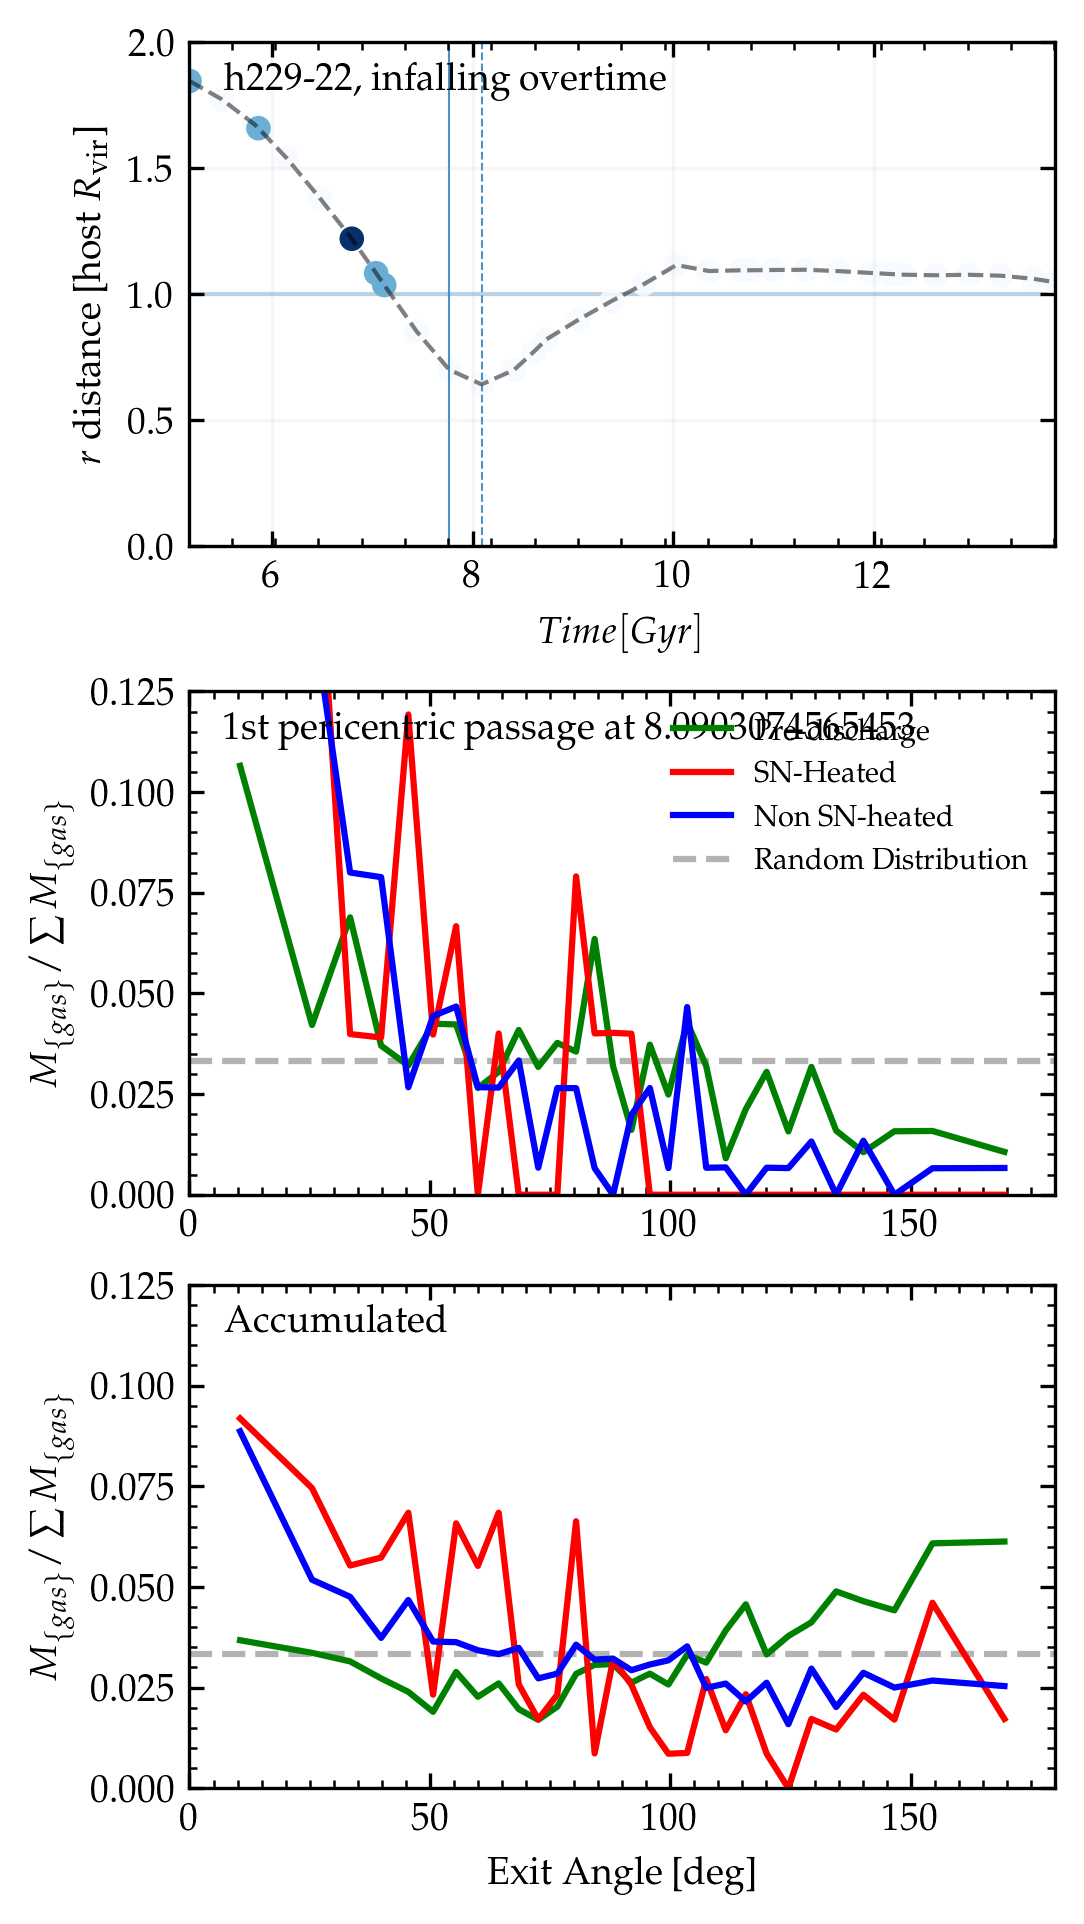

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_49 <
> Returning <tracked_particle> dataset <
Loaded: h229_49


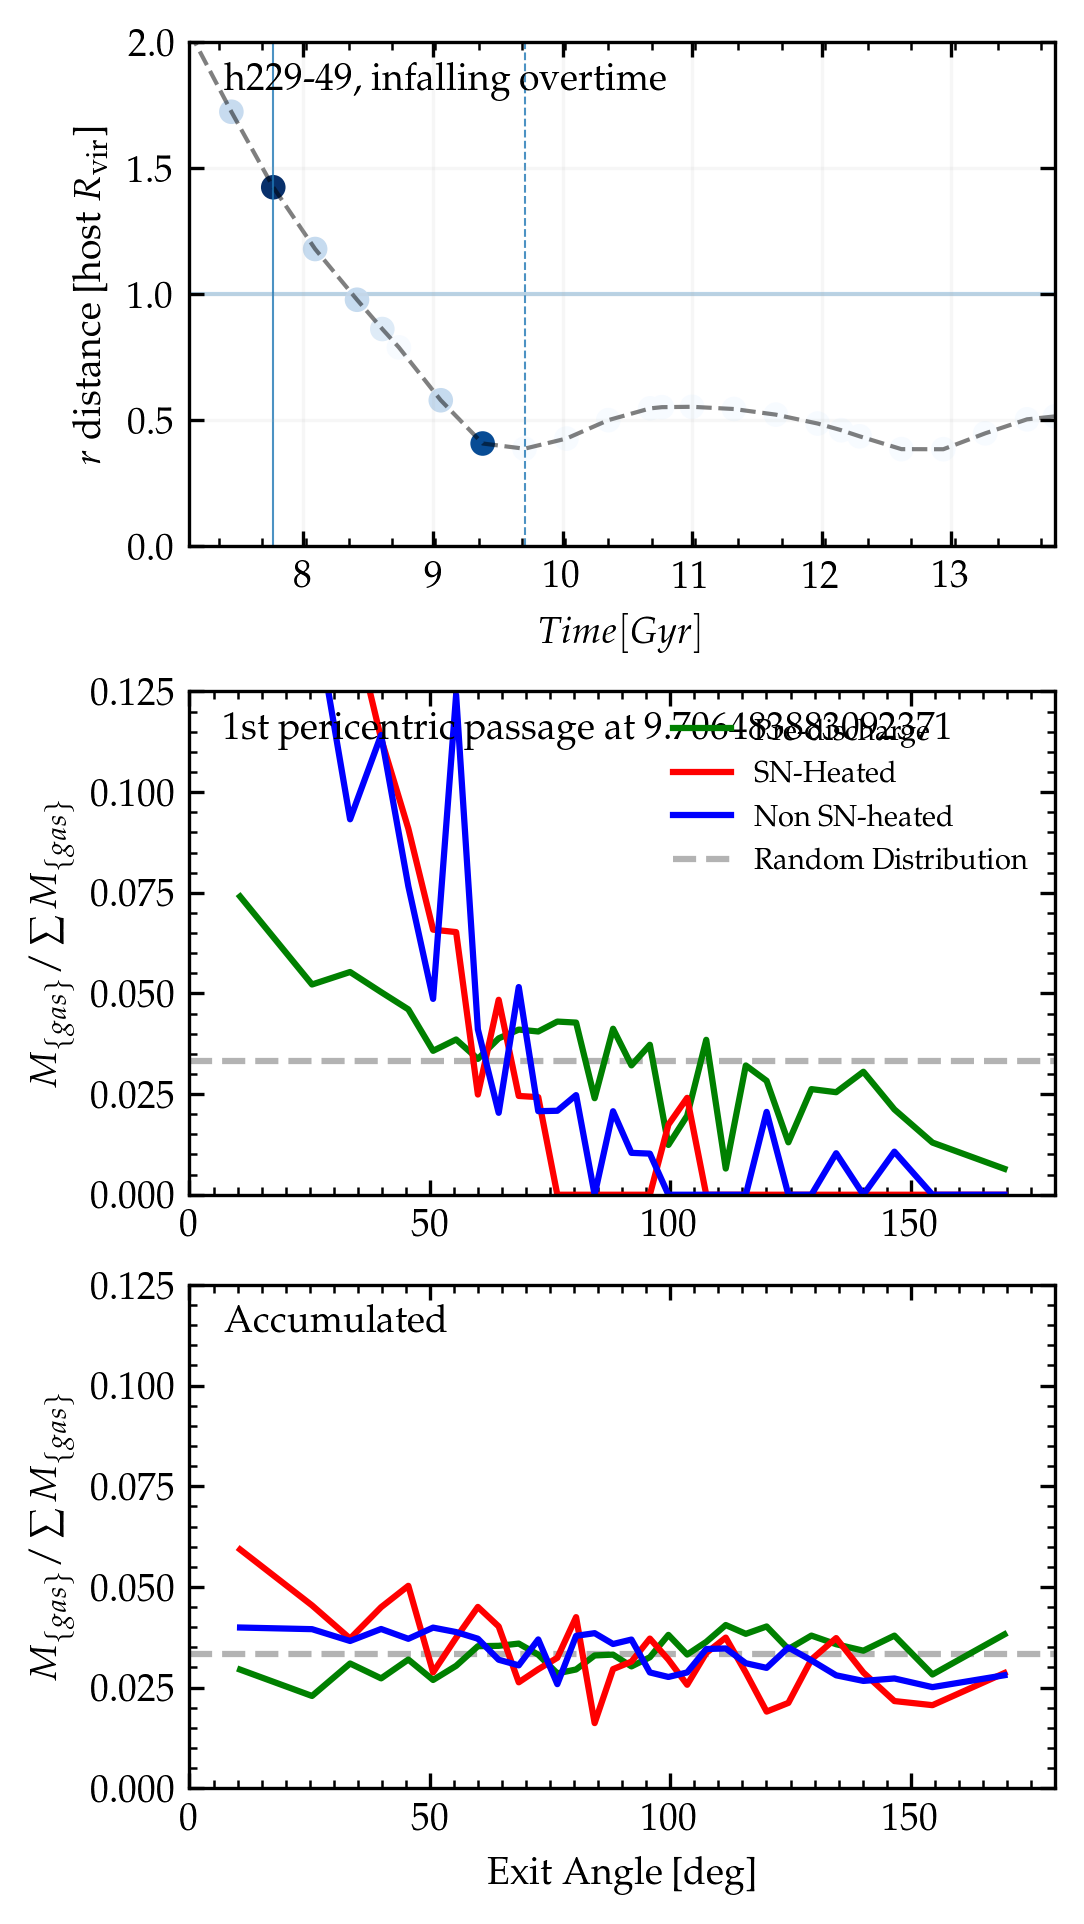

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_10 <
> Returning <tracked_particle> dataset <
Loaded: h242_10


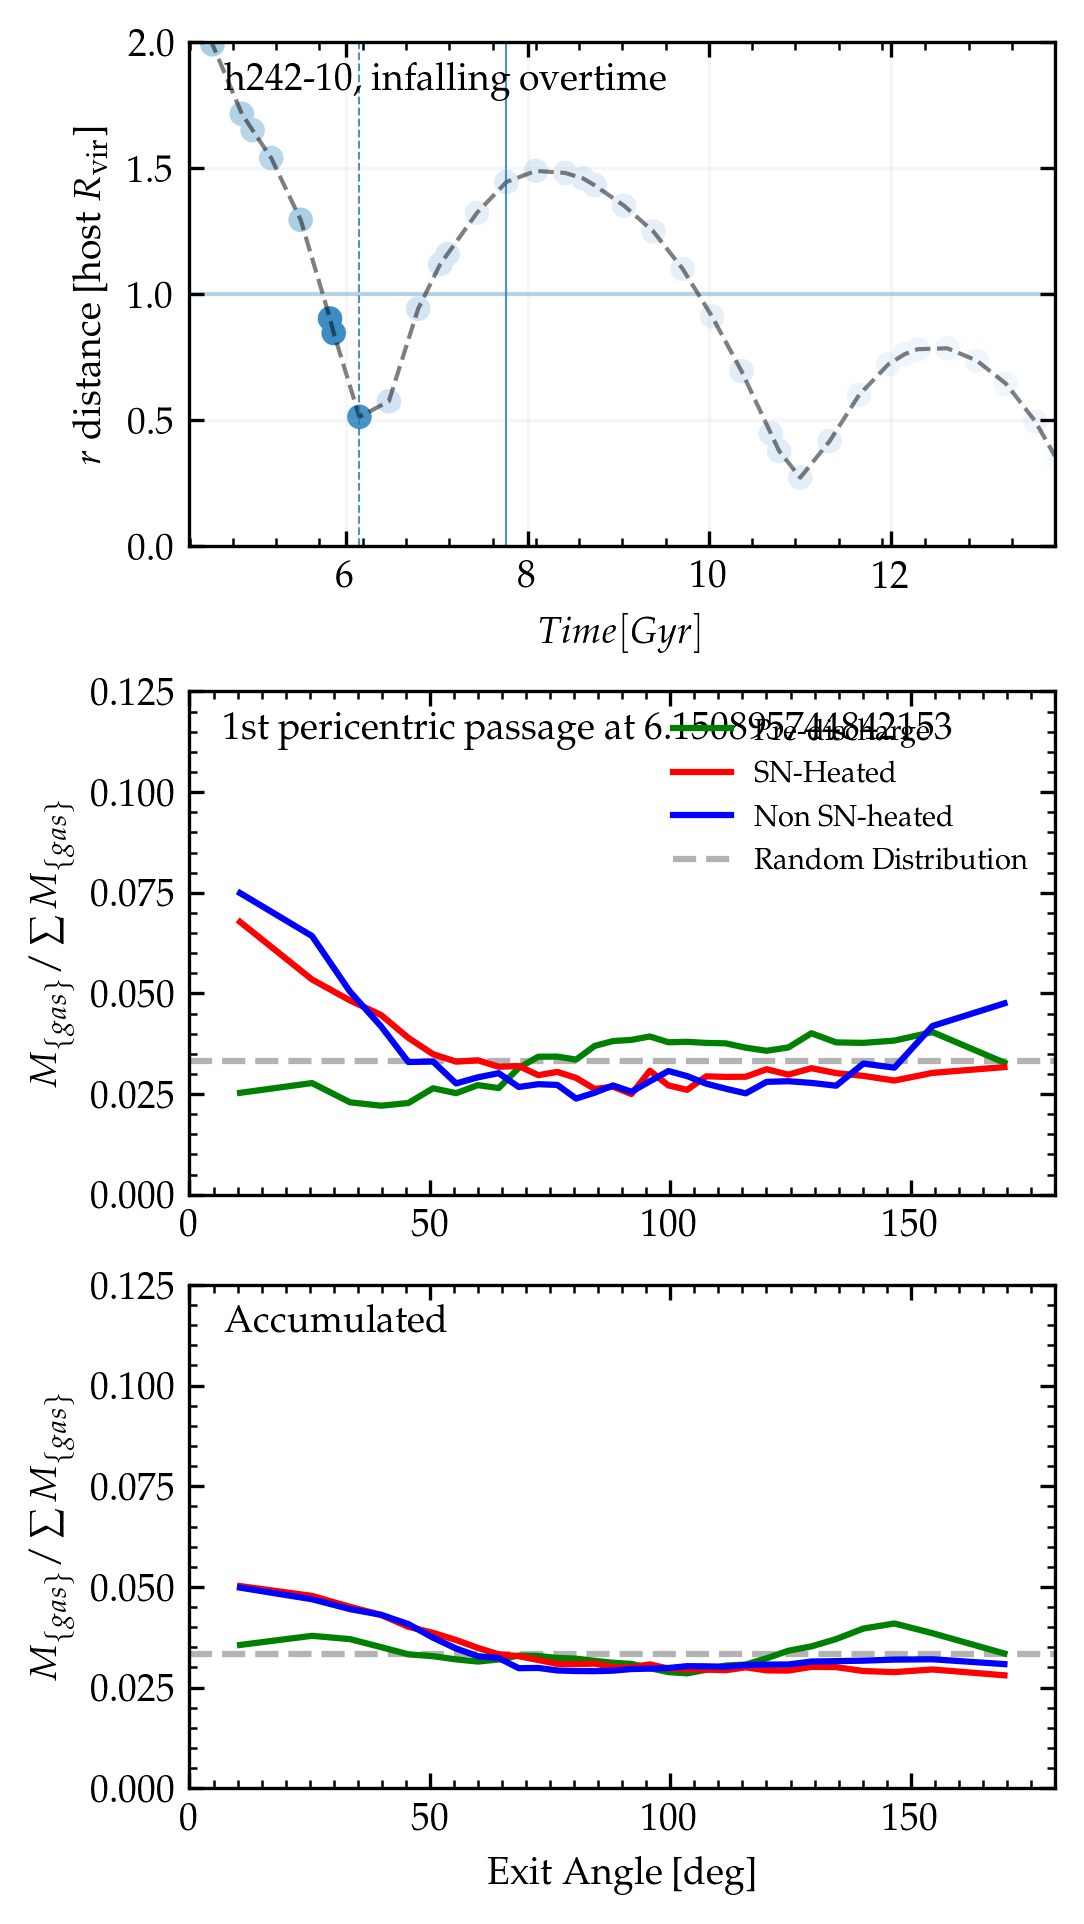

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_21 <
> Returning <tracked_particle> dataset <
Loaded: h242_21


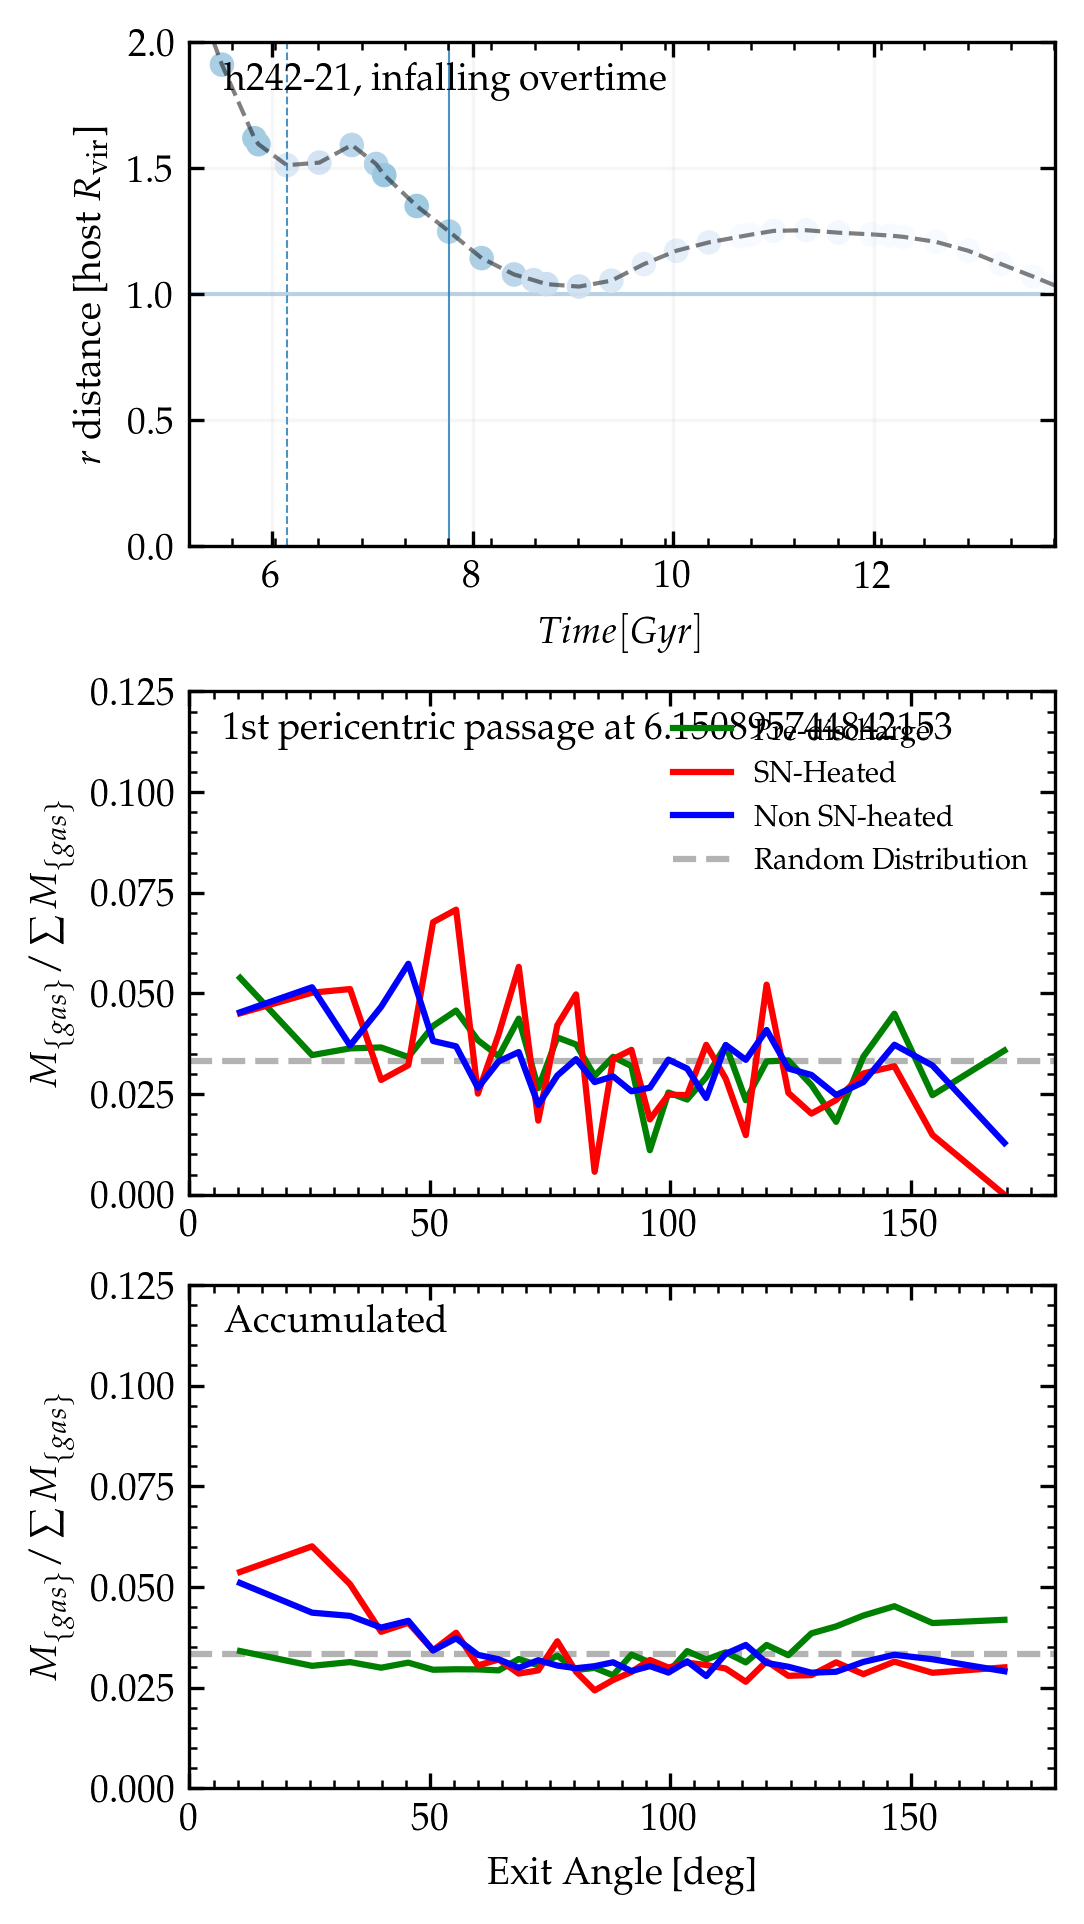

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_30 <
> Returning <tracked_particle> dataset <
Loaded: h242_30


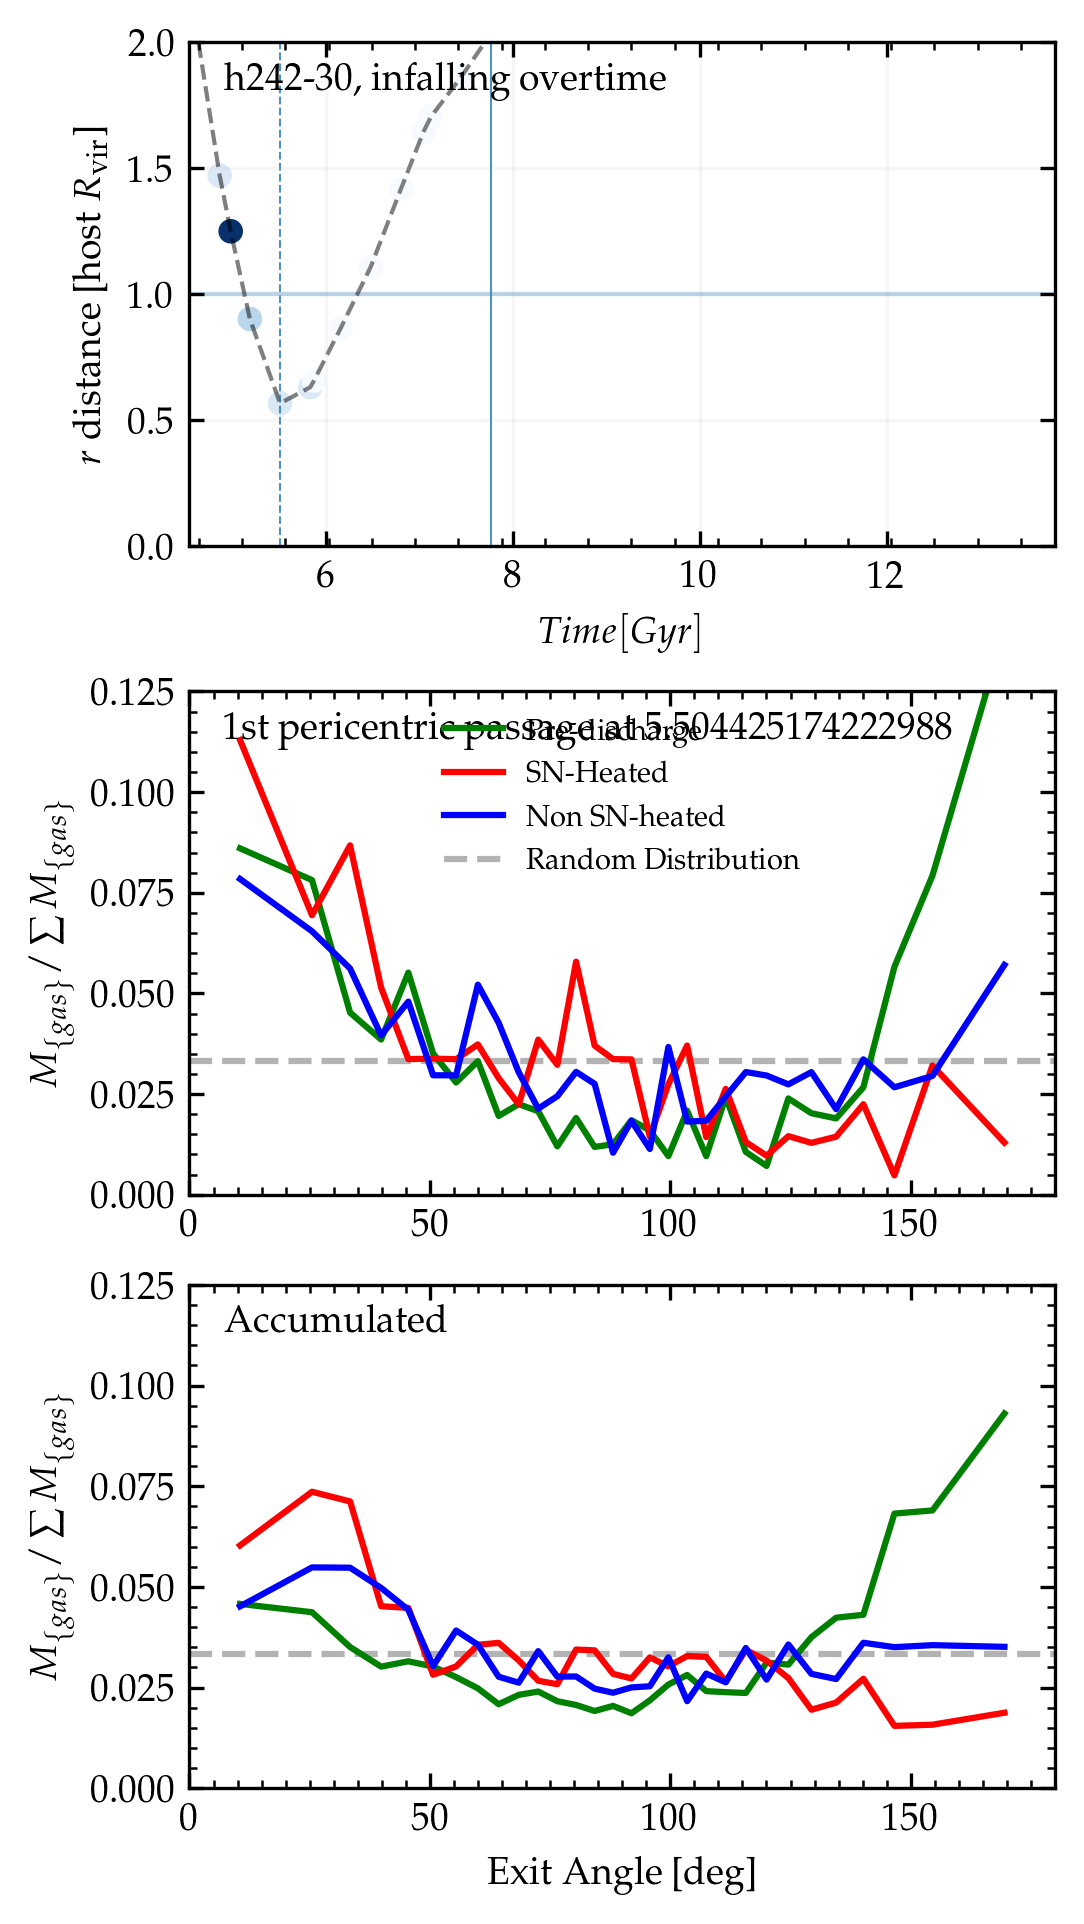

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_38 <
> Returning <tracked_particle> dataset <
Loaded: h242_38


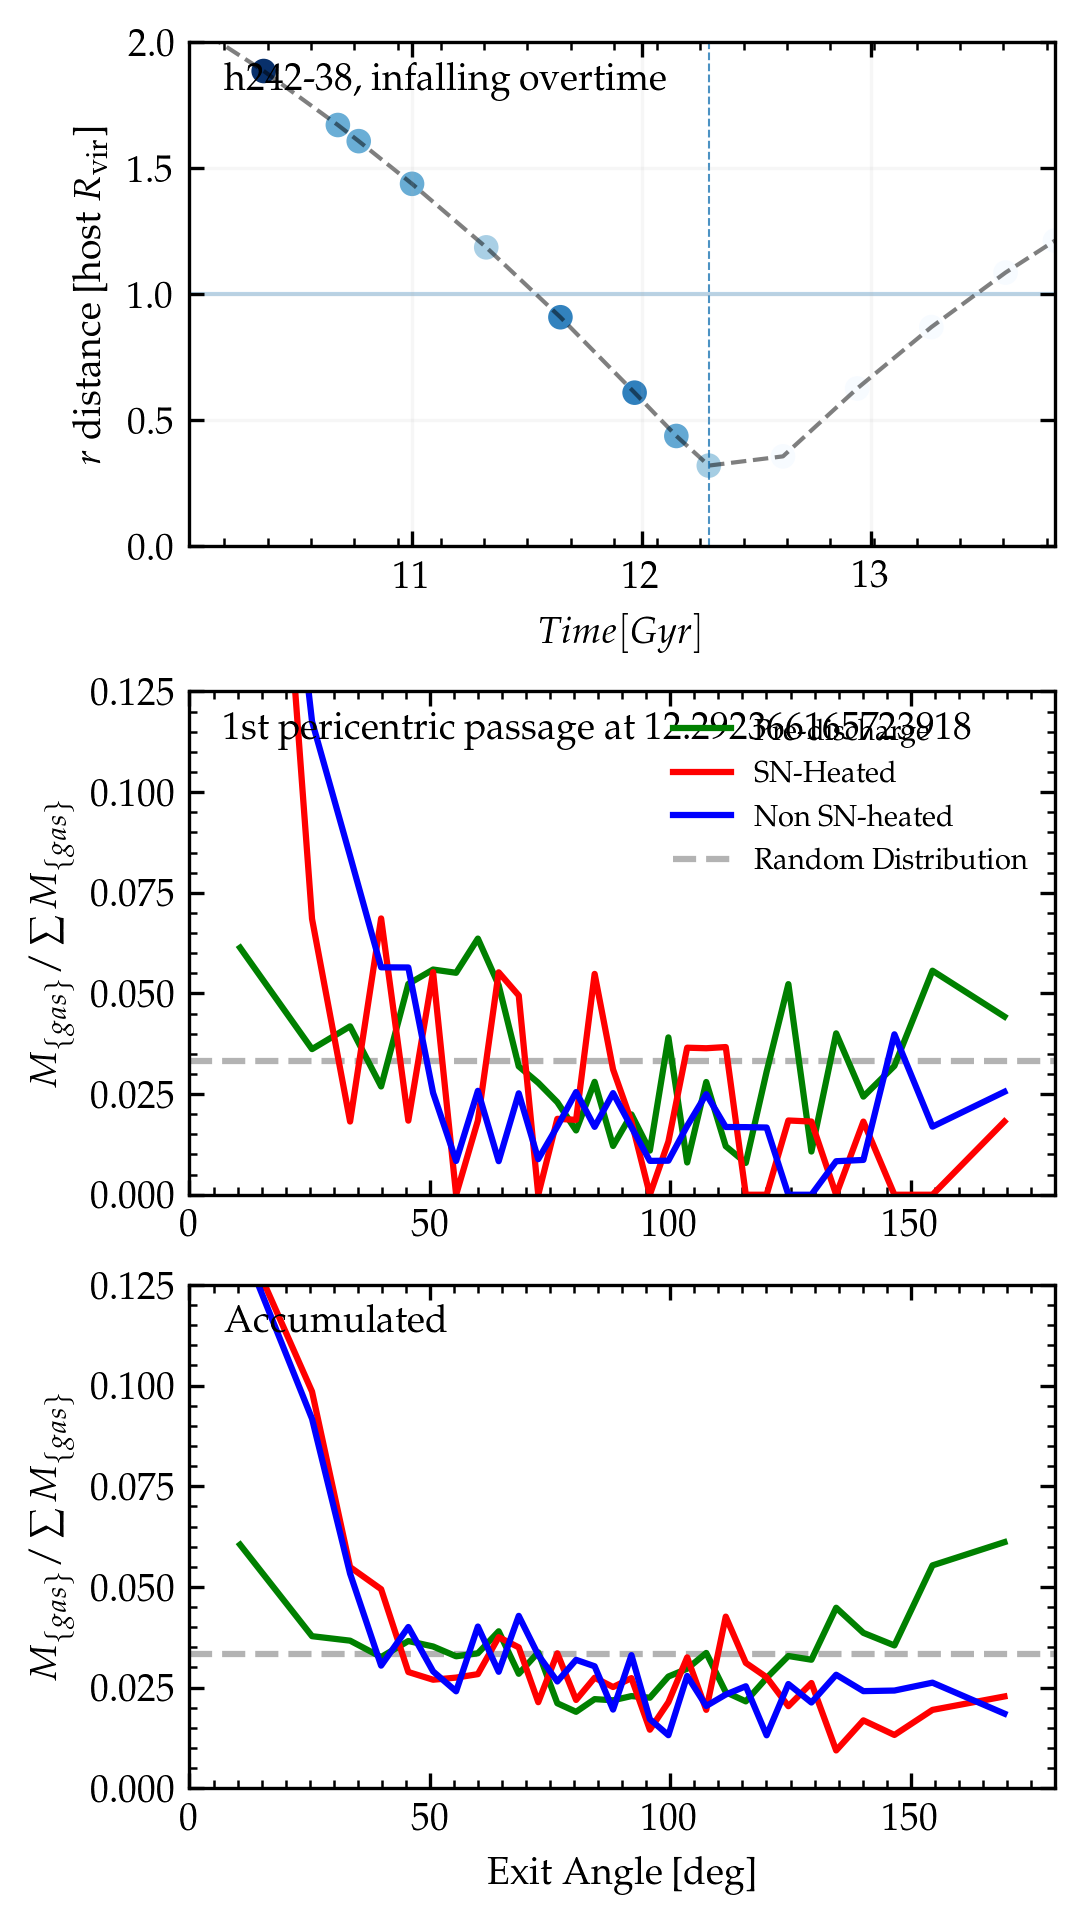

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_69 <
> Returning <tracked_particle> dataset <
Loaded: h242_69


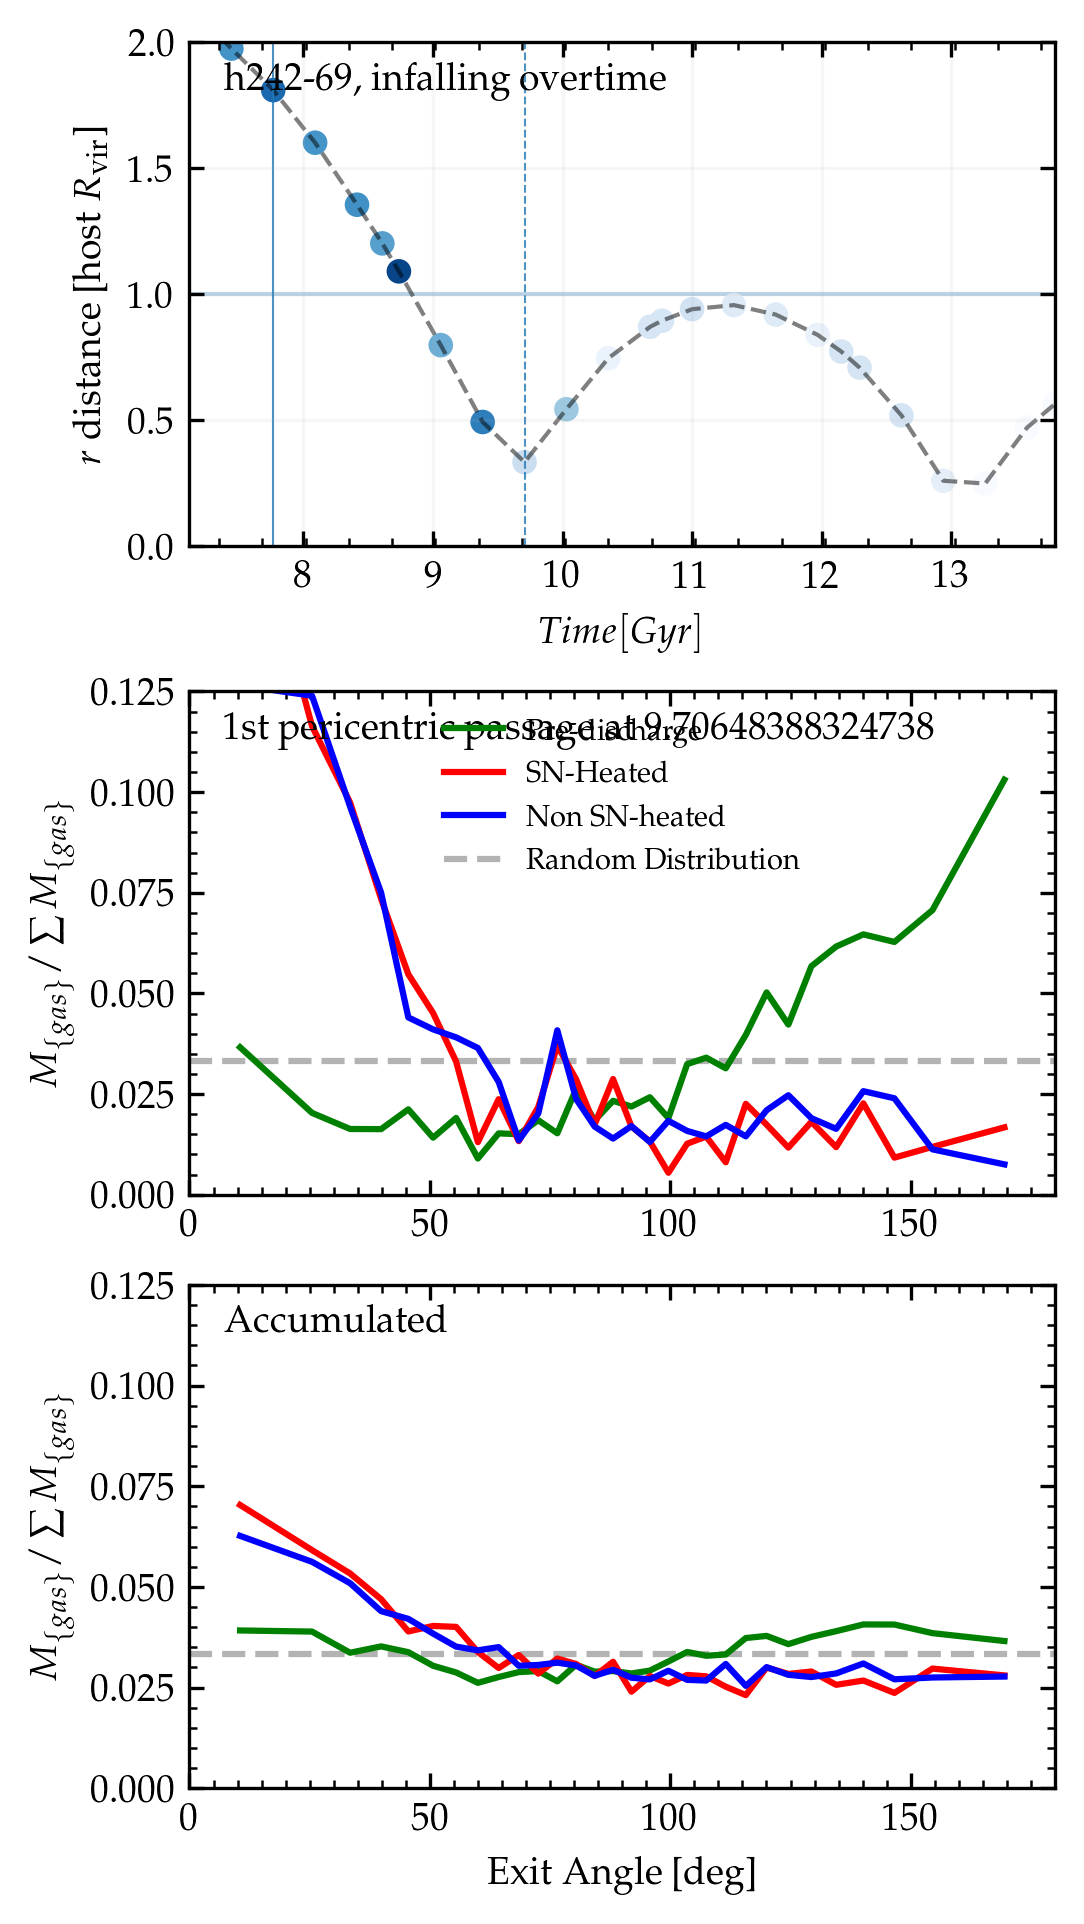

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_8 <
> Returning <tracked_particle> dataset <
Loaded: h242_8


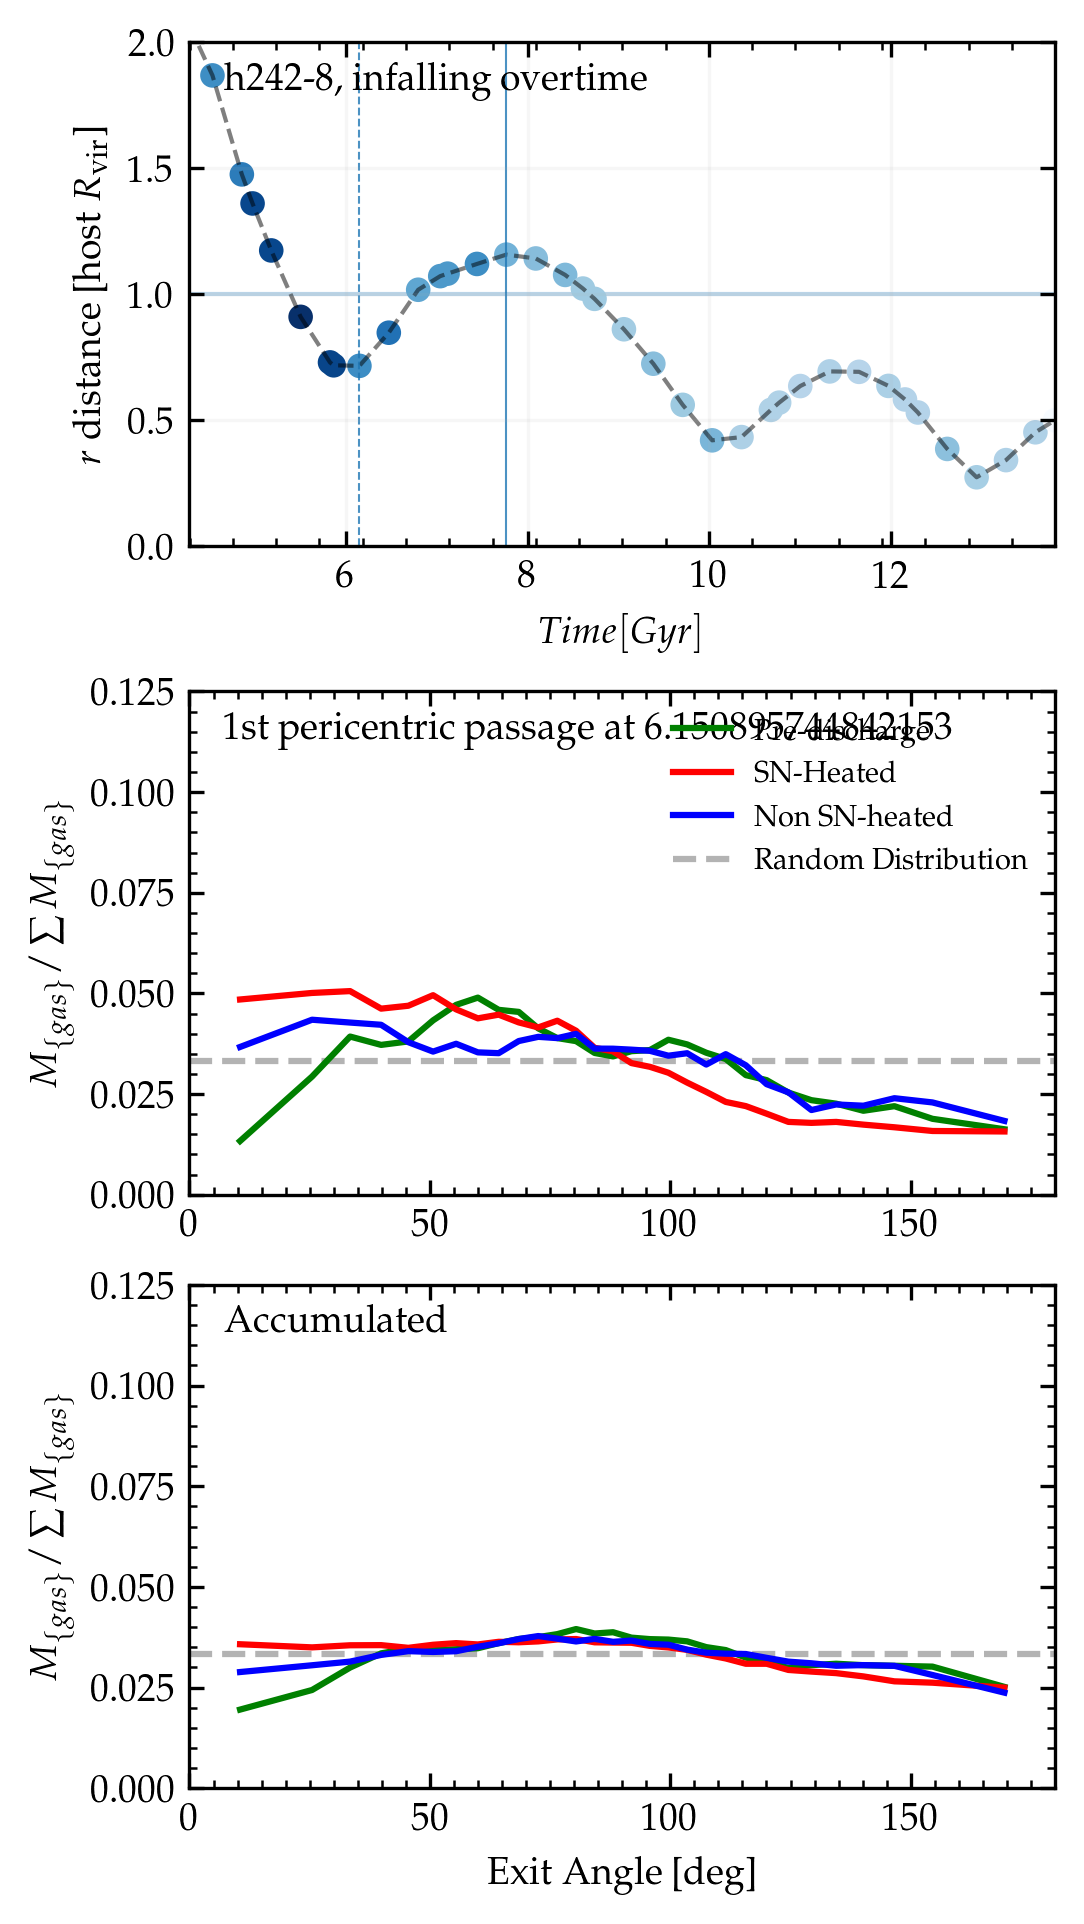

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h329_117 <
> Returning <tracked_particle> dataset <
Loaded: h329_117


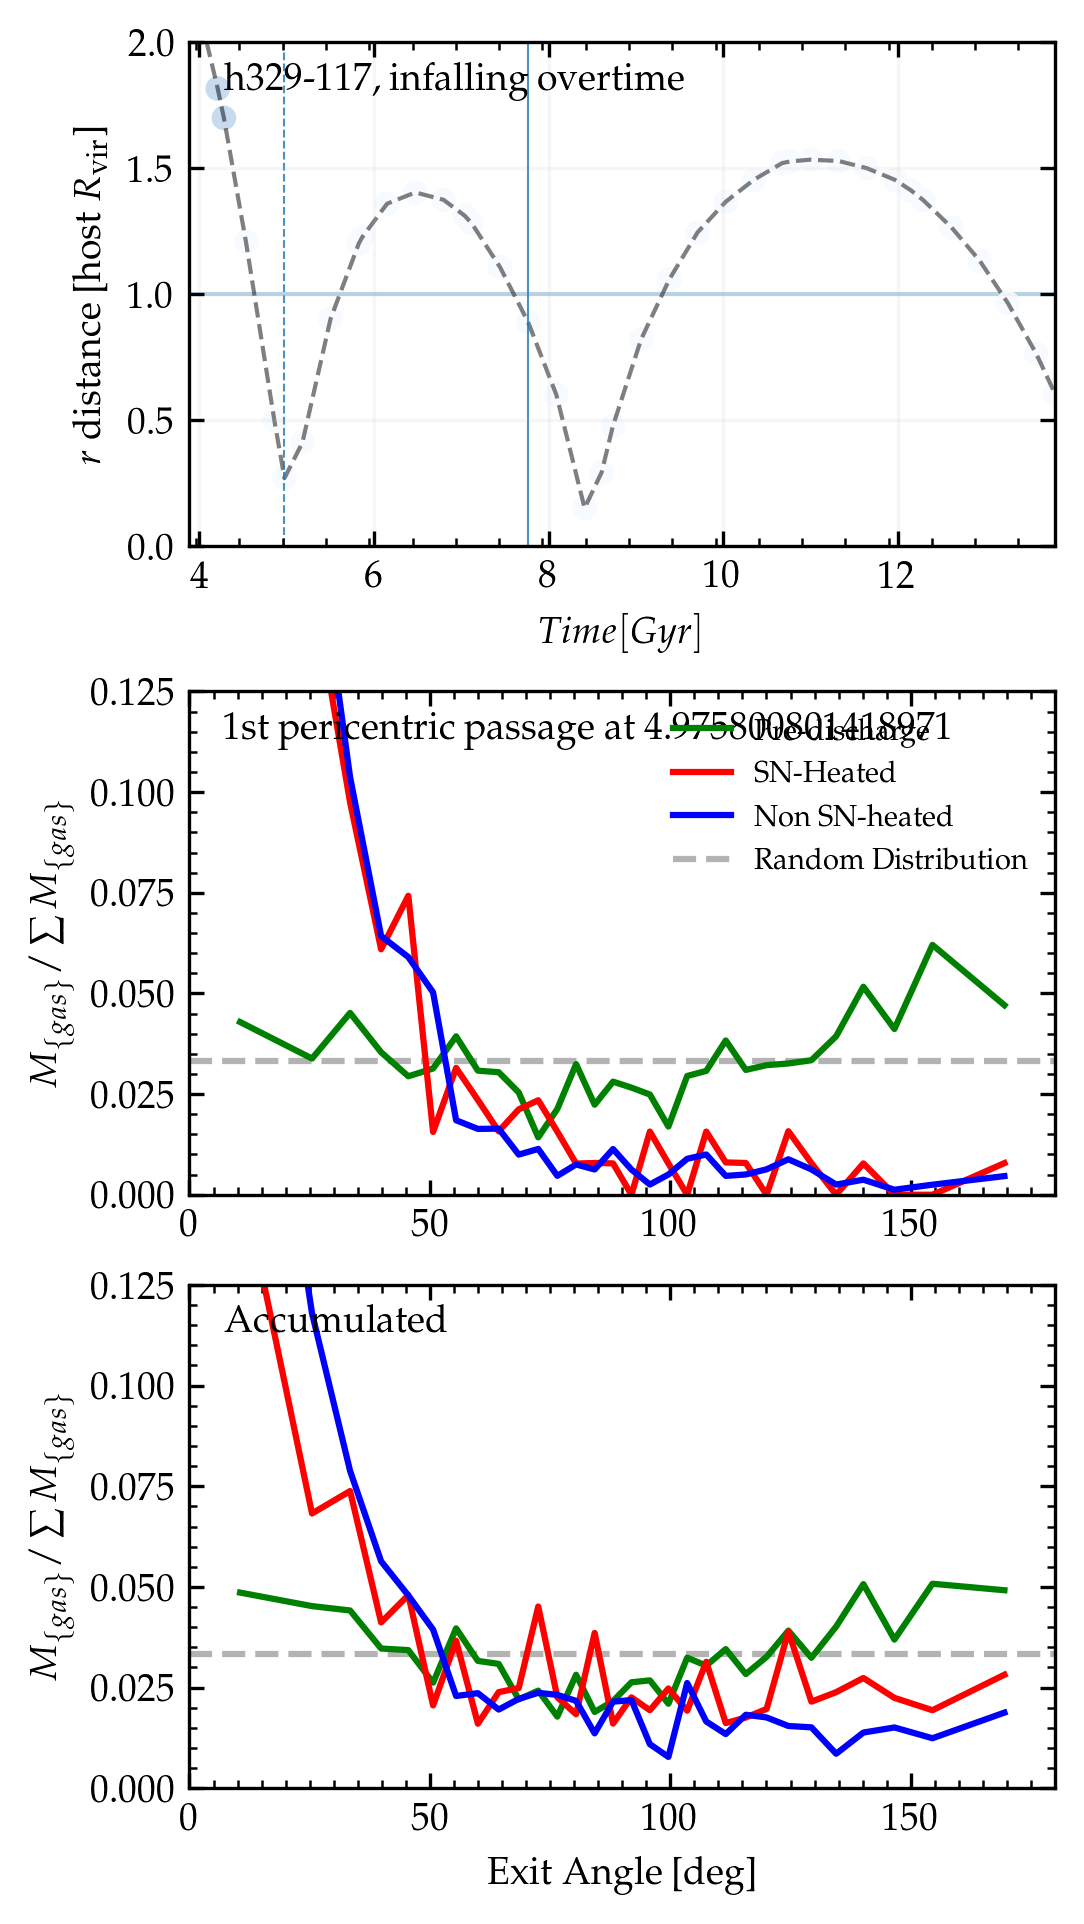

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h329_29 <
> Returning <tracked_particle> dataset <
Loaded: h329_29


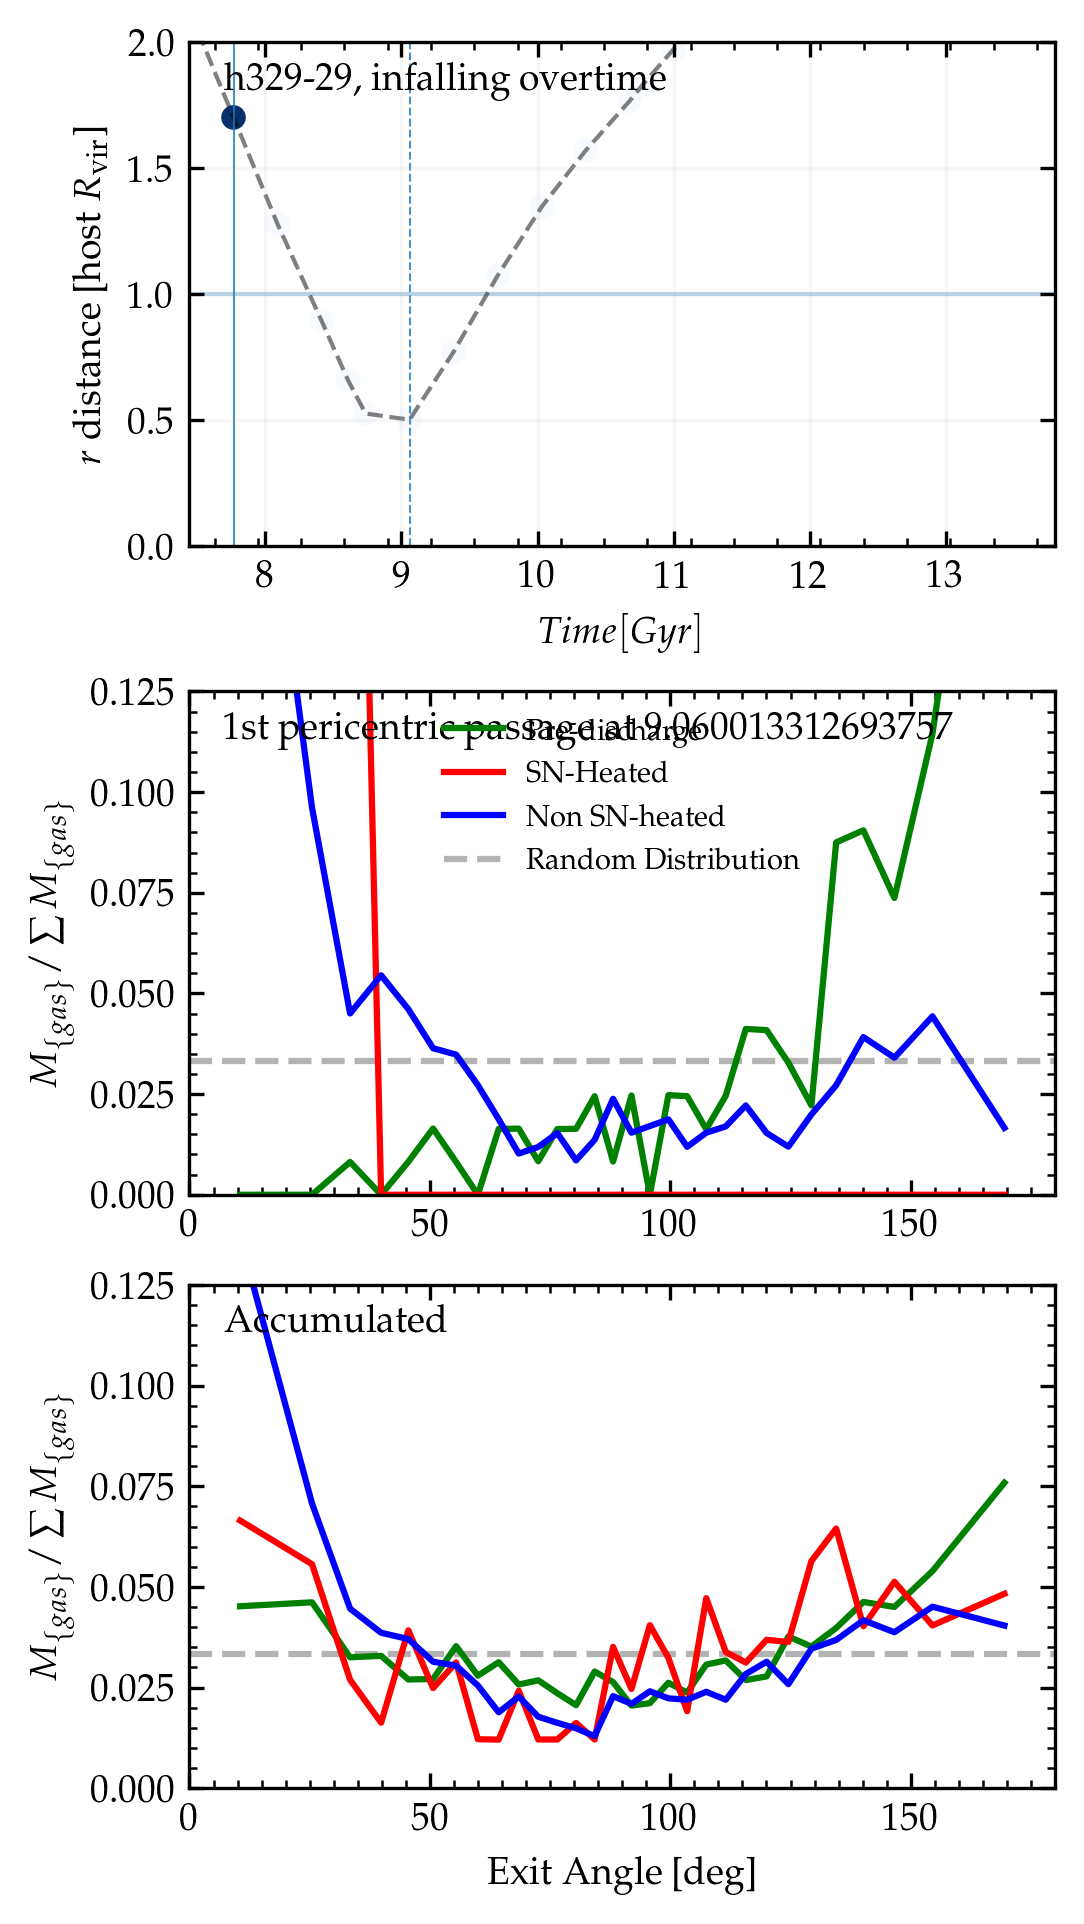

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h329_7 <
> Returning <tracked_particle> dataset <
Loaded: h329_7


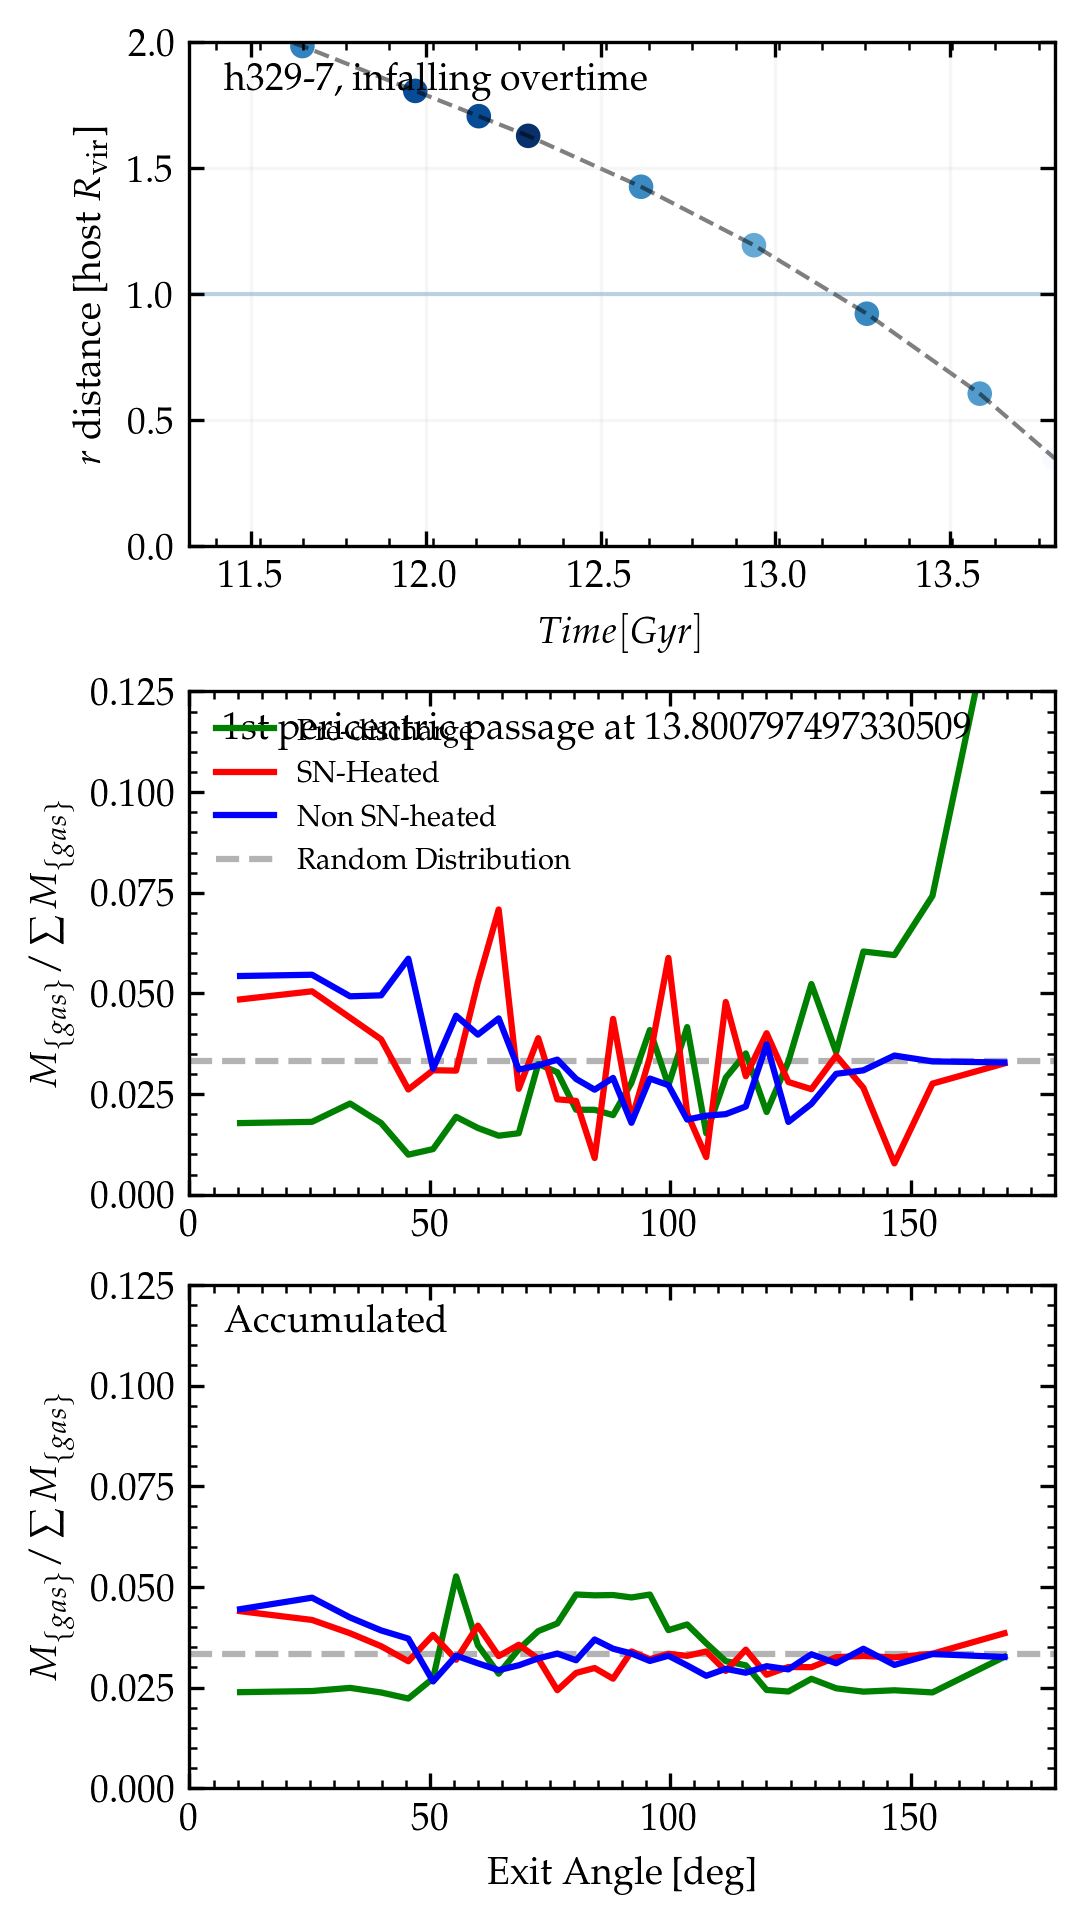

In [10]:
#let's do this at 2 Rvir away, at 1st pericentric, in a systematic plot

keys = get_keys()
R = 1.5 # in Rvir, the maximum radius to plot 
exclude = ['h242_401']

for key in keys:
    
    # skipping the one I already have
    if key in exclude:
        continue

    # read the sim tracked particles data
    sim, haloid = str(key[:4]), int(key[5:])
    data1 = read_tracked_particles(sim, haloid)
    
    # read discharged gas
    predischarged, discharged = read_one_discharged(key)
    # gas SN-heated/unheated prior to discharge.
    hot = discharged[discharged['snHeated']==True]  # heated.
    cold = discharged[discharged['snHeated']==False]  # unheated.
    
    # read tinfall, tquench, etc. time from csv file
    data = pd.read_csv('SNeData/all-satellite-information-2.csv')
    r_data = data[(data.sim==sim)&(data.haloid==haloid)]
    
    # read SFR during infall
    sfr1, bins = calc_sfr(key)
    bincenters = 0.5*(bins[1:] + bins[:-1]) #time based
    
    tmin, tmax = np.min(data1.time), np.max(data1.time)
    sfrmin, sfrmax = np.min(sfr1), np.max(sfr1)
    print('Loaded:', key)

    #plot
    fig = plt.figure(dpi=300, figsize=(3.5,6.3))
    gs = mpl.gridspec.GridSpec(3,1, figure=fig)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    
    #calculate relative distance to the host, and SFR
    x_rels, y_rels, z_rels, r_rels, Rvirs, sfrs, ts = np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([])
    for i, t in enumerate(np.unique(data1.time)):
        d = data1[data1.time==t] # find the satellite data at time t

        sat_x, sat_y, sat_z = np.mean(d.sat_Xc), np.mean(d.sat_Yc), np.mean(d.sat_Zc)
        host_x, host_y, host_z = np.mean(d.host_Xc), np.mean(d.host_Yc), np.mean(d.host_Zc)

        h1Rvir = np.mean(d.hostRvir)
        satRvir = np.mean(d.satRvir)

        Rvirs = np.append(Rvirs, satRvir/h1Rvir)

        x_rel = (sat_x-host_x)/h1Rvir
        y_rel = (sat_y-host_y)/h1Rvir
        z_rel = (sat_z-host_z)/h1Rvir

        x_rels = np.append(x_rels, x_rel)
        y_rels = np.append(y_rels, y_rel)
        z_rels = np.append(z_rels, z_rel)
        r_rels = np.append(r_rels, np.sqrt(x_rel**2 + y_rel**2 + z_rel**2)) 

        #find sfr at time t
        if isclose(bincenters[i], t, abs_tol=1e-2):
            sfr = sfr1[i]
        else:
            try:
                sfr = sfr1[np.where(bincenters > t)[0][0]] #pick the first bincenters that is close to t
            except:
                sfr = 0 #no close bincenters, skip this
        sfrs = np.append(sfrs, sfr)

        ts = np.append(ts,t)

    #plot distance vs time w/ SFR
    ax0.scatter(ts, r_rels, c=sfrs, cmap='Blues', s=24)
    ax0.plot(ts, r_rels, 'k--', linewidth=1, alpha = 0.5, zorder=1)
    ax0.axhline(y=1.0, linewidth=1, alpha = 0.3, zorder=0)
    ax0.grid(alpha = 0.1)
    
    #show where it infalls, quenches if any, where at 1 Rvir, and where at the 1st pericentric
#     f_time = float(r_data['tinfall'])
    p_time = float(r_data['1st p_time'])
#     vir_time = float(r_data['t_1Rvir_from_Host'])
#     q_time = float(r_data['tquench'])
    
    #make a vertical line indicating those instances
    ax0.axvline(x=p_time, linestyle='dashed', label='1st pericentric', 
                 alpha = 0.8, linewidth = 0.5, zorder = 1)
    ax0.axvline(x=vir_time, linestyle='solid', label='$1 R_{vir}$', 
                 alpha = 0.8, linewidth = 0.5, zorder = 1)
    
    #find discharged gas at 1st pericentric
    try:
        dsc_p = discharged[np.isclose(np.array(discharged.time), p_time, atol=0.3)]
        hot_p = hot[np.isclose(np.array(hot.time), p_time, atol=0.3)]
        cold_p = cold[np.isclose(np.array(cold.time), p_time, atol=0.3)]
        pre_p = predischarged[np.isclose(np.array(predischarged.time), p_time, atol=0.3)]
    except:
        pass
    
#     #find discharged gas at 2 Rvir away (starts infall)
#     try:
#         dsc_f = discharged[np.isclose(np.array(discharged.time), tmin, atol=0.3)]
#         hot_f = hot[np.isclose(np.array(hot.time), tmin, atol=0.3)]
#         cold_f = cold[np.isclose(np.array(cold.time), tmin, atol=0.3)]
#         pre_f = predischarged[np.isclose(np.array(predischarged.time), tmin, atol=0.3)]
#     except:
#         pass
    
    #constructing bins for exit angle histograms. angle based
    N = 30
    theta1,theta2 = 0,0 # initialize
    bins = np.array([theta1]) 
    while theta2 < 3.14:
        theta2 = np.arccos(np.cos(theta1)-(2/N))
        bins = np.append(bins,theta2)
        theta1 = theta2

    bins = bins*180/np.pi
    bincenters = 0.5*(bins[1:]+bins[:-1])
    
    #accumulate exit angles then plot, weighted by its mass
    y1, bins = np.histogram(pre_p.angle, bins=bins, weights=wt(pre_p))
    ax1.plot(bincenters, y1, label='Pre-discharge', c='green')

    y2, bins = np.histogram(hot_p.angle, bins=bins, weights=wt(hot_p))
    ax1.plot(bincenters, y2, label='SN-Heated', c='r')

    y3, bins = np.histogram(cold_p.angle, bins=bins, weights=wt(cold_p))
    ax1.plot(bincenters, y3, label='Non SN-heated', c='b')
    
    #same again for entire time
    y4, bins = np.histogram(predischarged.angle, bins=bins, weights=wt(predischarged))
    ax2.plot(bincenters, y4, label='Pre-discharge', c='green')

    y5, bins = np.histogram(hot.angle, bins=bins, weights=wt(hot))
    ax2.plot(bincenters, y5, label='SN-Heated', c='r')

    y6, bins = np.histogram(cold.angle, bins=bins, weights=wt(cold))
    ax2.plot(bincenters, y6, label='Non SN-heated', c='b')

    # line representing random distribution.
    percent = 1/N
    ax1.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
            label='Random Distribution')
    ax2.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
            label='Random Distribution')

    # labels, axis scaling, etc.
    ax0.annotate(f"{key.replace('_','-')}, infalling overtime", (0.04, 0.96), xycoords='axes fraction', va='top')
    ax0.set_xlim(tmin, tmax)
    ax0.set_ylim(0, 2) # in Rvir
    ax0.set_xlabel(r'$Time [Gyr]$')
    ax0.set_ylabel(r'$r$ distance [host $R_{\rm vir}$]')

    ax0.tick_params(top=True,right=True,direction='in', which='both')
    ax0.xaxis.set_minor_locator(mpl.ticker.MultipleLocator((tmax-tmin)/20))
    
    ax2.set_xlabel(r'Exit Angle [deg]')
    ax1.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
    ax2.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
    ax1.set_xlim(0,180)
    ax2.set_xlim(0,180)
    ax1.set_ylim(0,0.125)
    ax2.set_ylim(0,0.125)
    ax1.legend(frameon=False, fontsize='7')
    ax1.annotate(f"1st pericentric passage at {p_time}", (0.04, 0.96), xycoords='axes fraction', va='top')
    ax2.annotate(f"Accumulated", (0.04, 0.96), xycoords='axes fraction', va='top')
    
    ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
    ax2.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
    ax1.tick_params(direction='in',which='both',right=True,top=True)
    ax2.tick_params(direction='in',which='both',right=True,top=True)
    
    
    #plt.savefig(f'plots/S24_ExitAngle{key}.pdf')
    plt.show()

found the keys, starting with:  h148_10
> Returning (predischarged, discharged) for all satellites <


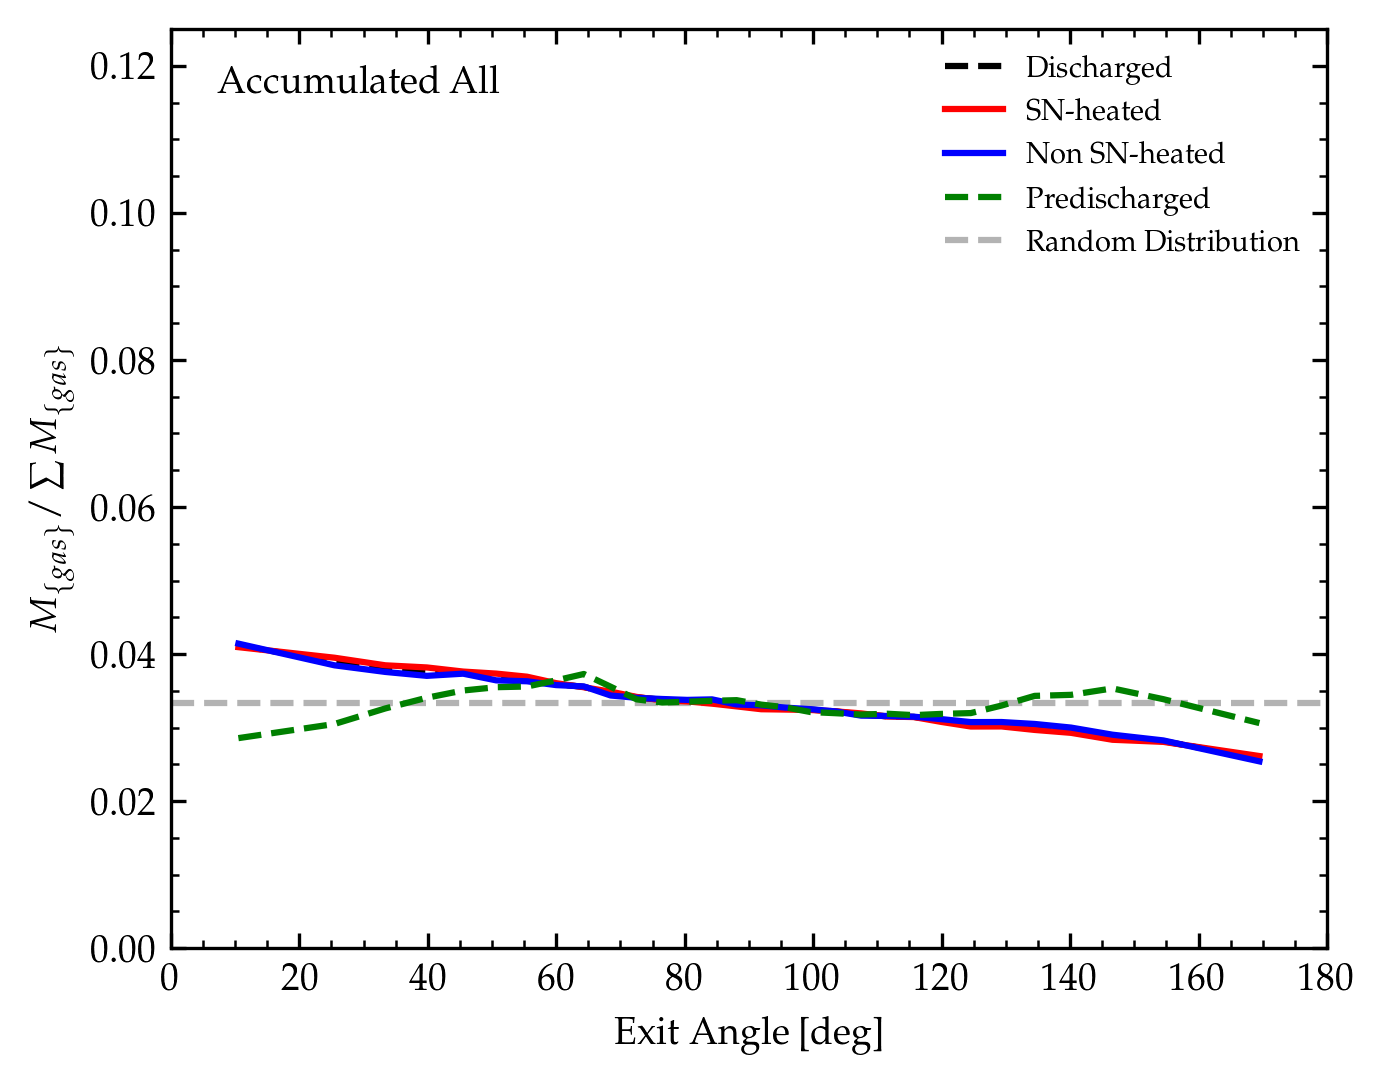

In [11]:
#Plot accumulated for all the satellites
predischarged, discharged = read_all_discharged()
hot = discharged[discharged['snHeated']==True]  # heated.
cold = discharged[discharged['snHeated']==False]  # unheated.

# read tinfall, tquench, etc. time from csv file
data = pd.read_csv('SNeData/all-satellite-information-2.csv')

# constructing bins for exit angle histograms.
N = 30
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])

#plotting
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True) 
y1, bins = np.histogram(discharged.angle, bins=bins, weights=wt(discharged))
ax.plot(bincenters, y1, label='Discharged', linestyle='--', c='black')

y2, bins = np.histogram(hot.angle, bins=bins, weights=wt(hot))
ax.plot(bincenters, y2, label='SN-heated', c='r')

y3, bins = np.histogram(cold.angle, bins=bins, weights=wt(cold))
ax.plot(bincenters, y3, label='Non SN-heated', c='b')

y4, bins = np.histogram(predischarged.angle, bins=bins, weights=wt(predischarged))
ax.plot(bincenters, y4, label='Predischarged', linestyle='--', c='green')


# line representing random distribution.
percent = 1/N
ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')


# labels, axis scaling, etc.
# ax.set_title('Exit Angle Distributions for Expelled Gas', fontsize='medium')
ax.set_xlabel(r'Exit Angle [deg]')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
ax.set_xlim(0,180)
ax.set_ylim(0,0.125)

ax.legend(frameon=False, fontsize='7')

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
#ax.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.annotate(f"Accumulated All", (0.04, 0.96), xycoords='axes fraction', va='top')

#plt.savefig('plots/S24_ExitAngleAll.pdf')
plt.show()

found the keys, starting with:  h148_10
> Returning (predischarged, discharged) for all satellites <


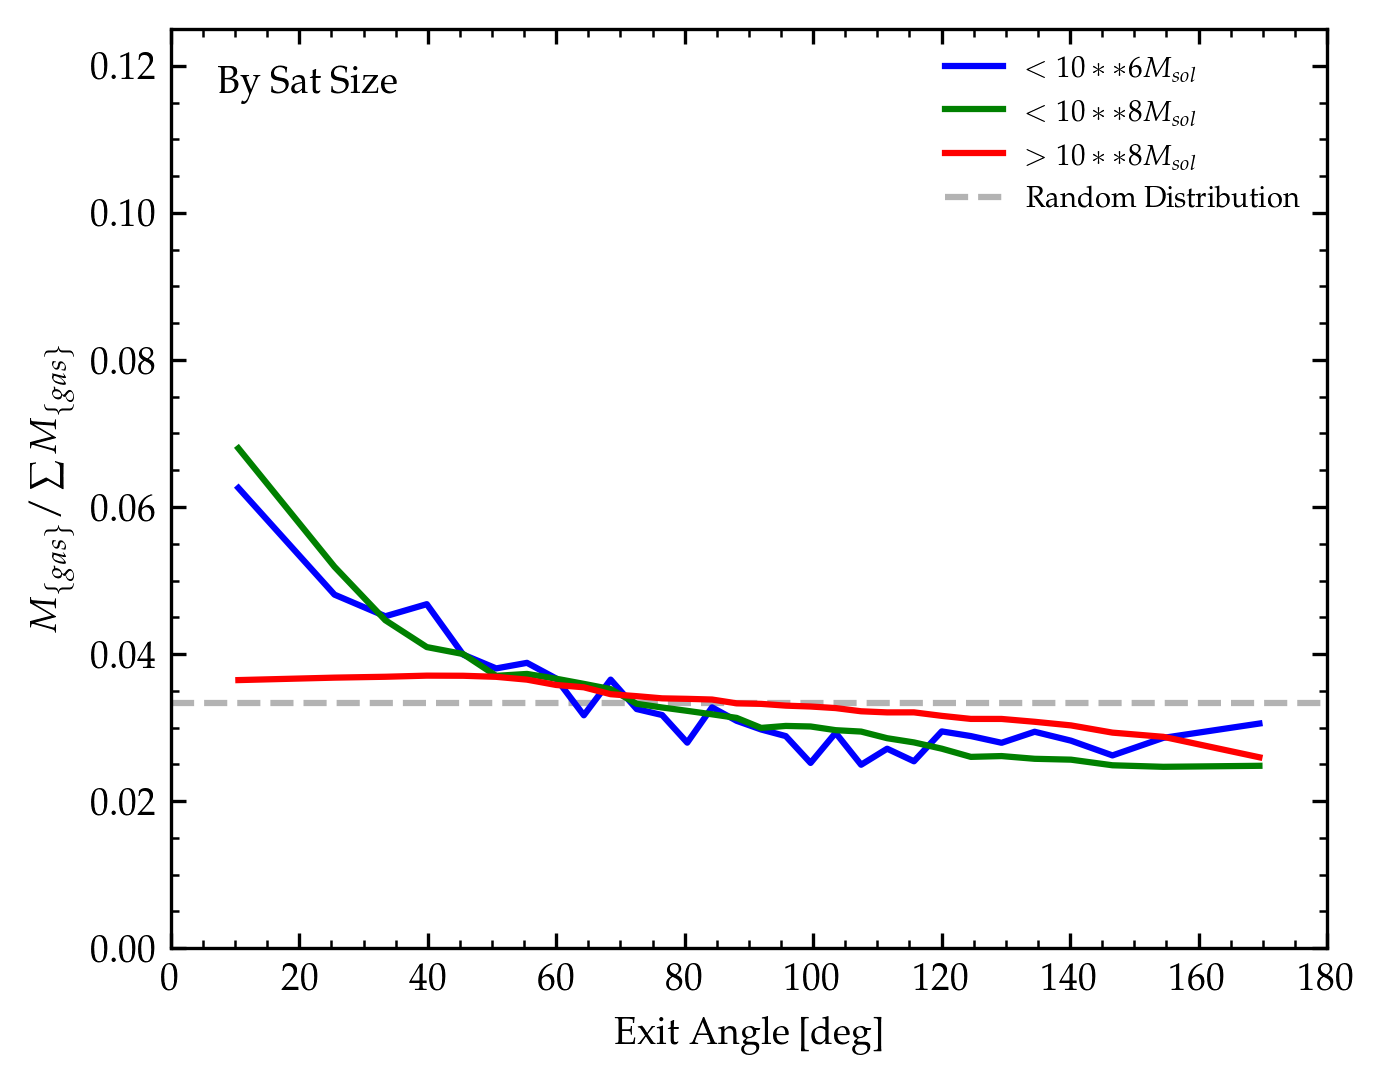

In [12]:
#plotting only small galaxies, intermediate, and massive ones
predischarged, discharged = read_all_discharged()
small_discharged = discharged[discharged['sat_Mstar'] < 10**6]
mid_discharged = discharged[(discharged['sat_Mstar'] > 10**6) & (discharged['sat_Mstar'] < 10**8)]
massive_discharged = discharged[discharged['sat_Mstar'] > 10**8]

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True) 
y1, bins = np.histogram(small_discharged.angle, bins=bins, weights=wt(small_discharged))
ax.plot(bincenters, y1, label='$< 10**6 M_{sol}$', c='blue')

y2, bins = np.histogram(mid_discharged.angle, bins=bins, weights=wt(mid_discharged))
ax.plot(bincenters, y2, label='$< 10**8 M_{sol}$', c='green')

y3, bins = np.histogram(massive_discharged.angle, bins=bins, weights=wt(massive_discharged))
ax.plot(bincenters, y3, label='$> 10**8 M_{sol}$', c='red')

# line representing random distribution.
percent = 1/N
ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')


# labels, axis scaling, etc.
# ax.set_title('Exit Angle Distributions for Expelled Gas', fontsize='medium')
ax.set_xlabel(r'Exit Angle [deg]')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
ax.set_xlim(0,180)
ax.set_ylim(0,0.125)

ax.legend(frameon=False, fontsize='7')

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
#ax.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.annotate(f"By Sat Size", (0.04, 0.96), xycoords='axes fraction', va='top')

#plt.savefig('plots/S24_ExitAngleAll.pdf')
plt.show()

In [13]:
#check how many particles showing up above.
print("Small dataframe has ", len(small_discharged), " particles. Mid dataframe has ", len(mid_discharged), " particles. Massive dataframe has ", len(massive_discharged))

Small dataframe has  7310  particles. Mid dataframe has  361110  particles. Massive dataframe has  2273474


We can see that massive galaxies tend to not have any directional dominancy when discharged. This makes sense as massive galaxies have more gravitational potential and thus less likely affected by environmental gas outflow.

Now we can look at time dependency of the exit angle. My question here is whether there is any significant difference at 1st pericentric passage. I will investigate the mass-dependency afterwards as well.

Notes after MTG: to align with standard notions of prior infall and post infall, beginning here, I define prior infall as before it hits 1 virial radius of host, and post infall as after it hits 1 virial radius. !st pericentric passage takes 1 Gyr after `1st p_time`

## Mass and Time Dependency

In [14]:
keys = get_keys()
exclude = ['h242_401']
prior_all = pd.DataFrame()
post_all = pd.DataFrame()
pericenter_all = pd.DataFrame()
for key in keys:
    infall_discharged = pd.DataFrame()
    pericenter_discharged = pd.DataFrame()
    # skipping the one I already have
    if key in exclude:
        continue

    # read the sim tracked particles data
    sim, haloid = str(key[:4]), int(key[5:])
    data1 = read_tracked_particles(sim, haloid)
    
    # read discharged gas
    predischarged, discharged = read_one_discharged(key)
    # gas SN-heated/unheated prior to discharge.
    hot = discharged[discharged['snHeated']==True]  # heated.
    cold = discharged[discharged['snHeated']==False]  # unheated.
    
    # read tinfall, tquench, etc. time from csv file
    data = pd.read_csv('SNeData/all-satellite-information-2.csv')
    r_data = data[(data.sim==sim)&(data.haloid==haloid)]
    #print(discharged.time, r_data.tinfall)
    
    #get prior infall, post infall, and 1st pericentirc discharged gas
    prior_discharged = discharged[discharged.time < float(r_data.tinfall)]
    post_discharged = discharged[discharged.time > float(r_data.tinfall)]
    pericenter_discharged = discharged[(discharged.time > float(r_data['1st p_time'])-1)&(discharged.time < float(r_data['1st p_time'])+1)]    
    prior_all = pd.concat([prior_all, prior_discharged])
    post_all = pd.concat([post_all, post_discharged])
    pericenter_all = pd.concat([pericenter_all, pericenter_discharged])
    
#check how many particles showing up above.
print("prior infall has ", len(prior_all), " particles. post infall has ", len(post_all), " particles. 1st pericentric has ", len(pericenter_all))

found the keys, starting with:  h148_10
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_12 <
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_2 <
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_249 <
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_251 <
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_27 <
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_282 <
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predi

We should note that post infall has a lot of particles, 6-7 times more than 1st pericentric. So we really think when interpret this data that the post infall data are normalized and flattened out by the number of particles.

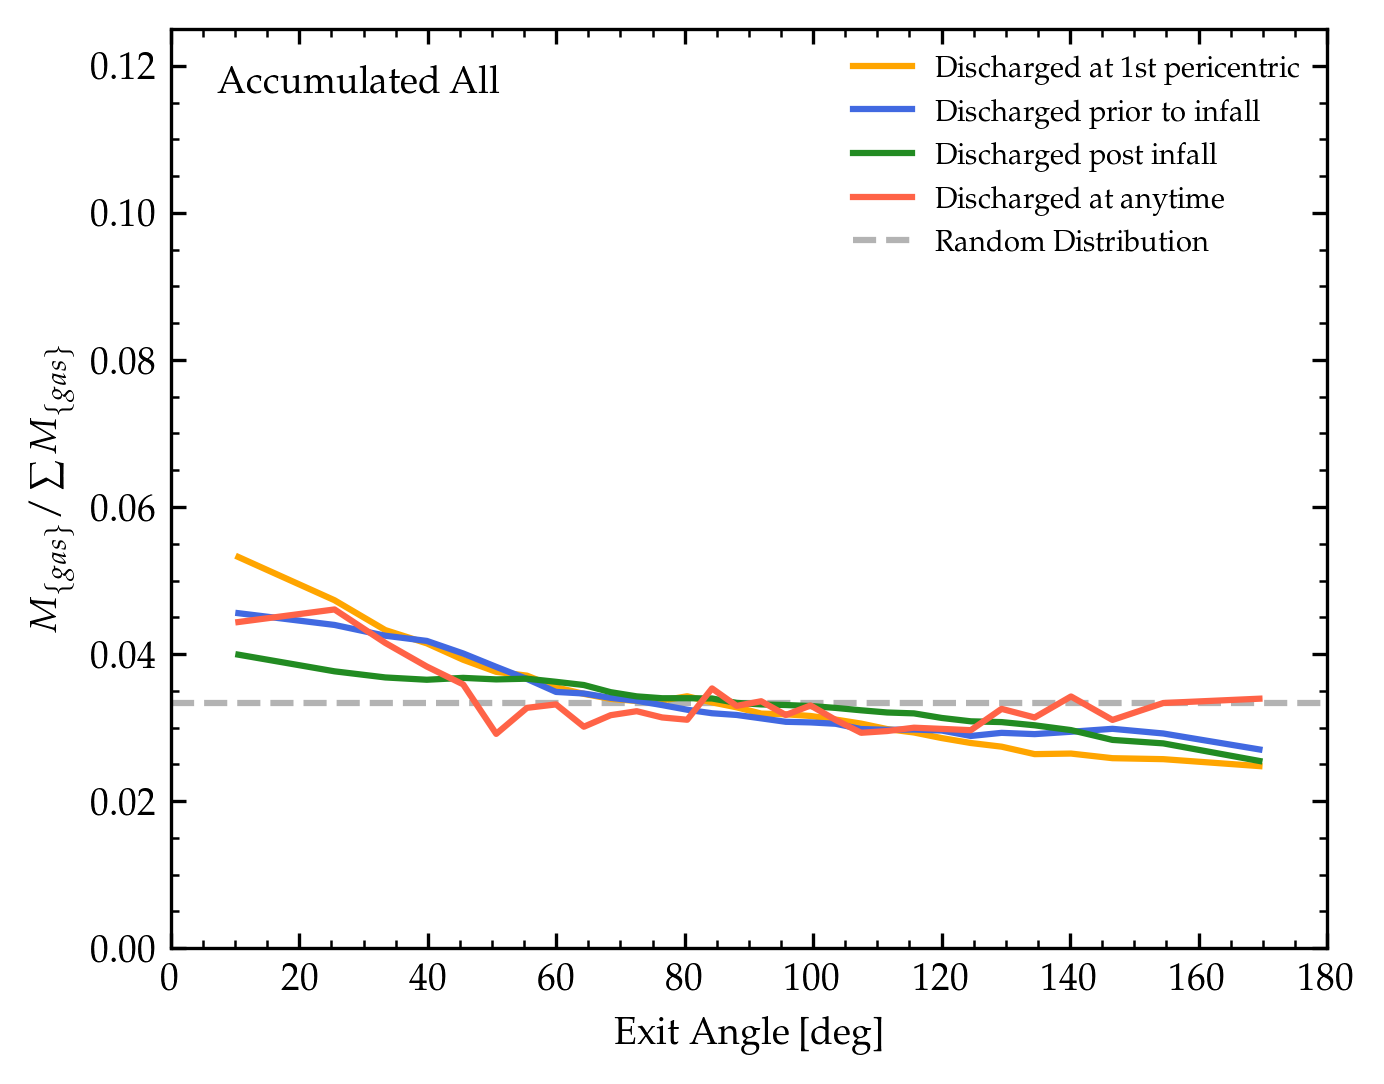

In [15]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True) 
y1, bins = np.histogram(pericenter_all.angle, bins=bins, weights=wt(pericenter_all))
ax.plot(bincenters, y1, label='Discharged at 1st pericentric', c='orange')

y2, bins = np.histogram(prior_all.angle, bins=bins, weights=wt(prior_all))
ax.plot(bincenters, y2, label='Discharged prior to infall', c='royalblue')

y3, bins = np.histogram(post_all.angle, bins=bins, weights=wt(post_all))
ax.plot(bincenters, y3, label='Discharged post infall', c='forestgreen')

y4, bins = np.histogram(discharged.angle, bins=bins, weights=wt(discharged))
ax.plot(bincenters, y4, label='Discharged at anytime', c='tomato')

# y3, bins = np.histogram(cold.angle, bins=bins, weights=wt(cold))
# ax.plot(bincenters, y3, label='Non SN-heated', c='b')

# y4, bins = np.histogram(predischarged.angle, bins=bins, weights=wt(predischarged))
# ax.plot(bincenters, y4, label='Predischarged', linestyle='--', c='green')


# line representing random distribution.
percent = 1/N
ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')


# labels, axis scaling, etc.
# ax.set_title('Exit Angle Distributions for Expelled Gas', fontsize='medium')
ax.set_xlabel(r'Exit Angle [deg]')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
ax.set_xlim(0,180)
ax.set_ylim(0,0.125)

ax.legend(frameon=False, fontsize='7')

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
#ax.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.annotate(f"Accumulated All", (0.04, 0.96), xycoords='axes fraction', va='top')

#plt.savefig('plots/S24_ExitAngleTime_PriorPostPericenter.pdf')
plt.show()

At this point, we have seen two important phenomena. One is that the exit angle has some dominant direction for most of the galaxies, and this is more so in smaller galaxies than massive ones, which may be explained by environment factors (e.g. ram pressure) causing the gas outflow more radically on smaller ones. Interestingly, compared with Leo's result, our new result which included more massive galaxies flattened out. But when we extract massive ones (> $10^8 M_{sol}$), we still get similar result.

Second thing is the time dependency of exit angle. When at 1st pericentric passage, the peak angle is more dominant than other angles, which aligns with our past results. There is not much of the difference b/w prior infall and post infall, however, given different size of number of particles included in the data frame, it is difficult to make a comparison analysis.

Now in order to increase the size of pericenter particles, we should add '1st p_time' plus minus 1 Gyr

In [16]:
#time dependency at different sat mass size
#infall when 2 vir away (+ 1Gyr), when at 1st pericentric
#whether sat mass is < 10** Msol or higher
keys = get_keys()
exclude = ['h242_401']
prior_low = pd.DataFrame()
post_low = pd.DataFrame()
pericenter_low = pd.DataFrame()
prior_high = pd.DataFrame()
post_high = pd.DataFrame()
pericenter_high = pd.DataFrame()
discharged_low, discharged_high = pd.DataFrame(),pd.DataFrame()
for key in keys:
    #local dataframe
    prior_discharged = pd.DataFrame()
    post_discharged = pd.DataFrame()
    pericenter_discharged = pd.DataFrame()
    
    # skipping the one I already have
    if key in exclude:
        continue

    # read the sim tracked particles data
    sim, haloid = str(key[:4]), int(key[5:])
    data1 = read_tracked_particles(sim, haloid)
    
    # read discharged gas
    predischarged, discharged = read_one_discharged(key)
    # gas SN-heated/unheated prior to discharge.
    hot = discharged[discharged['snHeated']==True]  # heated.
    cold = discharged[discharged['snHeated']==False]  # unheated.
    
    # read tinfall, tquench, etc. time from csv file
    data = pd.read_csv('SNeData/all-satellite-information-2.csv')
    r_data = data[(data.sim==sim)&(data.haloid==haloid)]
    #print(discharged.time, r_data.tinfall)
    
    if (float(r_data.M_star) < 10**8):
        #low mass galaxy
        prior_discharged = discharged[discharged.time < float(r_data.tinfall)]
        post_discharged = discharged[discharged.time > float(r_data.tinfall)]
        pericenter_discharged = discharged[(discharged.time > float(r_data['1st p_time'])-1)&(discharged.time < float(r_data['1st p_time'])+1)]    
        prior_low = pd.concat([prior_low, prior_discharged])
        post_low = pd.concat([post_low, post_discharged])
        pericenter_low = pd.concat([pericenter_low, pericenter_discharged])
        discharged_low = pd.concat([discharged_low, discharged])
    elif (float(r_data.M_star) > 10**8):
        #high mass galaxy
        prior_discharged = discharged[discharged.time < float(r_data.tinfall)]
        post_discharged = discharged[discharged.time > float(r_data.tinfall)]
        pericenter_discharged = discharged[(discharged.time > float(r_data['1st p_time'])-1)&(discharged.time < float(r_data['1st p_time'])+1)]    
        prior_high = pd.concat([prior_high, prior_discharged])
        post_high = pd.concat([post_high, post_discharged])
        pericenter_high = pd.concat([pericenter_high, pericenter_discharged])
        discharged_high = pd.concat([discharged_high, discharged])
    else:
        print(f"Error in detecting sat_Mstar for {key}")

#check how many particles showing up above.
print("prior infall has ", len(prior_low), len(prior_high), " particles. post infall has ", len(post_low), len(post_high), " particles. 1st pericentric has ", len(pericenter_low), len(pericenter_high))

found the keys, starting with:  h148_10
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_12 <
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_2 <
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_249 <
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_251 <
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_27 <
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_282 <
> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predi

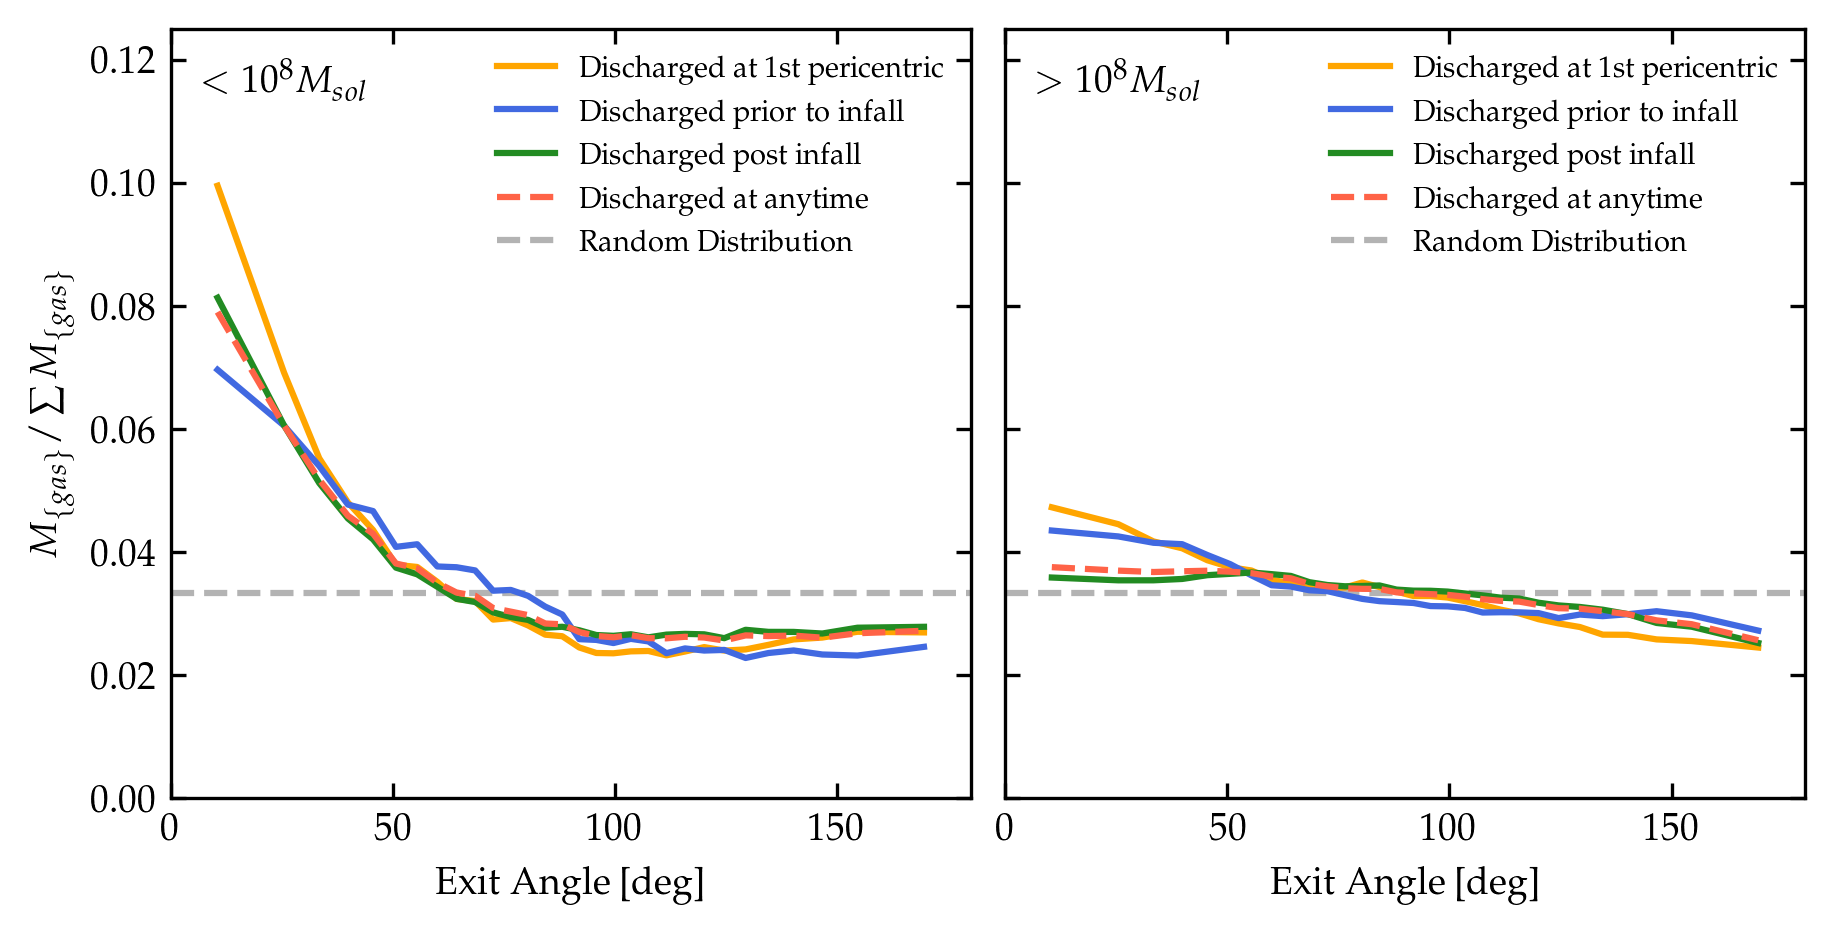

In [17]:
fig, ax = plt.subplots(1,2,figsize=(6,3),sharey=True, dpi=300, constrained_layout=True)

y1, bins = np.histogram(pericenter_low.angle, bins=bins, weights=wt(pericenter_low))
ax[0].plot(bincenters, y1, label='Discharged at 1st pericentric', c='orange')

y2, bins = np.histogram(prior_low.angle, bins=bins, weights=wt(prior_low))
ax[0].plot(bincenters, y2, label='Discharged prior to infall', c='royalblue')

y3, bins = np.histogram(post_low.angle, bins=bins, weights=wt(post_low))
ax[0].plot(bincenters, y3, label='Discharged post infall', c='forestgreen')

y4, bins = np.histogram(pericenter_high.angle, bins=bins, weights=wt(pericenter_high))
ax[1].plot(bincenters, y4, label='Discharged at 1st pericentric', c='orange')

y5, bins = np.histogram(prior_high.angle, bins=bins, weights=wt(prior_high))
ax[1].plot(bincenters, y5, label='Discharged prior to infall', c='royalblue')

y6, bins = np.histogram(post_high.angle, bins=bins, weights=wt(post_high))
ax[1].plot(bincenters, y6, label='Discharged post infall', c='forestgreen')

y7, bins = np.histogram(discharged_low.angle, bins=bins, weights=wt(discharged_low))
ax[0].plot(bincenters, y7, label='Discharged at anytime', linestyle = '--', c='tomato')

y8, bins = np.histogram(discharged_high.angle, bins=bins, weights=wt(discharged_high))
ax[1].plot(bincenters, y8, label='Discharged at anytime', linestyle = '--', c='tomato')

# line representing random distribution.
percent = 1/N
ax[0].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')
ax[1].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')

# labels, axis scaling, etc.
# ax.set_title('Exit Angle Distributions for Expelled Gas', fontsize='medium')
ax[0].set_xlabel(r'Exit Angle [deg]')
ax[1].set_xlabel(r'Exit Angle [deg]')
ax[0].set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
ax[0].set_xlim(0,180)
ax[0].set_ylim(0,0.125)
ax[1].set_xlim(0,180)
ax[1].set_ylim(0,0.125)

ax[0].legend(frameon=False, fontsize='7')
ax[1].legend(frameon=False, fontsize='7')

# ax[0].tick_params(direction='in',which='both',right=True,top=True)
# ax[1].tick_params(direction='in',which='both',right=True,top=True)
ax[0].annotate("$< 10^8 M_{sol}$", (0.04, 0.96), xycoords='axes fraction', va='top')
ax[1].annotate("$> 10^8 M_{sol}$", (0.04, 0.96), xycoords='axes fraction', va='top')

#plt.savefig('plots/S24_ExitAngleMassTime_PriorPostPericenter.pdf')
plt.show()

There is a significant difference between < 10^8 and > 10^8. Low mass galaxy has more exit angle dependency than high mass galaxy. However, time dependency seems not significant for low mass galaxy.

Interestingly, though there is no angle dominancy for high mass galaxy, there is a slight time dependency at 1st pericentric passage for high mass galaxy.

Added note on 3/14: Having prior infall and post infall separately makes the graph more reasonable to me as it shows the gradient scales on the height of the distribution from low to high. Previous analysis, only including 1 Gyr after collecting data was misleading as it has less data to show and not scientifically interesting.

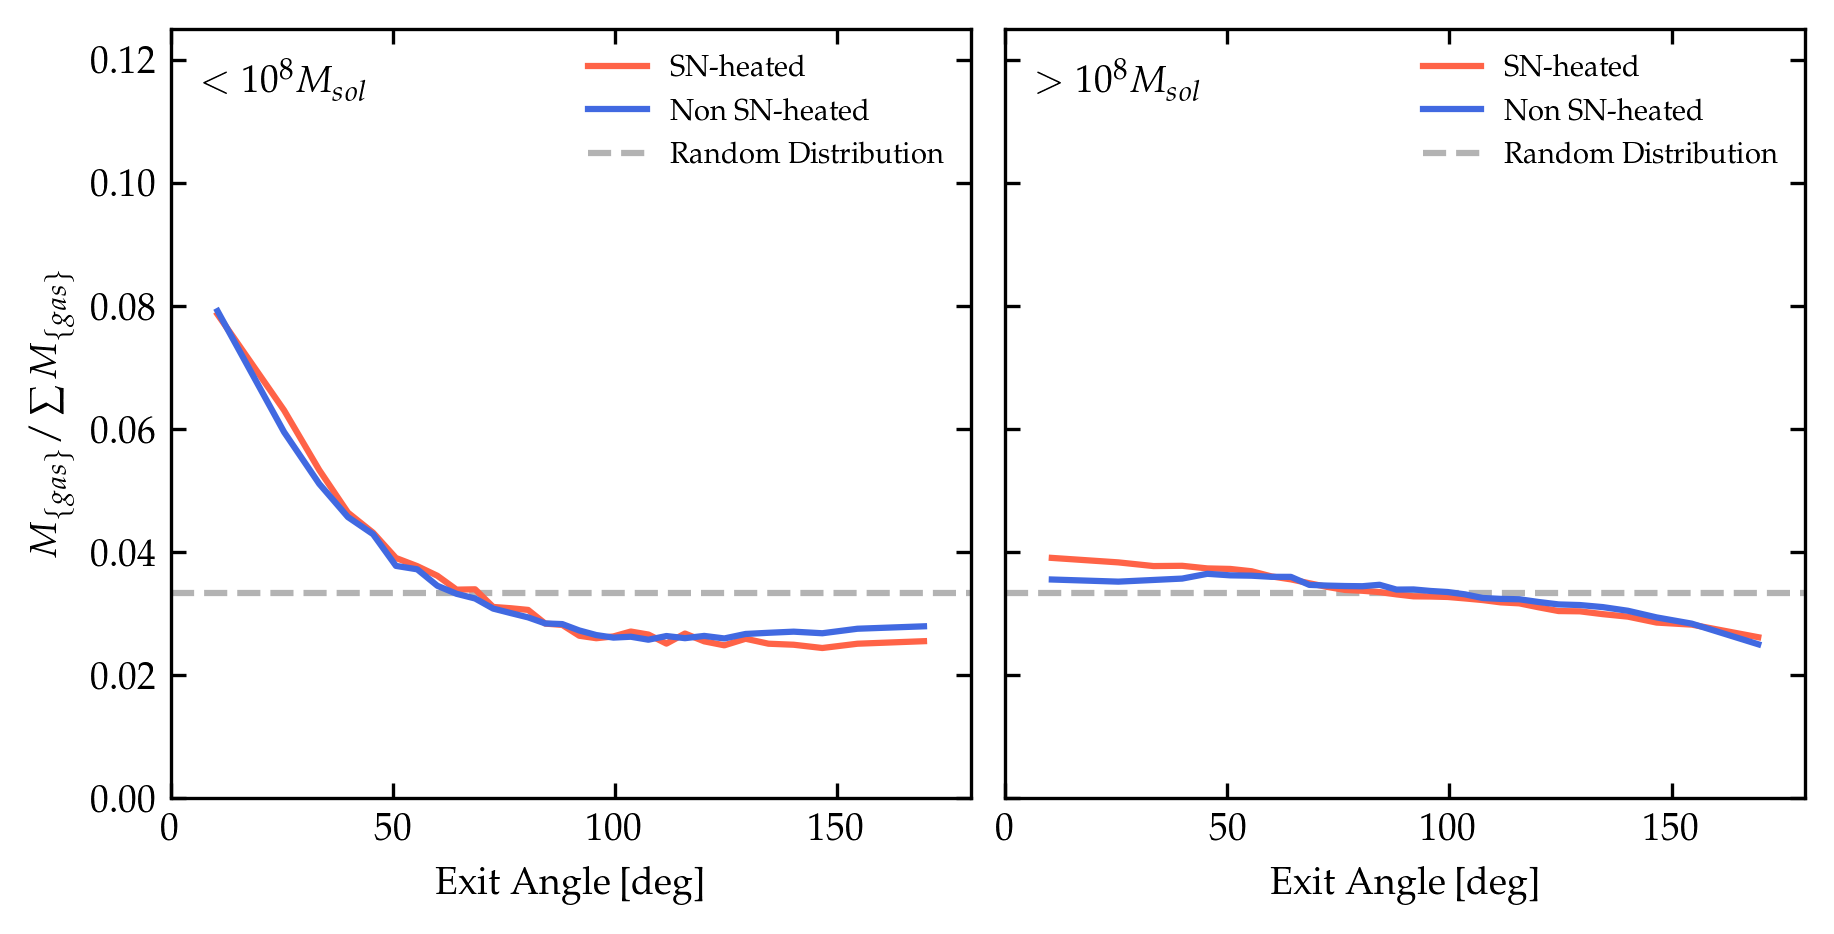

In [18]:
#Whether SN-heated for galaxies
hot = discharged_high[discharged_high['snHeated']==True]  # heated.
cold = discharged_high[discharged_high['snHeated']==False]  # unheated.
hot_prior = prior_high[prior_high['snHeated']==True]  # heated.
cold_prior = prior_high[prior_high['snHeated']==False]  # unheated.
hot_post = post_high[post_high['snHeated']==True]  # heated.
cold_post = post_high[post_high['snHeated']==False]  # unheated.
hot_pericenter = pericenter_high[pericenter_high['snHeated']==True]  # heated.
cold_pericenter = pericenter_high[pericenter_high['snHeated']==False]  # unheated.

hot_low = discharged_low[discharged_low['snHeated']==True]  # heated.
cold_low = discharged_low[discharged_low['snHeated']==False]  # unheated.
hot_prior_low = prior_low[prior_low['snHeated']==True]  # heated.
cold_prior_low = prior_low[prior_low['snHeated']==False]  # unheated.
hot_post_low = post_low[post_low['snHeated']==True]  # heated.
cold_post_low = post_low[post_low['snHeated']==False]  # unheated.
hot_pericenter_low = pericenter_low[pericenter_low['snHeated']==True]  # heated.
cold_pericenter_low = pericenter_low[pericenter_low['snHeated']==False]  # unheated.

#plotting
fig, ax = plt.subplots(1,2,figsize=(6,3),sharey=True, dpi=300, constrained_layout=True)

y1, bins = np.histogram(hot_low.angle, bins=bins, weights=wt(hot_low))
ax[0].plot(bincenters, y1, label='SN-heated', c='tomato')

y2, bins = np.histogram(cold_low.angle, bins=bins, weights=wt(cold_low))
ax[0].plot(bincenters, y2, label='Non SN-heated', c='royalblue')

y3, bins = np.histogram(hot.angle, bins=bins, weights=wt(hot))
ax[1].plot(bincenters, y3, label='SN-heated', c='tomato')

y4, bins = np.histogram(cold.angle, bins=bins, weights=wt(cold))
ax[1].plot(bincenters, y4, label='Non SN-heated', c='royalblue')

# line representing random distribution.
percent = 1/N
ax[0].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')
ax[1].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')

# labels, axis scaling, etc.
# ax.set_title('Exit Angle Distributions for Expelled Gas', fontsize='medium')
ax[0].set_xlabel(r'Exit Angle [deg]')
ax[1].set_xlabel(r'Exit Angle [deg]')
ax[0].set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
ax[0].set_xlim(0,180)
ax[0].set_ylim(0,0.125)
ax[1].set_xlim(0,180)
ax[1].set_ylim(0,0.125)

ax[0].legend(frameon=False, fontsize='7')
ax[1].legend(frameon=False, fontsize='7')

# ax[0].tick_params(direction='in',which='both',right=True,top=True)
# ax[1].tick_params(direction='in',which='both',right=True,top=True)
ax[0].annotate("$< 10^8 M_{sol}$", (0.04, 0.96), xycoords='axes fraction', va='top')
ax[1].annotate("$> 10^8 M_{sol}$", (0.04, 0.96), xycoords='axes fraction', va='top')

#plt.savefig('plots/S24_ExitAngleMassSN.pdf')
plt.show()

There is no significant difference b/w SN-heated and non SN_heated discharged gas. Perhaps, at different times in infall, they will show some characteristic trends. 

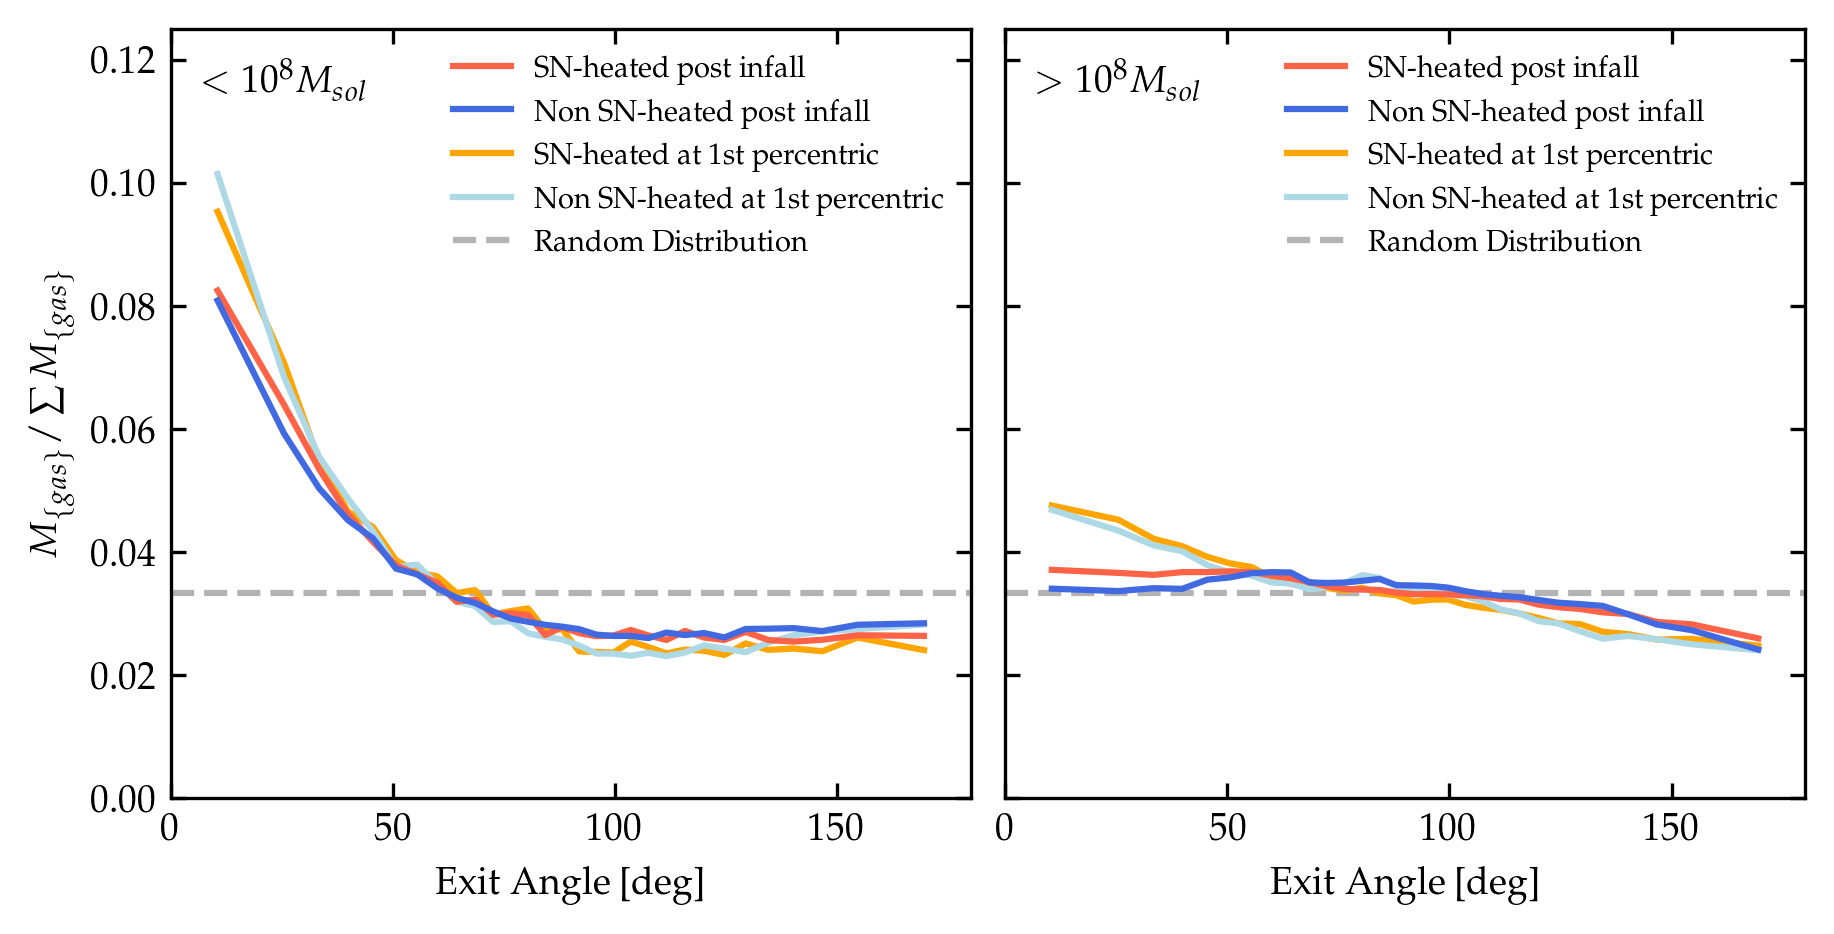

48454 32202 764904 349576


In [19]:
#plotting
fig, ax = plt.subplots(1,2,figsize=(6,3),sharey=True, dpi=300, constrained_layout=True)

y1, bins = np.histogram(hot_post_low.angle, bins=bins, weights=wt(hot_post_low))
ax[0].plot(bincenters, y1, label='SN-heated post infall', c='tomato', zorder=2)

y2, bins = np.histogram(cold_post_low.angle, bins=bins, weights=wt(cold_post_low))
ax[0].plot(bincenters, y2, label='Non SN-heated post infall', c='royalblue', zorder=2)

y3, bins = np.histogram(hot_pericenter_low.angle, bins=bins, weights=wt(hot_pericenter_low))
ax[0].plot(bincenters, y3, label='SN-heated at 1st percentric', c='orange', zorder=1)

y4, bins = np.histogram(cold_pericenter_low.angle, bins=bins, weights=wt(cold_pericenter_low))
ax[0].plot(bincenters, y4, label='Non SN-heated at 1st percentric', c='lightblue', zorder=1)

y5, bins = np.histogram(hot_post.angle, bins=bins, weights=wt(hot_post))
ax[1].plot(bincenters, y5, label='SN-heated post infall', c='tomato', zorder=2)

y6, bins = np.histogram(cold_post.angle, bins=bins, weights=wt(cold_post))
ax[1].plot(bincenters, y6, label='Non SN-heated post infall', c='royalblue', zorder=2)

y7, bins = np.histogram(hot_pericenter.angle, bins=bins, weights=wt(hot_pericenter))
ax[1].plot(bincenters, y7, label='SN-heated at 1st percentric', c='orange', zorder=1)

y8, bins = np.histogram(cold_pericenter.angle, bins=bins, weights=wt(cold_pericenter))
ax[1].plot(bincenters, y8, label='Non SN-heated at 1st percentric', c='lightblue', zorder=1)

# line representing random distribution.
percent = 1/N
ax[0].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')
ax[1].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')

# labels, axis scaling, etc.
# ax.set_title('Exit Angle Distributions for Expelled Gas', fontsize='medium')
ax[0].set_xlabel(r'Exit Angle [deg]')
ax[1].set_xlabel(r'Exit Angle [deg]')
ax[0].set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
ax[0].set_xlim(0,180)
ax[0].set_ylim(0,0.125)
ax[1].set_xlim(0,180)
ax[1].set_ylim(0,0.125)

ax[0].legend(frameon=False, fontsize='7')
ax[1].legend(frameon=False, fontsize='7')

# ax[0].tick_params(direction='in',which='both',right=True,top=True)
# ax[1].tick_params(direction='in',which='both',right=True,top=True)
ax[0].annotate("$< 10^8 M_{sol}$", (0.04, 0.96), xycoords='axes fraction', va='top')
ax[1].annotate("$> 10^8 M_{sol}$", (0.04, 0.96), xycoords='axes fraction', va='top')

#plt.savefig('plots/S24_ExitAngleMassSN_Time_PostPericenter.pdf')
plt.show()
print(len(hot_post_low),len(hot_pericenter_low),len(cold_post),len(cold_pericenter))

Here it seems that SN-heated and non SN_heated discharged particles are being affected by ram pressure in the same way. This is not visually interesting, however, it still implies an important characteristic of SN-heating. Smaller galaxies continue showing the directionality for both SN-heated particles and non SN-heated ones. If you plot 1st pericentric passage, the effect of ram pressure is the most significant for both SN and non SN-heated gas.

Note: Notice that perhaps for smaller galaxies, there is a rise past 150 degrees. This might be an indication of tidal stripping that gravitationally pull the gas out in the opposite dirrection of ram pressure. Maybe, if you look at much smaller galaxies, like $M_{sat} < 10^6 M_{sol}$, we may see it more apparently.

## Rebin Mass

In [20]:
small_pericenter = pericenter_all[pericenter_all['sat_Mstar'] < 10**6]
mid_pericenter = pericenter_all[(pericenter_all['sat_Mstar'] > 10**6) & (pericenter_all['sat_Mstar'] < 10**8)]
massive_pericenter = pericenter_all[pericenter_all['sat_Mstar'] > 10**8]

small_prior = prior_all[prior_all['sat_Mstar'] < 10**6]
mid_prior = prior_all[(prior_all['sat_Mstar'] > 10**6) & (prior_all['sat_Mstar'] < 10**8)]
massive_prior = prior_all[prior_all['sat_Mstar'] > 10**8]

small_post = post_all[post_all['sat_Mstar'] < 10**6]
mid_post = post_all[(post_all['sat_Mstar'] > 10**6) & (post_all['sat_Mstar'] < 10**8)]
massive_post = post_all[post_all['sat_Mstar'] > 10**8]

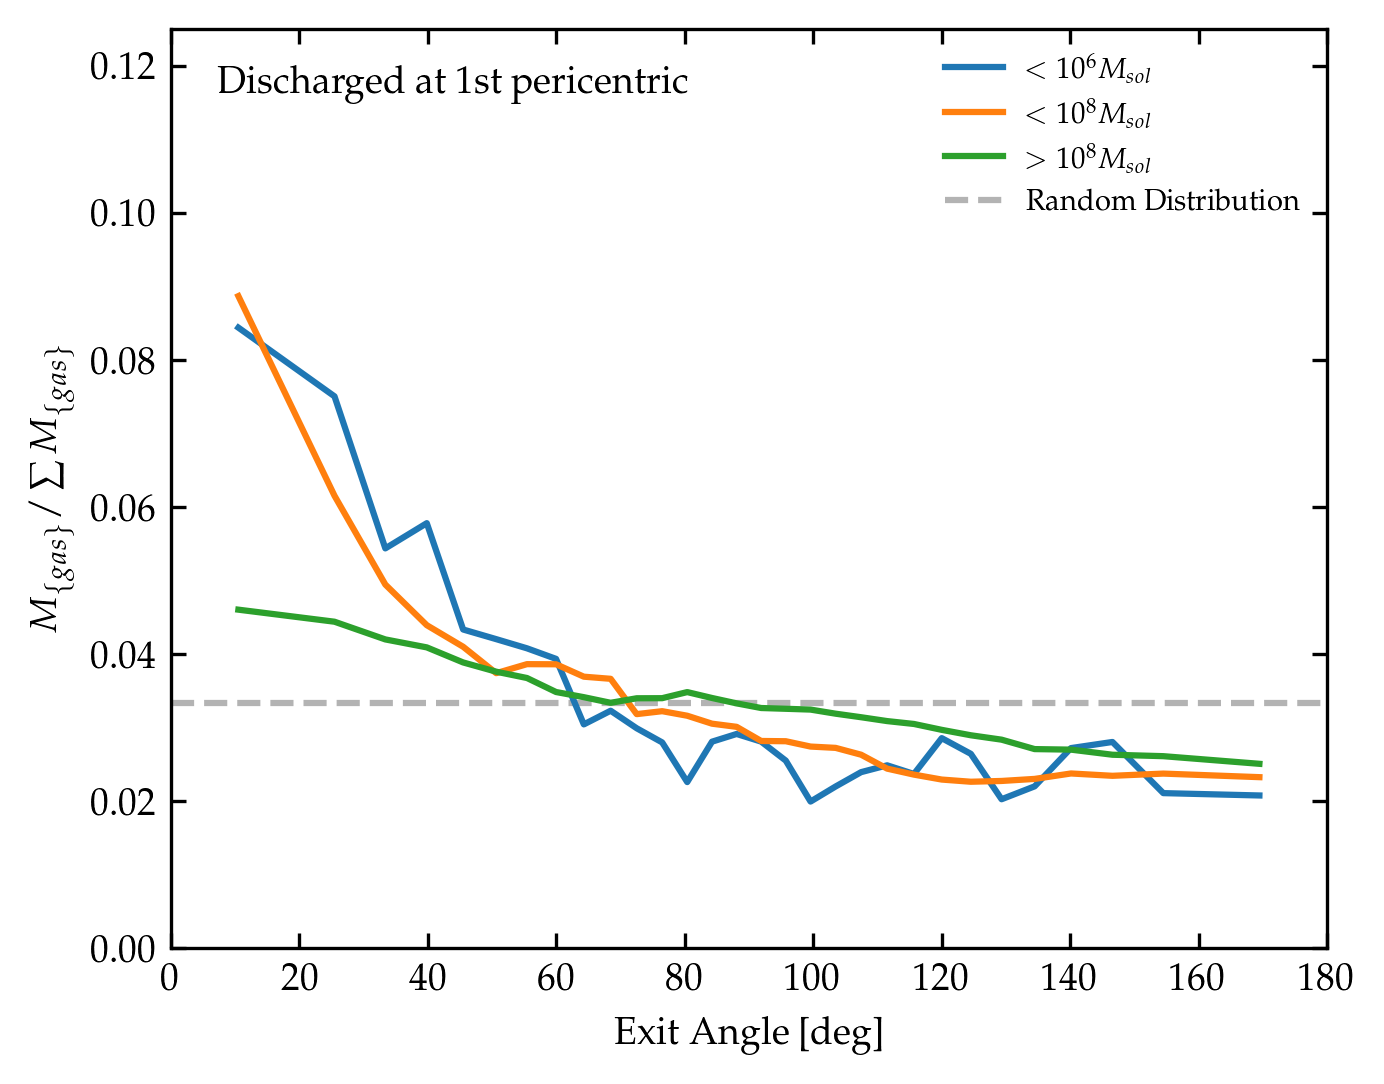

In [21]:
#plotting
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True) 

y1, bins = np.histogram(small_pericenter.angle, bins=bins, weights=wt(small_pericenter))
ax.plot(bincenters, y1, label='$ < 10^6 M_{sol}$')

y2, bins = np.histogram(mid_pericenter.angle, bins=bins, weights=wt(mid_pericenter))
ax.plot(bincenters, y2, label='$ < 10^8 M_{sol}$')

y3, bins = np.histogram(massive_pericenter.angle, bins=bins, weights=wt(massive_pericenter))
ax.plot(bincenters, y3, label='$ > 10^8 M_{sol}$')


# line representing random distribution.
percent = 1/N
ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')


# labels, axis scaling, etc.
# ax.set_title('Exit Angle Distributions for Expelled Gas', fontsize='medium')
ax.set_xlabel(r'Exit Angle [deg]')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
ax.set_xlim(0,180)
ax.set_ylim(0,0.125)

ax.legend(frameon=False, fontsize='7')

#ax.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.annotate(f"Discharged at 1st pericentric", (0.04, 0.96), xycoords='axes fraction', va='top')

#plt.savefig('plots/S24_ExitAngleMass_SmallMidMassive_Time_Pericenter.pdf')
plt.show()

In [22]:
len(small_pericenter)

2621

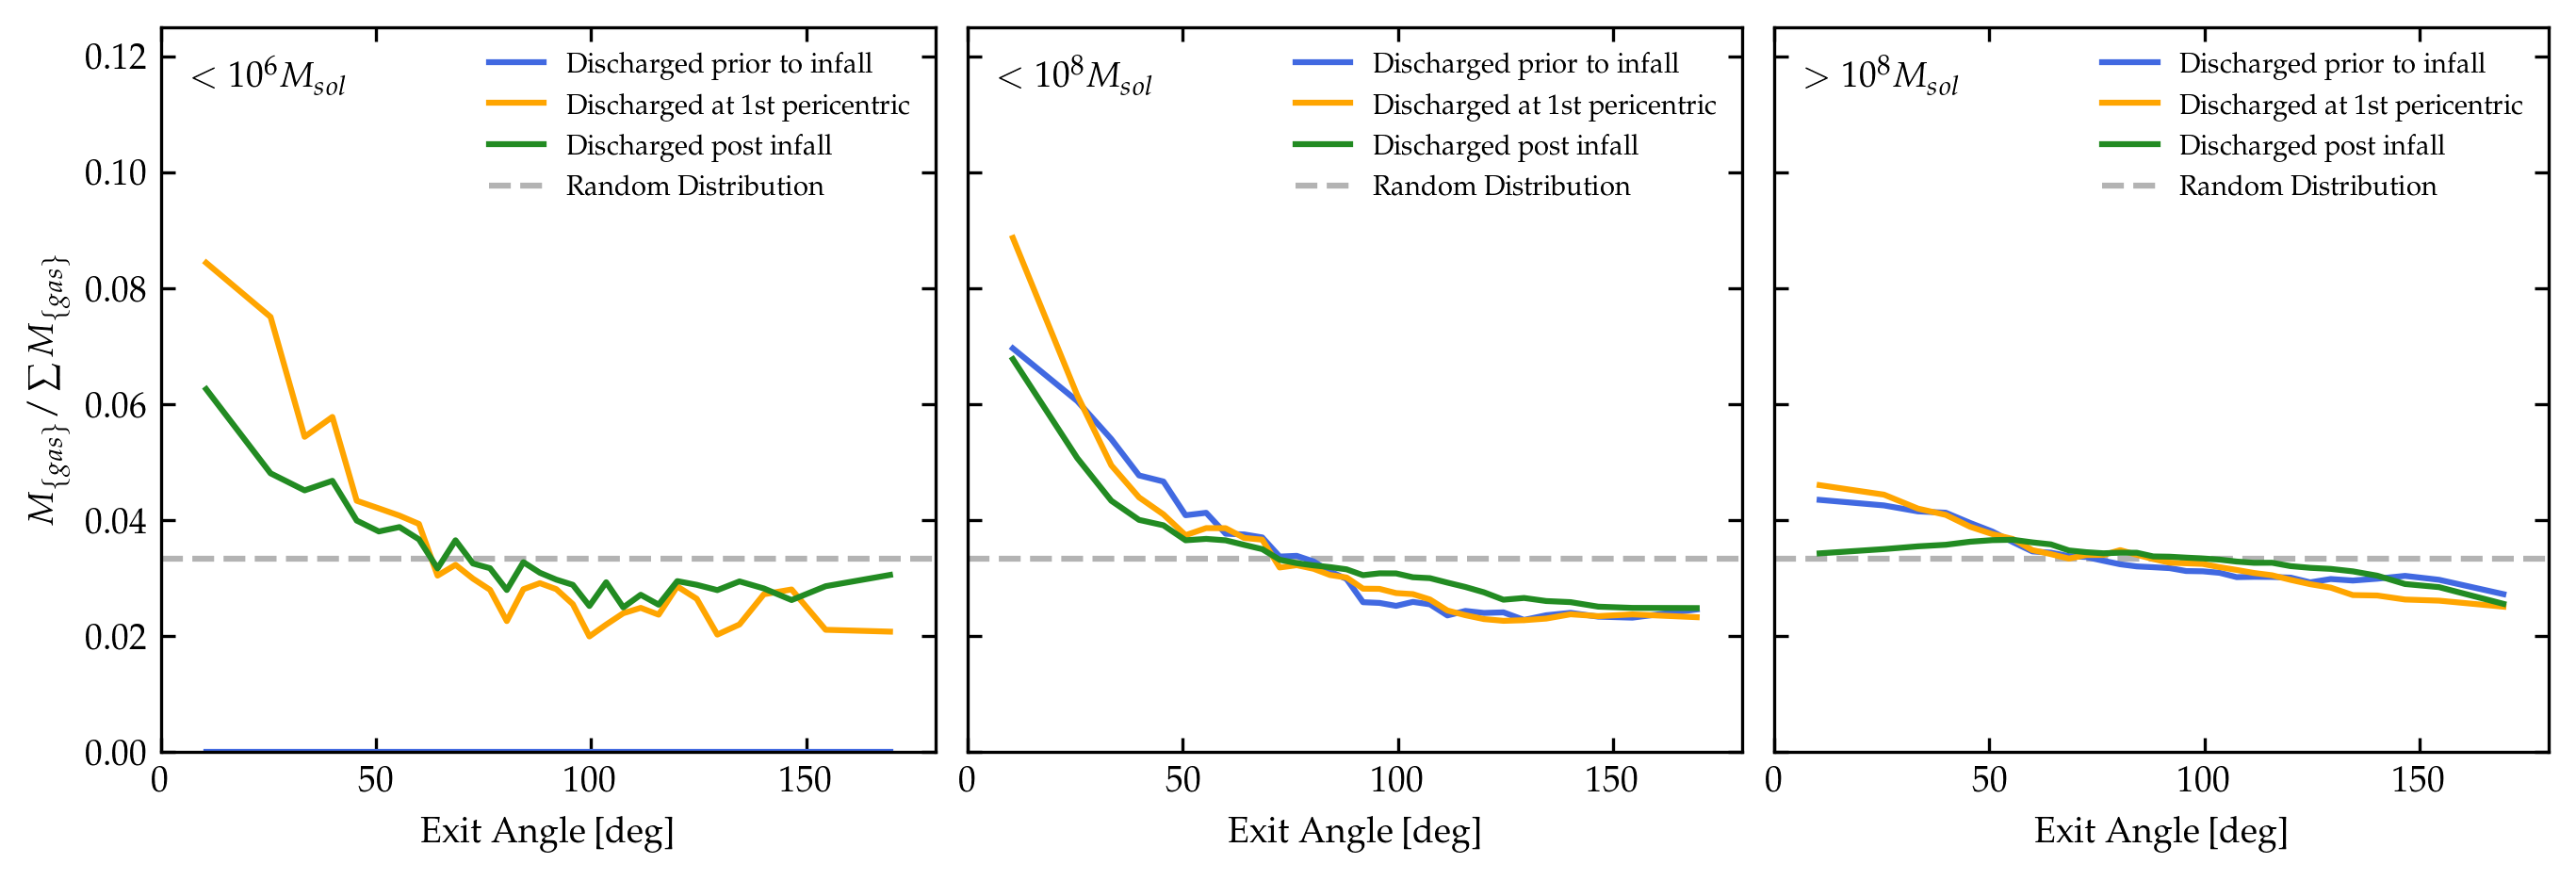

In [23]:
#plotting 3 mass bins
fig, ax = plt.subplots(1,3,figsize=(9,3),sharey=True, dpi=300, constrained_layout=True)

y1, bins = np.histogram(small_prior.angle, bins=bins, weights=wt(small_prior))
ax[0].plot(bincenters, y1, label='Discharged prior to infall', c='royalblue')

y2, bins = np.histogram(small_pericenter.angle, bins=bins, weights=wt(small_pericenter))
ax[0].plot(bincenters, y2, label='Discharged at 1st pericentric', c='orange')

y3, bins = np.histogram(small_post.angle, bins=bins, weights=wt(small_post))
ax[0].plot(bincenters, y3, label='Discharged post infall', c='forestgreen')

# y10, bins = np.histogram(small_prior.angle, bins=bins, weights=wt(small_prior))
# ax[0].plot(bincenters, y10, label='Discharged prior to infall', c='royalblue')

y4, bins = np.histogram(mid_prior.angle, bins=bins, weights=wt(mid_prior))
ax[1].plot(bincenters, y4, label='Discharged prior to infall', c='royalblue')

y5, bins = np.histogram(mid_pericenter.angle, bins=bins, weights=wt(mid_pericenter))
ax[1].plot(bincenters, y5, label='Discharged at 1st pericentric', c='orange')

y6, bins = np.histogram(mid_post.angle, bins=bins, weights=wt(mid_post))
ax[1].plot(bincenters, y6, label='Discharged post infall', c='forestgreen')

y7, bins = np.histogram(massive_prior.angle, bins=bins, weights=wt(massive_prior))
ax[2].plot(bincenters, y7, label='Discharged prior to infall', c='royalblue')

y8, bins = np.histogram(massive_pericenter.angle, bins=bins, weights=wt(massive_pericenter))
ax[2].plot(bincenters, y8, label='Discharged at 1st pericentric', c='orange')

y9, bins = np.histogram(massive_post.angle, bins=bins, weights=wt(massive_post))
ax[2].plot(bincenters, y9, label='Discharged post infall', c='forestgreen')

# line representing random distribution.
percent = 1/N
ax[0].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')
ax[1].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')
ax[2].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')


# labels, axis scaling, etc.
# ax.set_title('Exit Angle Distributions for Expelled Gas', fontsize='medium')
ax[0].set_xlabel(r'Exit Angle [deg]')
ax[1].set_xlabel(r'Exit Angle [deg]')
ax[2].set_xlabel(r'Exit Angle [deg]')
ax[0].set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
ax[0].set_xlim(0,180)
ax[0].set_ylim(0,0.125)
ax[1].set_xlim(0,180)
ax[1].set_ylim(0,0.125)
ax[2].set_xlim(0,180)
ax[2].set_ylim(0,0.125)

ax[0].legend(frameon=False, fontsize='7')
ax[1].legend(frameon=False, fontsize='7')
ax[2].legend(frameon=False, fontsize='7')

# ax[0].tick_params(direction='in',which='both',right=True,top=True)
# ax[1].tick_params(direction='in',which='both',right=True,top=True)
ax[0].annotate("$< 10^6 M_{sol}$", (0.04, 0.96), xycoords='axes fraction', va='top')
ax[1].annotate("$< 10^8 M_{sol}$", (0.04, 0.96), xycoords='axes fraction', va='top')
ax[2].annotate("$> 10^8 M_{sol}$", (0.04, 0.96), xycoords='axes fraction', va='top')

#plt.savefig('plots/S24_ExitAngleMassRebin_Time_PriorPostPericenter.pdf')
plt.show()

In [24]:
print(len(small_pericenter),len(mid_pericenter),len(massive_pericenter))

2621 148099 813871


In [25]:
## what about 7?
small2_pericenter = pericenter_all[pericenter_all['sat_Mstar'] < 10**7]
mid2_pericenter = pericenter_all[(pericenter_all['sat_Mstar'] > 10**7) & (pericenter_all['sat_Mstar'] < 10**8)]
massive2_pericenter = pericenter_all[pericenter_all['sat_Mstar'] > 10**8]

small2_prior = prior_all[prior_all['sat_Mstar'] < 10**7]
mid2_prior = prior_all[(prior_all['sat_Mstar'] > 10**7) & (prior_all['sat_Mstar'] < 10**8)]
massive2_prior = prior_all[prior_all['sat_Mstar'] > 10**8]

small2_post = post_all[post_all['sat_Mstar'] < 10**7]
mid2_post = post_all[(post_all['sat_Mstar'] > 10**7) & (post_all['sat_Mstar'] < 10**8)]
massive2_post = post_all[post_all['sat_Mstar'] > 10**8]

53840 96880 813871


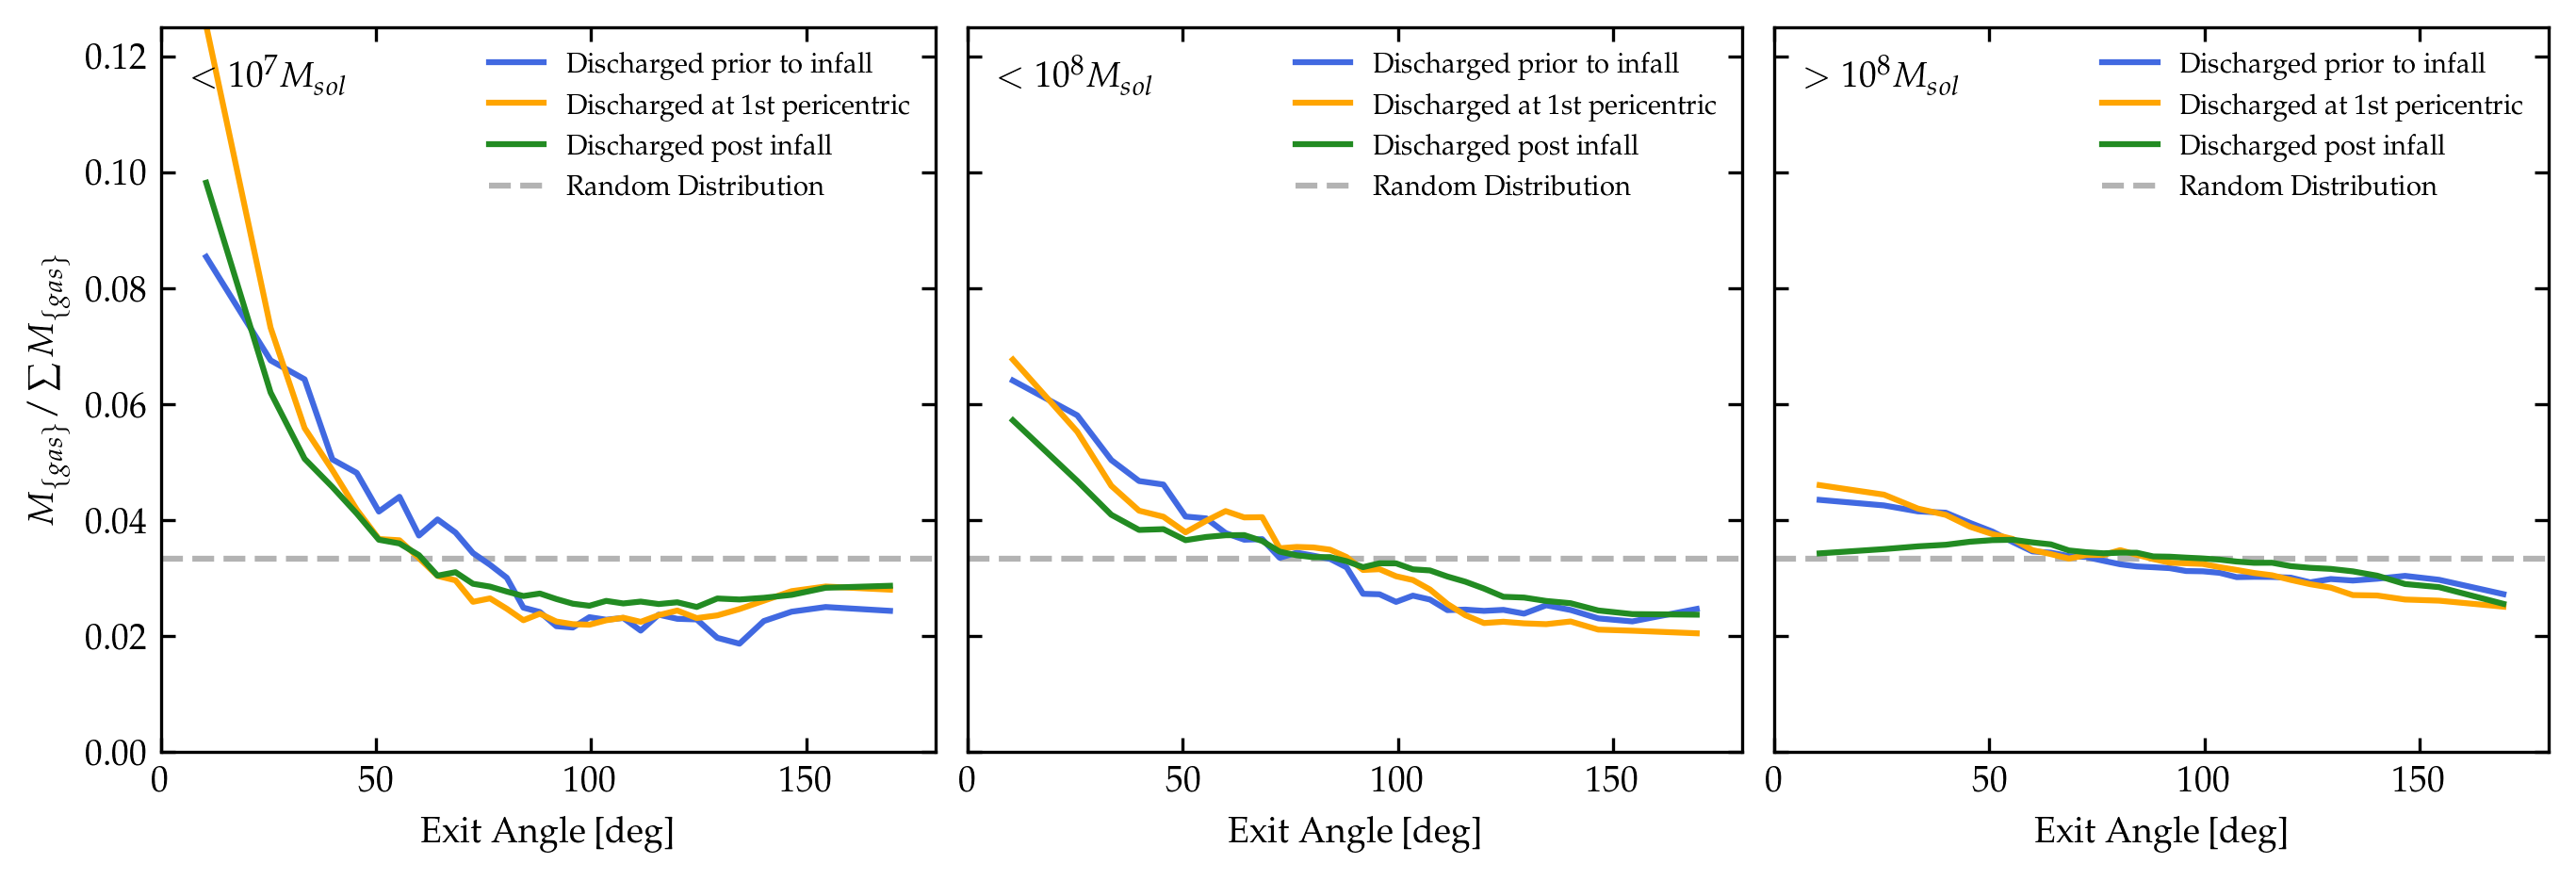

In [26]:
#plotting 3 mass bins
fig, ax = plt.subplots(1,3,figsize=(9,3),sharey=True, dpi=300, constrained_layout=True)

y1, bins = np.histogram(small2_prior.angle, bins=bins, weights=wt(small2_prior))
ax[0].plot(bincenters, y1, label='Discharged prior to infall', c='royalblue')

y2, bins = np.histogram(small2_pericenter.angle, bins=bins, weights=wt(small2_pericenter))
ax[0].plot(bincenters, y2, label='Discharged at 1st pericentric', c='orange')

y3, bins = np.histogram(small2_post.angle, bins=bins, weights=wt(small2_post))
ax[0].plot(bincenters, y3, label='Discharged post infall', c='forestgreen')

# y10, bins = np.histogram(small_prior.angle, bins=bins, weights=wt(small_prior))
# ax[0].plot(bincenters, y10, label='Discharged prior to infall', c='royalblue')

y4, bins = np.histogram(mid2_prior.angle, bins=bins, weights=wt(mid2_prior))
ax[1].plot(bincenters, y4, label='Discharged prior to infall', c='royalblue')

y5, bins = np.histogram(mid2_pericenter.angle, bins=bins, weights=wt(mid2_pericenter))
ax[1].plot(bincenters, y5, label='Discharged at 1st pericentric', c='orange')

y6, bins = np.histogram(mid2_post.angle, bins=bins, weights=wt(mid2_post))
ax[1].plot(bincenters, y6, label='Discharged post infall', c='forestgreen')

y7, bins = np.histogram(massive2_prior.angle, bins=bins, weights=wt(massive2_prior))
ax[2].plot(bincenters, y7, label='Discharged prior to infall', c='royalblue')

y8, bins = np.histogram(massive2_pericenter.angle, bins=bins, weights=wt(massive2_pericenter))
ax[2].plot(bincenters, y8, label='Discharged at 1st pericentric', c='orange')

y9, bins = np.histogram(massive2_post.angle, bins=bins, weights=wt(massive2_post))
ax[2].plot(bincenters, y9, label='Discharged post infall', c='forestgreen')

# line representing random distribution.
percent = 1/N
ax[0].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')
ax[1].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')
ax[2].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')


# labels, axis scaling, etc.
# ax.set_title('Exit Angle Distributions for Expelled Gas', fontsize='medium')
ax[0].set_xlabel(r'Exit Angle [deg]')
ax[1].set_xlabel(r'Exit Angle [deg]')
ax[2].set_xlabel(r'Exit Angle [deg]')
ax[0].set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
ax[0].set_xlim(0,180)
ax[0].set_ylim(0,0.125)
ax[1].set_xlim(0,180)
ax[1].set_ylim(0,0.125)
ax[2].set_xlim(0,180)
ax[2].set_ylim(0,0.125)

ax[0].legend(frameon=False, fontsize='7')
ax[1].legend(frameon=False, fontsize='7')
ax[2].legend(frameon=False, fontsize='7')

# ax[0].tick_params(direction='in',which='both',right=True,top=True)
# ax[1].tick_params(direction='in',which='both',right=True,top=True)
ax[0].annotate("$< 10^7 M_{sol}$", (0.04, 0.96), xycoords='axes fraction', va='top')
ax[1].annotate("$< 10^8 M_{sol}$", (0.04, 0.96), xycoords='axes fraction', va='top')
ax[2].annotate("$> 10^8 M_{sol}$", (0.04, 0.96), xycoords='axes fraction', va='top')

#plt.savefig('plots/S24_ExitAngleMassRebin7_Time_PriorPostPericenter.pdf')
print(len(small2_pericenter),len(mid2_pericenter),len(massive2_pericenter))
plt.show()